In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import math
import string
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import words
from nltk.corpus import stopwords
from contractions import CONTRACTION_MAP
from stopwords import stop_words

dat = pd.read_csv('review_ver2.csv', encoding = "ISO-8859-1")
# Change the display size
pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [2]:
#this function expands words such as I'll to I will
def expand_contractions(word):
    expanded = ' '.join([CONTRACTION_MAP[t] if t in CONTRACTION_MAP else t for t in word.split(" ") ])
    return expanded

In [3]:
#this function gets the wordnet pos tag
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N":wordnet.NOUN, "V":wordnet.VERB, "R":wordnet.ADV}
    
    return tag_dict.get(tag,wordnet.NOUN)
    
#this function preprocesses the review texts
def preprocessing_text(text):
    #contractions
    expanded_text=expand_contractions(text)
    #remove numbers
    numbers_removed = re.sub(r'\d+','',expanded_text)
    #remove punctuation
    punct_removed = re.sub(r'[^\w\s]','',numbers_removed)
    #tokenization
    tokens = nltk.word_tokenize(punct_removed.lower())
    
    #remove stop words and lemmatization
    lem_words = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    for word in tokens:
        temp_word = lemmatizer.lemmatize(word,get_wordnet_pos(word))
        if  temp_word not in stop_words:
            lem_words.append(temp_word)

    return lem_words

    return tokens


In [4]:
#this function gets the bigram of the review texts
def get_bigram(lem_words):
    
    if len(lem_words) <= 1: #meaning token is just one, unable to perform bigram
        return lem_words
    
    else:
        #bigram is in the form of [('wordA','wordB'),('wordB,'wordC'),...]
        bigrm = list(nltk.bigrams(lem_words))

        #make the bigram in this format ['wordA wordB','wordB wordC',...]
        bigrm_list = []
        separator = ' '
        for i in range(len(bigrm)):
            bigrm_list.append(separator.join(bigrm[i]))   
        return bigrm_list

In [5]:
#applies the preprocessing_text function on all items in the review column
print(datetime.datetime.now())
lem_tokens = dat['review'].apply(preprocessing_text)
print("done 1")
print(datetime.datetime.now())
#applies the get_bigram function on all the items in the review column
bigram_list = lem_tokens.apply(get_bigram)
print("done 2")
print(datetime.datetime.now())

2019-05-03 20:56:06.148941
done 1
2019-05-03 21:19:34.744416
done 2
2019-05-03 21:19:37.144787


In [6]:
#make sure all ratings are numbers

def check_rating(rates,bigram):
    new_bigram = []
    new_rating = []
    
    for i in range(len(rates)):
        try:
            new_rating.append(int(rates[i]))
            new_bigram.append(bigram[i])
        except:
#             print("skip")
            pass
        
    return new_bigram, new_rating

rate_list=dat['rating'].values.tolist()

new_bigram, new_rating = check_rating(rate_list,bigram_list)
# print(len(new_bigram),len(new_rating),new_bigram[0])


#putting the series of review texts into data frame
df_bigram = pd.DataFrame({'review':new_bigram})
df_rate = pd.DataFrame({'rating':new_rating})
#concatenating the new data frame with ratings column
result = pd.concat([df_bigram,df_rate],axis=1)
print(result.head(10))

                                              review  rating
0  [part magic, magic grow, grow boy, boy buy, bu...       4
1  [amaze detail, detail every, every credit, cre...       5
2  [purchase behalf, behalf dad, dad always, alwa...       5
3  [everything really, really need, need see, see...       5
4  [collect glossy, glossy picture, picture great...       5
5  [great book, book extremely, extremely useful,...       5
6  [useful info, info someonelike, someonelike st...       5
7  [well produce, produce good, good quality, qua...       5
8     [happy communication, communication funkybuys]       4
9                                        [great buy]       5


In [7]:
# tf-idf using built-in function
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
#Version 1: calculating tfidf values

X_train_1 = result['review'].values
Y_train_1 = result['rating'].values

def identity_tokenizer(text):
    return text

tfidf_1 = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word',preprocessor = identity_tokenizer,lowercase=True)    
X_1 = tfidf_1.fit_transform(X_train_1)


In [10]:
tfidf_val_1 = []
rating_list_1 = []
features = []
feature_names = tfidf_1.get_feature_names()
corpus_index = [n for n in range(len(X_train_1))]

rows, cols = X_1.nonzero()

previous_row = 0
temp=[]
temp_fea = []
for row, col in zip(rows, cols):
    #print((feature_names[col], corpus_index[row]), X_1[row, col])
    if row == previous_row:
        temp.append(X_1[row,col])
        temp_fea.append(feature_names[col])
        
    else:
        tfidf_val_1.append(temp)
        features.append(temp_fea)
        try:
            temp_rating = int(Y_train_1[corpus_index[previous_row]])
            
        except:
            pass
        
        rating_list_1.append(temp_rating)
        temp = []
        temp_fea = []
        previous_row = row
        temp.append(X_1[row,col])
        temp_fea.append(feature_names[col])
        
tfidf_val_1.append(temp)
features.append(temp_fea)
try:
    temp_rating = int(Y_train_1[corpus_index[previous_row]])

except:
    pass

rating_list_1.append(temp_rating)

print(len(tfidf_val_1),len(rating_list_1),len(features))
    

28172 28172 28172


In [11]:

tfidf_val = []
rating_val = []
print(datetime.datetime.now())
for i in range(len(tfidf_val_1)):
    tempp = [0] * 3
#     tfidf_val_1[i].sort()
    tfidf_val_1[i], features[i] = (list(x) for x in zip(*sorted(zip(tfidf_val_1[i], features[i]))))


    if len(tfidf_val_1[i]) <= 2:
        for j in range(len(tfidf_val_1[i])):
            tempp[j] = tfidf_val_1[i][j] 
#             print(features[i][j])
#             tfidf_val.append(tfidf_val_1[i][j])
#             rating_val.append(rating_list_1[i])
            
    else:
        for j in range(3):   
            tempp[j] = tfidf_val_1[i][j]
#             tfidf_val.append(tfidf_val_1[i][j])
#             rating_val.append(rating_list_1[i])
#             print(features[i][j])
    tfidf_val.append(tempp)
        

df_tfidf_1 = pd.DataFrame({'tfidf_1':tfidf_val})
df_rating_1 = pd.DataFrame({'ratings':rating_list_1})
#concatenating the new data frame
FE_result_1 = pd.concat([df_tfidf_1,df_rating_1],axis=1)
print(FE_result_1.head(10))


2019-05-03 11:24:23.589325
                                             tfidf_1  ratings
0  [0.1213863716833143, 0.1256781988288966, 0.128...        4
1  [0.17546554690204672, 0.19803933673140053, 0.2...        5
2  [0.1328000692892769, 0.13771581038331943, 0.14...        5
3  [0.21664170093995144, 0.24453514319225061, 0.2...        5
4  [0.2852873217778441, 0.32892856937814924, 0.33...        5
5  [0.21043360170387063, 0.36840899001980226, 0.3...        5
6  [0.26091699194578666, 0.3813692638149662, 0.39...        5
7  [0.18479195431437187, 0.4024302750744951, 0.41...        5
8        [0.7071067811865475, 0.7071067811865475, 0]        4
9                                        [1.0, 0, 0]        5


In [53]:
#Version 2: sorts the idf values for each features and select the top highest idf values

# X_train_2 = result['review'].values
X_train_2 = [['ho','true','ho'],['meow','fish'],['ho','true','meow','fish']]
# Y_train_2 = result['rating'].values
Y_train_2 = [3,4,5]

tfidf_2 = TfidfVectorizer(tokenizer=identity_tokenizer, analyzer='word',preprocessor = identity_tokenizer,lowercase=True)    
X_2 = tfidf_2.fit_transform(X_train_2)

# sorts according to idf
indices = np.argsort(tfidf_2.idf_)[::-1]
# print(indices)
features = tfidf_2.get_feature_names()

tfidf_val_2 = []
rating_list_2 = []

corpus_index = [n for n in range(len(X_train_2))]
rows, cols = X_2.nonzero()
for i in range(2):   #cannot be longer than length of indices, length of indices are the number of unique bigram
    for row, col in zip(rows,cols):
        print(features[col],corpus_index[row],X_2[row,col])
        if col == indices[i]:
    #             print(features[col],corpus_index[row],X_2[row,col])
            print(features[col])
            tfidf_val_2.append(X_2[row,col])

            try:
                temp = int(Y_train_2[corpus_index[row]])

            except:
                pass

            rating_list_2.append(temp)
            
#             rating_list_2.append(Y_train_2[corpus_index[row]])
            
# print(tfidf_val_2)
# print(rating_list_2)
print(len(tfidf_val_2),len(rating_list_2))
df_tfidf_2 = pd.DataFrame({'tfidf_2':tfidf_val_2})
df_rating_2 = pd.DataFrame({'ratings':rating_list_2})
#concatenating the new data frame
FE_result_2 = pd.concat([df_tfidf_2,df_rating_2],axis=1)
print(FE_result_2.head(10))

ho 0 0.8944271909999159
true 0 0.4472135954999579
true
meow 1 0.7071067811865476
fish 1 0.7071067811865476
ho 2 0.5
true 2 0.5
true
meow 2 0.5
fish 2 0.5
ho 0 0.8944271909999159
true 0 0.4472135954999579
meow 1 0.7071067811865476
meow
fish 1 0.7071067811865476
ho 2 0.5
true 2 0.5
meow 2 0.5
meow
fish 2 0.5
4 4
    tfidf_2  ratings
0  0.447214        3
1  0.500000        5
2  0.707107        4
3  0.500000        5


In [144]:

# Version 3: mutual information classification
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer

def identity_tokenizer(docs):
    return docs

X_3 = np.array(result['review'].values)
Y_3 = np.array(result['rating'].values)

cv = CountVectorizer(tokenizer=identity_tokenizer,preprocessor = identity_tokenizer,max_features=10)
X_vec = cv.fit_transform(X_3)

feature_scores = mutual_info_classif(X_vec, Y_3)
print(feature_scores)

# for score, fname in sorted(zip(feature_scores, dv.get_feature_names()), reverse=True)[:10]:
#     print(fname, score)

tfidf_val_3 = []
rating_list_3 = []
feature_names = cv.get_feature_names()
corpus_index = [n for n in range(len(X_3))]
# print(corpus_index)
rows, cols = X_vec.nonzero()

for i in range(len(feature_scores)):
    for row,col in zip(rows,cols):
        print(feature_names[col],corpus_index[row],feature_scores[i])

# previous_row = 0
# temp=[]
# for row, col in zip(rows, cols):
# #     print(row)
#     #print((feature_names[col], corpus_index[row]), X_1[row, col])
#     if row == previous_row:
# #         print("ho",feature_names[col])
#         temp.append(X_1[row,col])
        
#     else:
# #         print("hoho",feature_names[col])
#         tfidf_val_1.append(temp)
#         try:
#             temp_rating = int(Y_train_1[corpus_index[previous_row]])
            
#         except:
#             pass
        
#         rating_list_1.append(temp_rating)
#         temp = []
#         previous_row = row
#         temp.append(X_1[row,col])
        
# tfidf_val_1.append(temp)
# try:
#     temp_rating = int(Y_train_1[corpus_index[previous_row]])

# except:
#     pass

# rating_list_1.append(temp_rating)

# # print(tfidf_val_1)
# # print(rating_list_1)
# print(len(tfidf_val_1),len(rating_list_1))
    

# temp = mutual_info_classif(X_vec, Y_3, discrete_features=True)
# print(temp)
# row,column = X_vec.nonzero()
# res = dict(zip(Y_3[row],mutual_info_classif(X_vec, Y_3, discrete_features=True)))
# print(res)

# mutual_info = []
# rating_list_3 = []
# feature_names = cv.get_feature_names()
# corpus_index = [n for n in range(len(X_3))]
# rows, cols = X_vec.nonzero()
# for row, col in zip(rows, cols):
#     print((feature_names[col], corpus_index[row]))
#     tfidf_val_1.append(X_1[row,col])
    
#     try:
#         temp = int(Y_train_1[corpus_index[row]])
        
#     except:
#         pass

[0.00057185 0.00107064 0.00094166 0.0030566  0.00046679 0.00062332
 0.00056013 0.00129845 0.00025398 0.00081163]
good quality 7 0.0005718526549220867
value money 12 0.0005718526549220867
good value 12 0.0005718526549220867
really good 12 0.0005718526549220867
would recommend 13 0.0005718526549220867
year old 15 0.0005718526549220867
highly recommend 19 0.0005718526549220867
good value 22 0.0005718526549220867
value money 27 0.0005718526549220867
year old 45 0.0005718526549220867
year old 55 0.0005718526549220867
well make 56 0.0005718526549220867
year old 56 0.0005718526549220867
well make 60 0.0005718526549220867
year old 62 0.0005718526549220867
well make 65 0.0005718526549220867
well make 68 0.0005718526549220867
year old 77 0.0005718526549220867
son love 78 0.0005718526549220867
highly recommend 80 0.0005718526549220867
would recommend 88 0.0005718526549220867
good quality 92 0.0005718526549220867
would recommend 100 0.0005718526549220867
good value 103 0.0005718526549220867
really

son love 1775 0.0005718526549220867
year old 1775 0.0005718526549220867
really good 1776 0.0005718526549220867
well make 1777 0.0005718526549220867
would recommend 1778 0.0005718526549220867
good quality 1782 0.0005718526549220867
well make 1784 0.0005718526549220867
good quality 1784 0.0005718526549220867
well make 1785 0.0005718526549220867
value money 1785 0.0005718526549220867
well make 1786 0.0005718526549220867
good value 1787 0.0005718526549220867
daughter love 1788 0.0005718526549220867
would recommend 1789 0.0005718526549220867
daughter love 1790 0.0005718526549220867
daughter love 1791 0.0005718526549220867
son love 1792 0.0005718526549220867
year old 1793 0.0005718526549220867
year old 1795 0.0005718526549220867
good quality 1795 0.0005718526549220867
son love 1796 0.0005718526549220867
year old 1797 0.0005718526549220867
value money 1800 0.0005718526549220867
really good 1802 0.0005718526549220867
year old 1805 0.0005718526549220867
year old 1807 0.0005718526549220867
year 

year old 2697 0.0005718526549220867
daughter love 2705 0.0005718526549220867
daughter love 2707 0.0005718526549220867
year old 2721 0.0005718526549220867
son love 2723 0.0005718526549220867
year old 2723 0.0005718526549220867
good quality 2723 0.0005718526549220867
good quality 2725 0.0005718526549220867
son love 2727 0.0005718526549220867
good value 2730 0.0005718526549220867
year old 2731 0.0005718526549220867
year old 2737 0.0005718526549220867
year old 2740 0.0005718526549220867
good quality 2740 0.0005718526549220867
value money 2741 0.0005718526549220867
daughter love 2745 0.0005718526549220867
year old 2754 0.0005718526549220867
year old 2755 0.0005718526549220867
good value 2763 0.0005718526549220867
year old 2764 0.0005718526549220867
good quality 2768 0.0005718526549220867
son love 2775 0.0005718526549220867
good quality 2780 0.0005718526549220867
son love 2782 0.0005718526549220867
year old 2789 0.0005718526549220867
would recommend 2791 0.0005718526549220867
value money 279

year old 4254 0.0005718526549220867
value money 4262 0.0005718526549220867
year old 4266 0.0005718526549220867
daughter love 4269 0.0005718526549220867
year old 4269 0.0005718526549220867
year old 4272 0.0005718526549220867
good value 4272 0.0005718526549220867
good value 4273 0.0005718526549220867
daughter love 4277 0.0005718526549220867
daughter love 4278 0.0005718526549220867
daughter love 4281 0.0005718526549220867
good quality 4284 0.0005718526549220867
would recommend 4285 0.0005718526549220867
year old 4286 0.0005718526549220867
really good 4291 0.0005718526549220867
good quality 4293 0.0005718526549220867
highly recommend 4305 0.0005718526549220867
year old 4311 0.0005718526549220867
really good 4311 0.0005718526549220867
value money 4313 0.0005718526549220867
good value 4313 0.0005718526549220867
value money 4316 0.0005718526549220867
good value 4316 0.0005718526549220867
year old 4321 0.0005718526549220867
value money 4322 0.0005718526549220867
year old 4323 0.000571852654922

daughter love 5183 0.0005718526549220867
good quality 5184 0.0005718526549220867
really good 5186 0.0005718526549220867
would recommend 5194 0.0005718526549220867
good quality 5196 0.0005718526549220867
year old 5205 0.0005718526549220867
really good 5209 0.0005718526549220867
year old 5213 0.0005718526549220867
good quality 5213 0.0005718526549220867
good quality 5219 0.0005718526549220867
good quality 5225 0.0005718526549220867
well make 5226 0.0005718526549220867
would recommend 5229 0.0005718526549220867
highly recommend 5232 0.0005718526549220867
would recommend 5239 0.0005718526549220867
good quality 5244 0.0005718526549220867
son love 5249 0.0005718526549220867
year old 5249 0.0005718526549220867
good value 5252 0.0005718526549220867
good quality 5260 0.0005718526549220867
highly recommend 5262 0.0005718526549220867
good quality 5263 0.0005718526549220867
year old 5267 0.0005718526549220867
would recommend 5270 0.0005718526549220867
year old 5276 0.0005718526549220867
year old 5

would recommend 7145 0.0005718526549220867
son love 7146 0.0005718526549220867
year old 7146 0.0005718526549220867
value money 7148 0.0005718526549220867
good value 7148 0.0005718526549220867
year old 7151 0.0005718526549220867
year old 7152 0.0005718526549220867
son love 7154 0.0005718526549220867
son love 7156 0.0005718526549220867
well make 7157 0.0005718526549220867
really good 7161 0.0005718526549220867
year old 7168 0.0005718526549220867
would recommend 7168 0.0005718526549220867
would recommend 7170 0.0005718526549220867
highly recommend 7178 0.0005718526549220867
year old 7181 0.0005718526549220867
year old 7182 0.0005718526549220867
year old 7198 0.0005718526549220867
year old 7202 0.0005718526549220867
year old 7203 0.0005718526549220867
year old 7205 0.0005718526549220867
would recommend 7205 0.0005718526549220867
well make 7206 0.0005718526549220867
would recommend 7207 0.0005718526549220867
good quality 7207 0.0005718526549220867
really good 7208 0.0005718526549220867
son 

good quality 8392 0.0005718526549220867
good quality 8395 0.0005718526549220867
well make 8396 0.0005718526549220867
good quality 8398 0.0005718526549220867
son love 8403 0.0005718526549220867
good quality 8409 0.0005718526549220867
daughter love 8411 0.0005718526549220867
good quality 8412 0.0005718526549220867
value money 8426 0.0005718526549220867
good quality 8428 0.0005718526549220867
good value 8430 0.0005718526549220867
highly recommend 8432 0.0005718526549220867
daughter love 8446 0.0005718526549220867
good quality 8447 0.0005718526549220867
son love 8450 0.0005718526549220867
good quality 8450 0.0005718526549220867
would recommend 8453 0.0005718526549220867
good quality 8458 0.0005718526549220867
good quality 8463 0.0005718526549220867
would recommend 8467 0.0005718526549220867
daughter love 8469 0.0005718526549220867
year old 8471 0.0005718526549220867
year old 8474 0.0005718526549220867
good quality 8474 0.0005718526549220867
would recommend 8486 0.0005718526549220867
good v

daughter love 9399 0.0005718526549220867
really good 9406 0.0005718526549220867
good quality 9406 0.0005718526549220867
would recommend 9410 0.0005718526549220867
value money 9410 0.0005718526549220867
year old 9411 0.0005718526549220867
year old 9412 0.0005718526549220867
value money 9412 0.0005718526549220867
daughter love 9414 0.0005718526549220867
year old 9414 0.0005718526549220867
good quality 9414 0.0005718526549220867
daughter love 9415 0.0005718526549220867
year old 9417 0.0005718526549220867
year old 9419 0.0005718526549220867
good quality 9419 0.0005718526549220867
really good 9426 0.0005718526549220867
good quality 9426 0.0005718526549220867
year old 9432 0.0005718526549220867
daughter love 9433 0.0005718526549220867
value money 9434 0.0005718526549220867
year old 9436 0.0005718526549220867
daughter love 9437 0.0005718526549220867
really good 9438 0.0005718526549220867
good quality 9438 0.0005718526549220867
daughter love 9439 0.0005718526549220867
well make 9452 0.00057185

highly recommend 10666 0.0005718526549220867
year old 10669 0.0005718526549220867
daughter love 10670 0.0005718526549220867
year old 10672 0.0005718526549220867
good value 10679 0.0005718526549220867
daughter love 10681 0.0005718526549220867
highly recommend 10689 0.0005718526549220867
well make 10690 0.0005718526549220867
year old 10690 0.0005718526549220867
year old 10692 0.0005718526549220867
year old 10694 0.0005718526549220867
good value 10694 0.0005718526549220867
highly recommend 10696 0.0005718526549220867
year old 10696 0.0005718526549220867
really good 10696 0.0005718526549220867
good quality 10696 0.0005718526549220867
would recommend 10699 0.0005718526549220867
highly recommend 10700 0.0005718526549220867
daughter love 10701 0.0005718526549220867
value money 10701 0.0005718526549220867
well make 10702 0.0005718526549220867
would recommend 10702 0.0005718526549220867
highly recommend 10724 0.0005718526549220867
value money 10724 0.0005718526549220867
good value 10724 0.00057

year old 11396 0.0005718526549220867
son love 11400 0.0005718526549220867
really good 11409 0.0005718526549220867
value money 11414 0.0005718526549220867
good quality 11415 0.0005718526549220867
well make 11418 0.0005718526549220867
year old 11419 0.0005718526549220867
year old 11423 0.0005718526549220867
would recommend 11428 0.0005718526549220867
good value 11429 0.0005718526549220867
value money 11430 0.0005718526549220867
son love 11434 0.0005718526549220867
son love 11435 0.0005718526549220867
well make 11436 0.0005718526549220867
son love 11437 0.0005718526549220867
good quality 11437 0.0005718526549220867
well make 11438 0.0005718526549220867
value money 11440 0.0005718526549220867
good quality 11441 0.0005718526549220867
good quality 11444 0.0005718526549220867
year old 11448 0.0005718526549220867
well make 11454 0.0005718526549220867
well make 11457 0.0005718526549220867
year old 11457 0.0005718526549220867
year old 11458 0.0005718526549220867
good value 11460 0.00057185265492

daughter love 12335 0.0005718526549220867
son love 12336 0.0005718526549220867
good quality 12336 0.0005718526549220867
highly recommend 12340 0.0005718526549220867
year old 12340 0.0005718526549220867
good value 12340 0.0005718526549220867
would recommend 12341 0.0005718526549220867
well make 12347 0.0005718526549220867
well make 12349 0.0005718526549220867
daughter love 12352 0.0005718526549220867
well make 12358 0.0005718526549220867
year old 12358 0.0005718526549220867
well make 12362 0.0005718526549220867
daughter love 12363 0.0005718526549220867
year old 12366 0.0005718526549220867
daughter love 12371 0.0005718526549220867
well make 12372 0.0005718526549220867
daughter love 12375 0.0005718526549220867
year old 12377 0.0005718526549220867
highly recommend 12381 0.0005718526549220867
highly recommend 12382 0.0005718526549220867
would recommend 12390 0.0005718526549220867
well make 12397 0.0005718526549220867
well make 12399 0.0005718526549220867
year old 12400 0.0005718526549220867

good quality 12941 0.0005718526549220867
well make 12947 0.0005718526549220867
well make 12948 0.0005718526549220867
well make 12950 0.0005718526549220867
year old 12953 0.0005718526549220867
year old 12956 0.0005718526549220867
well make 12959 0.0005718526549220867
year old 12960 0.0005718526549220867
well make 12961 0.0005718526549220867
good value 12966 0.0005718526549220867
good quality 12969 0.0005718526549220867
well make 12972 0.0005718526549220867
good quality 12972 0.0005718526549220867
good quality 12973 0.0005718526549220867
year old 12974 0.0005718526549220867
would recommend 12978 0.0005718526549220867
son love 12980 0.0005718526549220867
year old 12980 0.0005718526549220867
year old 12984 0.0005718526549220867
good quality 12984 0.0005718526549220867
value money 12985 0.0005718526549220867
well make 12986 0.0005718526549220867
well make 12987 0.0005718526549220867
value money 12988 0.0005718526549220867
good value 12988 0.0005718526549220867
value money 12989 0.0005718526

value money 13877 0.0005718526549220867
good quality 13877 0.0005718526549220867
good value 13884 0.0005718526549220867
really good 13884 0.0005718526549220867
good quality 13884 0.0005718526549220867
son love 13886 0.0005718526549220867
really good 13891 0.0005718526549220867
would recommend 13893 0.0005718526549220867
highly recommend 13911 0.0005718526549220867
good quality 13912 0.0005718526549220867
year old 13922 0.0005718526549220867
good quality 13923 0.0005718526549220867
would recommend 13926 0.0005718526549220867
value money 13926 0.0005718526549220867
good value 13926 0.0005718526549220867
value money 13937 0.0005718526549220867
good quality 13938 0.0005718526549220867
value money 13943 0.0005718526549220867
good value 13943 0.0005718526549220867
value money 13944 0.0005718526549220867
good value 13944 0.0005718526549220867
good quality 13946 0.0005718526549220867
good quality 13947 0.0005718526549220867
good quality 13952 0.0005718526549220867
would recommend 13960 0.00057

highly recommend 15672 0.0005718526549220867
good quality 15672 0.0005718526549220867
good quality 15674 0.0005718526549220867
good quality 15680 0.0005718526549220867
highly recommend 15685 0.0005718526549220867
good quality 15688 0.0005718526549220867
good quality 15689 0.0005718526549220867
good quality 15691 0.0005718526549220867
son love 15694 0.0005718526549220867
daughter love 15695 0.0005718526549220867
well make 15698 0.0005718526549220867
year old 15698 0.0005718526549220867
good quality 15701 0.0005718526549220867
son love 15706 0.0005718526549220867
son love 15716 0.0005718526549220867
value money 15718 0.0005718526549220867
good value 15718 0.0005718526549220867
well make 15722 0.0005718526549220867
well make 15727 0.0005718526549220867
really good 15729 0.0005718526549220867
year old 15732 0.0005718526549220867
good value 15733 0.0005718526549220867
would recommend 15734 0.0005718526549220867
son love 15741 0.0005718526549220867
would recommend 15745 0.0005718526549220867

son love 16899 0.0005718526549220867
highly recommend 16900 0.0005718526549220867
well make 16901 0.0005718526549220867
year old 16903 0.0005718526549220867
year old 16912 0.0005718526549220867
value money 16912 0.0005718526549220867
year old 16914 0.0005718526549220867
year old 16916 0.0005718526549220867
son love 16917 0.0005718526549220867
really good 16924 0.0005718526549220867
son love 16926 0.0005718526549220867
year old 16926 0.0005718526549220867
year old 16927 0.0005718526549220867
really good 16927 0.0005718526549220867
year old 16930 0.0005718526549220867
year old 16932 0.0005718526549220867
year old 16935 0.0005718526549220867
son love 16937 0.0005718526549220867
well make 16937 0.0005718526549220867
well make 16940 0.0005718526549220867
good quality 16940 0.0005718526549220867
year old 16941 0.0005718526549220867
daughter love 16942 0.0005718526549220867
year old 16944 0.0005718526549220867
well make 16946 0.0005718526549220867
year old 16946 0.0005718526549220867
year old

year old 18060 0.0005718526549220867
good value 18061 0.0005718526549220867
well make 18063 0.0005718526549220867
year old 18063 0.0005718526549220867
year old 18064 0.0005718526549220867
year old 18065 0.0005718526549220867
value money 18074 0.0005718526549220867
good value 18074 0.0005718526549220867
son love 18078 0.0005718526549220867
value money 18085 0.0005718526549220867
year old 18091 0.0005718526549220867
would recommend 18091 0.0005718526549220867
year old 18099 0.0005718526549220867
would recommend 18105 0.0005718526549220867
good quality 18119 0.0005718526549220867
good quality 18120 0.0005718526549220867
son love 18124 0.0005718526549220867
year old 18124 0.0005718526549220867
good quality 18124 0.0005718526549220867
daughter love 18126 0.0005718526549220867
year old 18131 0.0005718526549220867
value money 18131 0.0005718526549220867
good value 18131 0.0005718526549220867
daughter love 18133 0.0005718526549220867
highly recommend 18143 0.0005718526549220867
highly recommen

son love 19386 0.0005718526549220867
year old 19387 0.0005718526549220867
would recommend 19388 0.0005718526549220867
value money 19388 0.0005718526549220867
year old 19389 0.0005718526549220867
good quality 19395 0.0005718526549220867
year old 19402 0.0005718526549220867
year old 19403 0.0005718526549220867
son love 19406 0.0005718526549220867
value money 19411 0.0005718526549220867
good value 19411 0.0005718526549220867
year old 19413 0.0005718526549220867
year old 19414 0.0005718526549220867
daughter love 19416 0.0005718526549220867
year old 19419 0.0005718526549220867
year old 19420 0.0005718526549220867
would recommend 19425 0.0005718526549220867
really good 19425 0.0005718526549220867
would recommend 19433 0.0005718526549220867
year old 19448 0.0005718526549220867
really good 19454 0.0005718526549220867
good value 19455 0.0005718526549220867
daughter love 19457 0.0005718526549220867
highly recommend 19457 0.0005718526549220867
year old 19457 0.0005718526549220867
year old 19458 0

good value 20463 0.0005718526549220867
year old 20473 0.0005718526549220867
highly recommend 20475 0.0005718526549220867
daughter love 20476 0.0005718526549220867
year old 20476 0.0005718526549220867
year old 20477 0.0005718526549220867
year old 20478 0.0005718526549220867
would recommend 20478 0.0005718526549220867
highly recommend 20479 0.0005718526549220867
daughter love 20486 0.0005718526549220867
year old 20492 0.0005718526549220867
good value 20495 0.0005718526549220867
well make 20500 0.0005718526549220867
year old 20500 0.0005718526549220867
year old 20503 0.0005718526549220867
year old 20505 0.0005718526549220867
value money 20505 0.0005718526549220867
good value 20505 0.0005718526549220867
year old 20506 0.0005718526549220867
year old 20507 0.0005718526549220867
year old 20508 0.0005718526549220867
year old 20512 0.0005718526549220867
year old 20514 0.0005718526549220867
really good 20516 0.0005718526549220867
good quality 20524 0.0005718526549220867
year old 20525 0.00057185

year old 21359 0.0005718526549220867
year old 21362 0.0005718526549220867
year old 21366 0.0005718526549220867
well make 21371 0.0005718526549220867
well make 21372 0.0005718526549220867
year old 21374 0.0005718526549220867
well make 21382 0.0005718526549220867
well make 21388 0.0005718526549220867
good quality 21398 0.0005718526549220867
value money 21400 0.0005718526549220867
good value 21400 0.0005718526549220867
well make 21407 0.0005718526549220867
son love 21413 0.0005718526549220867
good value 21413 0.0005718526549220867
value money 21420 0.0005718526549220867
good quality 21422 0.0005718526549220867
well make 21427 0.0005718526549220867
year old 21427 0.0005718526549220867
daughter love 21428 0.0005718526549220867
year old 21428 0.0005718526549220867
would recommend 21428 0.0005718526549220867
would recommend 21429 0.0005718526549220867
good value 21429 0.0005718526549220867
well make 21432 0.0005718526549220867
well make 21434 0.0005718526549220867
good quality 21434 0.0005718

daughter love 22338 0.0005718526549220867
daughter love 22339 0.0005718526549220867
year old 22342 0.0005718526549220867
year old 22343 0.0005718526549220867
daughter love 22352 0.0005718526549220867
year old 22357 0.0005718526549220867
daughter love 22358 0.0005718526549220867
year old 22360 0.0005718526549220867
daughter love 22361 0.0005718526549220867
well make 22361 0.0005718526549220867
year old 22361 0.0005718526549220867
value money 22361 0.0005718526549220867
year old 22362 0.0005718526549220867
good quality 22362 0.0005718526549220867
year old 22365 0.0005718526549220867
year old 22366 0.0005718526549220867
daughter love 22368 0.0005718526549220867
would recommend 22368 0.0005718526549220867
well make 22369 0.0005718526549220867
year old 22370 0.0005718526549220867
year old 22371 0.0005718526549220867
would recommend 22371 0.0005718526549220867
value money 22372 0.0005718526549220867
year old 22375 0.0005718526549220867
highly recommend 22378 0.0005718526549220867
son love 22

son love 23116 0.0005718526549220867
really good 23116 0.0005718526549220867
son love 23123 0.0005718526549220867
year old 23124 0.0005718526549220867
well make 23130 0.0005718526549220867
son love 23137 0.0005718526549220867
really good 23164 0.0005718526549220867
good quality 23171 0.0005718526549220867
daughter love 23174 0.0005718526549220867
highly recommend 23178 0.0005718526549220867
son love 23183 0.0005718526549220867
year old 23186 0.0005718526549220867
well make 23193 0.0005718526549220867
would recommend 23199 0.0005718526549220867
year old 23200 0.0005718526549220867
year old 23208 0.0005718526549220867
year old 23216 0.0005718526549220867
daughter love 23217 0.0005718526549220867
year old 23219 0.0005718526549220867
year old 23220 0.0005718526549220867
well make 23228 0.0005718526549220867
good quality 23234 0.0005718526549220867
good quality 23235 0.0005718526549220867
value money 23246 0.0005718526549220867
good value 23246 0.0005718526549220867
would recommend 23248 0.

good quality 23918 0.0005718526549220867
year old 23920 0.0005718526549220867
year old 23928 0.0005718526549220867
well make 23929 0.0005718526549220867
year old 23929 0.0005718526549220867
really good 23929 0.0005718526549220867
daughter love 23931 0.0005718526549220867
really good 23932 0.0005718526549220867
well make 23942 0.0005718526549220867
well make 23950 0.0005718526549220867
highly recommend 23950 0.0005718526549220867
year old 23950 0.0005718526549220867
good quality 23955 0.0005718526549220867
son love 23958 0.0005718526549220867
well make 23960 0.0005718526549220867
would recommend 23974 0.0005718526549220867
good value 23974 0.0005718526549220867
son love 23976 0.0005718526549220867
good quality 23987 0.0005718526549220867
year old 23992 0.0005718526549220867
son love 23994 0.0005718526549220867
well make 23997 0.0005718526549220867
would recommend 23998 0.0005718526549220867
son love 24006 0.0005718526549220867
highly recommend 24018 0.0005718526549220867
daughter love 2

well make 24876 0.0005718526549220867
highly recommend 24876 0.0005718526549220867
daughter love 24879 0.0005718526549220867
year old 24880 0.0005718526549220867
son love 24883 0.0005718526549220867
well make 24887 0.0005718526549220867
year old 24888 0.0005718526549220867
year old 24891 0.0005718526549220867
son love 24892 0.0005718526549220867
well make 24892 0.0005718526549220867
good quality 24892 0.0005718526549220867
year old 24893 0.0005718526549220867
year old 24902 0.0005718526549220867
would recommend 24904 0.0005718526549220867
value money 24904 0.0005718526549220867
son love 24907 0.0005718526549220867
year old 24907 0.0005718526549220867
well make 24908 0.0005718526549220867
year old 24908 0.0005718526549220867
year old 24909 0.0005718526549220867
year old 24910 0.0005718526549220867
would recommend 24913 0.0005718526549220867
would recommend 24917 0.0005718526549220867
well make 24923 0.0005718526549220867
year old 24925 0.0005718526549220867
year old 24928 0.000571852654

year old 25810 0.0005718526549220867
daughter love 25813 0.0005718526549220867
year old 25813 0.0005718526549220867
year old 25814 0.0005718526549220867
would recommend 25816 0.0005718526549220867
good quality 25818 0.0005718526549220867
year old 25820 0.0005718526549220867
year old 25821 0.0005718526549220867
would recommend 25823 0.0005718526549220867
value money 25823 0.0005718526549220867
good quality 25830 0.0005718526549220867
year old 25831 0.0005718526549220867
daughter love 25833 0.0005718526549220867
value money 25837 0.0005718526549220867
good quality 25838 0.0005718526549220867
would recommend 25841 0.0005718526549220867
would recommend 25853 0.0005718526549220867
year old 25857 0.0005718526549220867
highly recommend 25859 0.0005718526549220867
year old 25860 0.0005718526549220867
year old 25862 0.0005718526549220867
year old 25863 0.0005718526549220867
daughter love 25864 0.0005718526549220867
highly recommend 25864 0.0005718526549220867
year old 25864 0.000571852654922086

would recommend 26889 0.0005718526549220867
value money 26901 0.0005718526549220867
good value 26901 0.0005718526549220867
would recommend 26910 0.0005718526549220867
good quality 26914 0.0005718526549220867
value money 26926 0.0005718526549220867
good value 26926 0.0005718526549220867
good quality 26929 0.0005718526549220867
would recommend 26937 0.0005718526549220867
value money 26951 0.0005718526549220867
good quality 26953 0.0005718526549220867
good quality 26959 0.0005718526549220867
son love 26960 0.0005718526549220867
well make 26961 0.0005718526549220867
daughter love 26971 0.0005718526549220867
would recommend 26972 0.0005718526549220867
year old 26982 0.0005718526549220867
good quality 26991 0.0005718526549220867
daughter love 26993 0.0005718526549220867
year old 27007 0.0005718526549220867
year old 27008 0.0005718526549220867
value money 27012 0.0005718526549220867
year old 27019 0.0005718526549220867
daughter love 27023 0.0005718526549220867
value money 27023 0.000571852654

well make 27938 0.0005718526549220867
year old 27939 0.0005718526549220867
year old 27945 0.0005718526549220867
year old 27947 0.0005718526549220867
value money 27947 0.0005718526549220867
good value 27947 0.0005718526549220867
well make 27950 0.0005718526549220867
well make 27951 0.0005718526549220867
value money 27954 0.0005718526549220867
good value 27954 0.0005718526549220867
really good 27963 0.0005718526549220867
good quality 27977 0.0005718526549220867
really good 27981 0.0005718526549220867
really good 27987 0.0005718526549220867
really good 27989 0.0005718526549220867
really good 27990 0.0005718526549220867
would recommend 27995 0.0005718526549220867
well make 28010 0.0005718526549220867
well make 28022 0.0005718526549220867
son love 28023 0.0005718526549220867
well make 28032 0.0005718526549220867
year old 28033 0.0005718526549220867
would recommend 28036 0.0005718526549220867
good quality 28036 0.0005718526549220867
would recommend 28037 0.0005718526549220867
well make 28038

would recommend 819 0.0010706399570264372
year old 820 0.0010706399570264372
son love 824 0.0010706399570264372
well make 824 0.0010706399570264372
year old 824 0.0010706399570264372
value money 826 0.0010706399570264372
good quality 827 0.0010706399570264372
son love 828 0.0010706399570264372
well make 832 0.0010706399570264372
highly recommend 832 0.0010706399570264372
year old 832 0.0010706399570264372
well make 833 0.0010706399570264372
really good 833 0.0010706399570264372
well make 837 0.0010706399570264372
highly recommend 843 0.0010706399570264372
would recommend 848 0.0010706399570264372
daughter love 851 0.0010706399570264372
daughter love 854 0.0010706399570264372
well make 855 0.0010706399570264372
son love 861 0.0010706399570264372
year old 867 0.0010706399570264372
good quality 870 0.0010706399570264372
daughter love 871 0.0010706399570264372
well make 875 0.0010706399570264372
year old 875 0.0010706399570264372
well make 876 0.0010706399570264372
good quality 876 0.00107

year old 1805 0.0010706399570264372
year old 1807 0.0010706399570264372
year old 1809 0.0010706399570264372
daughter love 1811 0.0010706399570264372
year old 1811 0.0010706399570264372
would recommend 1811 0.0010706399570264372
son love 1816 0.0010706399570264372
highly recommend 1816 0.0010706399570264372
year old 1827 0.0010706399570264372
highly recommend 1834 0.0010706399570264372
good value 1835 0.0010706399570264372
daughter love 1836 0.0010706399570264372
son love 1837 0.0010706399570264372
value money 1838 0.0010706399570264372
highly recommend 1846 0.0010706399570264372
daughter love 1847 0.0010706399570264372
year old 1848 0.0010706399570264372
son love 1849 0.0010706399570264372
year old 1855 0.0010706399570264372
daughter love 1856 0.0010706399570264372
year old 1857 0.0010706399570264372
son love 1859 0.0010706399570264372
would recommend 1863 0.0010706399570264372
would recommend 1867 0.0010706399570264372
year old 1873 0.0010706399570264372
would recommend 1875 0.0010706

good value 2730 0.0010706399570264372
year old 2731 0.0010706399570264372
year old 2737 0.0010706399570264372
year old 2740 0.0010706399570264372
good quality 2740 0.0010706399570264372
value money 2741 0.0010706399570264372
daughter love 2745 0.0010706399570264372
year old 2754 0.0010706399570264372
year old 2755 0.0010706399570264372
good value 2763 0.0010706399570264372
year old 2764 0.0010706399570264372
good quality 2768 0.0010706399570264372
son love 2775 0.0010706399570264372
good quality 2780 0.0010706399570264372
son love 2782 0.0010706399570264372
year old 2789 0.0010706399570264372
would recommend 2791 0.0010706399570264372
value money 2792 0.0010706399570264372
well make 2794 0.0010706399570264372
year old 2794 0.0010706399570264372
year old 2799 0.0010706399570264372
value money 2799 0.0010706399570264372
would recommend 2809 0.0010706399570264372
highly recommend 2810 0.0010706399570264372
good quality 2810 0.0010706399570264372
really good 2820 0.0010706399570264372
son 

daughter love 4278 0.0010706399570264372
daughter love 4281 0.0010706399570264372
good quality 4284 0.0010706399570264372
would recommend 4285 0.0010706399570264372
year old 4286 0.0010706399570264372
really good 4291 0.0010706399570264372
good quality 4293 0.0010706399570264372
highly recommend 4305 0.0010706399570264372
year old 4311 0.0010706399570264372
really good 4311 0.0010706399570264372
value money 4313 0.0010706399570264372
good value 4313 0.0010706399570264372
value money 4316 0.0010706399570264372
good value 4316 0.0010706399570264372
year old 4321 0.0010706399570264372
value money 4322 0.0010706399570264372
year old 4323 0.0010706399570264372
daughter love 4326 0.0010706399570264372
highly recommend 4327 0.0010706399570264372
highly recommend 4329 0.0010706399570264372
good quality 4334 0.0010706399570264372
would recommend 4337 0.0010706399570264372
year old 4353 0.0010706399570264372
daughter love 4355 0.0010706399570264372
year old 4358 0.0010706399570264372
good qualit

year old 5880 0.0010706399570264372
good quality 5886 0.0010706399570264372
good quality 5887 0.0010706399570264372
good quality 5893 0.0010706399570264372
well make 5908 0.0010706399570264372
would recommend 5918 0.0010706399570264372
good quality 5918 0.0010706399570264372
son love 5919 0.0010706399570264372
year old 5919 0.0010706399570264372
son love 5921 0.0010706399570264372
good value 5925 0.0010706399570264372
year old 5926 0.0010706399570264372
year old 5927 0.0010706399570264372
would recommend 5927 0.0010706399570264372
value money 5927 0.0010706399570264372
good value 5927 0.0010706399570264372
would recommend 5928 0.0010706399570264372
value money 5928 0.0010706399570264372
good value 5928 0.0010706399570264372
well make 5943 0.0010706399570264372
really good 5947 0.0010706399570264372
would recommend 5950 0.0010706399570264372
well make 5955 0.0010706399570264372
value money 5958 0.0010706399570264372
well make 5961 0.0010706399570264372
year old 5966 0.001070639957026437

son love 7649 0.0010706399570264372
year old 7649 0.0010706399570264372
highly recommend 7650 0.0010706399570264372
good quality 7664 0.0010706399570264372
would recommend 7673 0.0010706399570264372
good quality 7674 0.0010706399570264372
would recommend 7685 0.0010706399570264372
would recommend 7692 0.0010706399570264372
highly recommend 7694 0.0010706399570264372
year old 7706 0.0010706399570264372
good quality 7707 0.0010706399570264372
would recommend 7710 0.0010706399570264372
would recommend 7740 0.0010706399570264372
would recommend 7751 0.0010706399570264372
really good 7758 0.0010706399570264372
son love 7759 0.0010706399570264372
highly recommend 7759 0.0010706399570264372
daughter love 7760 0.0010706399570264372
value money 7766 0.0010706399570264372
son love 7768 0.0010706399570264372
value money 7768 0.0010706399570264372
good quality 7779 0.0010706399570264372
son love 7793 0.0010706399570264372
son love 7801 0.0010706399570264372
value money 7807 0.0010706399570264372
h

year old 9414 0.0010706399570264372
good quality 9414 0.0010706399570264372
daughter love 9415 0.0010706399570264372
year old 9417 0.0010706399570264372
year old 9419 0.0010706399570264372
good quality 9419 0.0010706399570264372
really good 9426 0.0010706399570264372
good quality 9426 0.0010706399570264372
year old 9432 0.0010706399570264372
daughter love 9433 0.0010706399570264372
value money 9434 0.0010706399570264372
year old 9436 0.0010706399570264372
daughter love 9437 0.0010706399570264372
really good 9438 0.0010706399570264372
good quality 9438 0.0010706399570264372
daughter love 9439 0.0010706399570264372
well make 9452 0.0010706399570264372
really good 9453 0.0010706399570264372
year old 9454 0.0010706399570264372
son love 9463 0.0010706399570264372
good quality 9473 0.0010706399570264372
son love 9476 0.0010706399570264372
son love 9479 0.0010706399570264372
year old 9479 0.0010706399570264372
good quality 9479 0.0010706399570264372
year old 9489 0.0010706399570264372
well ma

well make 11069 0.0010706399570264372
well make 11073 0.0010706399570264372
would recommend 11077 0.0010706399570264372
value money 11077 0.0010706399570264372
good value 11080 0.0010706399570264372
really good 11080 0.0010706399570264372
good quality 11080 0.0010706399570264372
good quality 11085 0.0010706399570264372
well make 11088 0.0010706399570264372
year old 11091 0.0010706399570264372
son love 11092 0.0010706399570264372
highly recommend 11096 0.0010706399570264372
good quality 11096 0.0010706399570264372
year old 11097 0.0010706399570264372
good quality 11101 0.0010706399570264372
son love 11103 0.0010706399570264372
value money 11105 0.0010706399570264372
year old 11109 0.0010706399570264372
daughter love 11110 0.0010706399570264372
year old 11117 0.0010706399570264372
good quality 11117 0.0010706399570264372
value money 11119 0.0010706399570264372
good value 11119 0.0010706399570264372
year old 11127 0.0010706399570264372
well make 11136 0.0010706399570264372
would recommend

daughter love 12352 0.0010706399570264372
well make 12358 0.0010706399570264372
year old 12358 0.0010706399570264372
well make 12362 0.0010706399570264372
daughter love 12363 0.0010706399570264372
year old 12366 0.0010706399570264372
daughter love 12371 0.0010706399570264372
well make 12372 0.0010706399570264372
daughter love 12375 0.0010706399570264372
year old 12377 0.0010706399570264372
highly recommend 12381 0.0010706399570264372
highly recommend 12382 0.0010706399570264372
would recommend 12390 0.0010706399570264372
well make 12397 0.0010706399570264372
well make 12399 0.0010706399570264372
year old 12400 0.0010706399570264372
daughter love 12405 0.0010706399570264372
well make 12405 0.0010706399570264372
year old 12405 0.0010706399570264372
well make 12408 0.0010706399570264372
year old 12408 0.0010706399570264372
well make 12414 0.0010706399570264372
son love 12427 0.0010706399570264372
year old 12427 0.0010706399570264372
daughter love 12428 0.0010706399570264372
good quality 1

year old 13259 0.0010706399570264372
would recommend 13268 0.0010706399570264372
year old 13273 0.0010706399570264372
year old 13278 0.0010706399570264372
well make 13288 0.0010706399570264372
would recommend 13291 0.0010706399570264372
value money 13292 0.0010706399570264372
highly recommend 13308 0.0010706399570264372
really good 13308 0.0010706399570264372
year old 13310 0.0010706399570264372
highly recommend 13311 0.0010706399570264372
highly recommend 13320 0.0010706399570264372
highly recommend 13330 0.0010706399570264372
daughter love 13331 0.0010706399570264372
daughter love 13332 0.0010706399570264372
really good 13333 0.0010706399570264372
daughter love 13340 0.0010706399570264372
daughter love 13341 0.0010706399570264372
would recommend 13347 0.0010706399570264372
good quality 13354 0.0010706399570264372
would recommend 13365 0.0010706399570264372
good value 13366 0.0010706399570264372
year old 13383 0.0010706399570264372
year old 13385 0.0010706399570264372
good quality 133

year old 15233 0.0010706399570264372
year old 15235 0.0010706399570264372
highly recommend 15236 0.0010706399570264372
highly recommend 15237 0.0010706399570264372
year old 15238 0.0010706399570264372
highly recommend 15239 0.0010706399570264372
year old 15239 0.0010706399570264372
good quality 15284 0.0010706399570264372
good value 15286 0.0010706399570264372
year old 15287 0.0010706399570264372
value money 15287 0.0010706399570264372
year old 15297 0.0010706399570264372
value money 15305 0.0010706399570264372
good value 15305 0.0010706399570264372
son love 15308 0.0010706399570264372
well make 15309 0.0010706399570264372
highly recommend 15311 0.0010706399570264372
year old 15322 0.0010706399570264372
good quality 15325 0.0010706399570264372
value money 15337 0.0010706399570264372
good value 15337 0.0010706399570264372
son love 15343 0.0010706399570264372
year old 15343 0.0010706399570264372
year old 15351 0.0010706399570264372
good quality 15351 0.0010706399570264372
highly recommen

really good 16924 0.0010706399570264372
son love 16926 0.0010706399570264372
year old 16926 0.0010706399570264372
year old 16927 0.0010706399570264372
really good 16927 0.0010706399570264372
year old 16930 0.0010706399570264372
year old 16932 0.0010706399570264372
year old 16935 0.0010706399570264372
son love 16937 0.0010706399570264372
well make 16937 0.0010706399570264372
well make 16940 0.0010706399570264372
good quality 16940 0.0010706399570264372
year old 16941 0.0010706399570264372
daughter love 16942 0.0010706399570264372
year old 16944 0.0010706399570264372
well make 16946 0.0010706399570264372
year old 16946 0.0010706399570264372
year old 16947 0.0010706399570264372
well make 16951 0.0010706399570264372
year old 16951 0.0010706399570264372
year old 16953 0.0010706399570264372
well make 16956 0.0010706399570264372
year old 16956 0.0010706399570264372
year old 16958 0.0010706399570264372
son love 16960 0.0010706399570264372
son love 16961 0.0010706399570264372
year old 16961 0.0

value money 18623 0.0010706399570264372
good value 18623 0.0010706399570264372
year old 18624 0.0010706399570264372
daughter love 18625 0.0010706399570264372
good quality 18625 0.0010706399570264372
good quality 18627 0.0010706399570264372
well make 18632 0.0010706399570264372
highly recommend 18632 0.0010706399570264372
year old 18632 0.0010706399570264372
value money 18632 0.0010706399570264372
daughter love 18635 0.0010706399570264372
year old 18637 0.0010706399570264372
would recommend 18643 0.0010706399570264372
good quality 18645 0.0010706399570264372
highly recommend 18646 0.0010706399570264372
year old 18647 0.0010706399570264372
would recommend 18649 0.0010706399570264372
year old 18651 0.0010706399570264372
year old 18652 0.0010706399570264372
good value 18655 0.0010706399570264372
good value 18658 0.0010706399570264372
year old 18659 0.0010706399570264372
year old 18661 0.0010706399570264372
would recommend 18661 0.0010706399570264372
value money 18661 0.0010706399570264372


would recommend 20014 0.0010706399570264372
well make 20015 0.0010706399570264372
year old 20015 0.0010706399570264372
son love 20023 0.0010706399570264372
year old 20023 0.0010706399570264372
highly recommend 20025 0.0010706399570264372
year old 20026 0.0010706399570264372
highly recommend 20030 0.0010706399570264372
would recommend 20032 0.0010706399570264372
well make 20040 0.0010706399570264372
would recommend 20040 0.0010706399570264372
year old 20047 0.0010706399570264372
son love 20052 0.0010706399570264372
value money 20055 0.0010706399570264372
year old 20056 0.0010706399570264372
well make 20059 0.0010706399570264372
really good 20064 0.0010706399570264372
would recommend 20066 0.0010706399570264372
well make 20067 0.0010706399570264372
value money 20067 0.0010706399570264372
well make 20068 0.0010706399570264372
year old 20069 0.0010706399570264372
year old 20071 0.0010706399570264372
would recommend 20075 0.0010706399570264372
year old 20078 0.0010706399570264372
well make 

value money 21400 0.0010706399570264372
good value 21400 0.0010706399570264372
well make 21407 0.0010706399570264372
son love 21413 0.0010706399570264372
good value 21413 0.0010706399570264372
value money 21420 0.0010706399570264372
good quality 21422 0.0010706399570264372
well make 21427 0.0010706399570264372
year old 21427 0.0010706399570264372
daughter love 21428 0.0010706399570264372
year old 21428 0.0010706399570264372
would recommend 21428 0.0010706399570264372
would recommend 21429 0.0010706399570264372
good value 21429 0.0010706399570264372
well make 21432 0.0010706399570264372
well make 21434 0.0010706399570264372
good quality 21434 0.0010706399570264372
would recommend 21437 0.0010706399570264372
good quality 21437 0.0010706399570264372
year old 21441 0.0010706399570264372
highly recommend 21450 0.0010706399570264372
year old 21451 0.0010706399570264372
well make 21452 0.0010706399570264372
year old 21462 0.0010706399570264372
well make 21465 0.0010706399570264372
good qualit

well make 22609 0.0010706399570264372
year old 22610 0.0010706399570264372
good value 22610 0.0010706399570264372
really good 22610 0.0010706399570264372
well make 22612 0.0010706399570264372
would recommend 22613 0.0010706399570264372
year old 22616 0.0010706399570264372
daughter love 22617 0.0010706399570264372
would recommend 22618 0.0010706399570264372
year old 22623 0.0010706399570264372
daughter love 22625 0.0010706399570264372
well make 22635 0.0010706399570264372
year old 22635 0.0010706399570264372
daughter love 22640 0.0010706399570264372
well make 22641 0.0010706399570264372
daughter love 22643 0.0010706399570264372
well make 22647 0.0010706399570264372
year old 22654 0.0010706399570264372
daughter love 22655 0.0010706399570264372
daughter love 22656 0.0010706399570264372
would recommend 22656 0.0010706399570264372
daughter love 22658 0.0010706399570264372
year old 22658 0.0010706399570264372
good value 22659 0.0010706399570264372
would recommend 22662 0.0010706399570264372


highly recommend 23950 0.0010706399570264372
year old 23950 0.0010706399570264372
good quality 23955 0.0010706399570264372
son love 23958 0.0010706399570264372
well make 23960 0.0010706399570264372
would recommend 23974 0.0010706399570264372
good value 23974 0.0010706399570264372
son love 23976 0.0010706399570264372
good quality 23987 0.0010706399570264372
year old 23992 0.0010706399570264372
son love 23994 0.0010706399570264372
well make 23997 0.0010706399570264372
would recommend 23998 0.0010706399570264372
son love 24006 0.0010706399570264372
highly recommend 24018 0.0010706399570264372
daughter love 24026 0.0010706399570264372
well make 24026 0.0010706399570264372
would recommend 24028 0.0010706399570264372
son love 24031 0.0010706399570264372
year old 24031 0.0010706399570264372
son love 24036 0.0010706399570264372
year old 24037 0.0010706399570264372
good value 24037 0.0010706399570264372
good quality 24037 0.0010706399570264372
well make 24044 0.0010706399570264372
well make 240

would recommend 25359 0.0010706399570264372
well make 25360 0.0010706399570264372
son love 25362 0.0010706399570264372
good value 25364 0.0010706399570264372
year old 25366 0.0010706399570264372
son love 25367 0.0010706399570264372
really good 25367 0.0010706399570264372
son love 25382 0.0010706399570264372
would recommend 25386 0.0010706399570264372
really good 25390 0.0010706399570264372
good value 25393 0.0010706399570264372
year old 25394 0.0010706399570264372
would recommend 25397 0.0010706399570264372
year old 25400 0.0010706399570264372
year old 25403 0.0010706399570264372
year old 25406 0.0010706399570264372
highly recommend 25415 0.0010706399570264372
highly recommend 25419 0.0010706399570264372
good quality 25420 0.0010706399570264372
son love 25432 0.0010706399570264372
year old 25451 0.0010706399570264372
really good 25451 0.0010706399570264372
good value 25452 0.0010706399570264372
year old 25454 0.0010706399570264372
daughter love 25458 0.0010706399570264372
would recomme

good quality 26953 0.0010706399570264372
good quality 26959 0.0010706399570264372
son love 26960 0.0010706399570264372
well make 26961 0.0010706399570264372
daughter love 26971 0.0010706399570264372
would recommend 26972 0.0010706399570264372
year old 26982 0.0010706399570264372
good quality 26991 0.0010706399570264372
daughter love 26993 0.0010706399570264372
year old 27007 0.0010706399570264372
year old 27008 0.0010706399570264372
value money 27012 0.0010706399570264372
year old 27019 0.0010706399570264372
daughter love 27023 0.0010706399570264372
value money 27023 0.0010706399570264372
son love 27024 0.0010706399570264372
good quality 27027 0.0010706399570264372
would recommend 27028 0.0010706399570264372
well make 27032 0.0010706399570264372
would recommend 27036 0.0010706399570264372
would recommend 27037 0.0010706399570264372
daughter love 27038 0.0010706399570264372
daughter love 27039 0.0010706399570264372
highly recommend 27039 0.0010706399570264372
year old 27042 0.0010706399

really good 377 0.0009416556491286551
well make 379 0.0009416556491286551
really good 380 0.0009416556491286551
value money 383 0.0009416556491286551
good value 383 0.0009416556491286551
value money 390 0.0009416556491286551
good value 390 0.0009416556491286551
well make 391 0.0009416556491286551
son love 393 0.0009416556491286551
year old 393 0.0009416556491286551
value money 393 0.0009416556491286551
good value 393 0.0009416556491286551
highly recommend 402 0.0009416556491286551
good quality 405 0.0009416556491286551
good quality 406 0.0009416556491286551
value money 412 0.0009416556491286551
son love 418 0.0009416556491286551
well make 418 0.0009416556491286551
year old 420 0.0009416556491286551
would recommend 421 0.0009416556491286551
year old 426 0.0009416556491286551
value money 426 0.0009416556491286551
good quality 432 0.0009416556491286551
daughter love 439 0.0009416556491286551
would recommend 439 0.0009416556491286551
daughter love 441 0.0009416556491286551
daughter love 44

good value 1835 0.0009416556491286551
daughter love 1836 0.0009416556491286551
son love 1837 0.0009416556491286551
value money 1838 0.0009416556491286551
highly recommend 1846 0.0009416556491286551
daughter love 1847 0.0009416556491286551
year old 1848 0.0009416556491286551
son love 1849 0.0009416556491286551
year old 1855 0.0009416556491286551
daughter love 1856 0.0009416556491286551
year old 1857 0.0009416556491286551
son love 1859 0.0009416556491286551
would recommend 1863 0.0009416556491286551
would recommend 1867 0.0009416556491286551
year old 1873 0.0009416556491286551
would recommend 1875 0.0009416556491286551
highly recommend 1876 0.0009416556491286551
would recommend 1880 0.0009416556491286551
good quality 1880 0.0009416556491286551
daughter love 1882 0.0009416556491286551
year old 1887 0.0009416556491286551
son love 1888 0.0009416556491286551
year old 1888 0.0009416556491286551
year old 1893 0.0009416556491286551
good value 1897 0.0009416556491286551
good quality 1898 0.00094

value money 3257 0.0009416556491286551
good value 3257 0.0009416556491286551
good quality 3265 0.0009416556491286551
good quality 3268 0.0009416556491286551
daughter love 3279 0.0009416556491286551
year old 3279 0.0009416556491286551
value money 3279 0.0009416556491286551
year old 3280 0.0009416556491286551
daughter love 3288 0.0009416556491286551
highly recommend 3293 0.0009416556491286551
year old 3293 0.0009416556491286551
year old 3294 0.0009416556491286551
would recommend 3301 0.0009416556491286551
good quality 3306 0.0009416556491286551
well make 3308 0.0009416556491286551
good quality 3310 0.0009416556491286551
highly recommend 3317 0.0009416556491286551
well make 3318 0.0009416556491286551
highly recommend 3318 0.0009416556491286551
year old 3320 0.0009416556491286551
year old 3326 0.0009416556491286551
daughter love 3327 0.0009416556491286551
good quality 3327 0.0009416556491286551
would recommend 3331 0.0009416556491286551
year old 3341 0.0009416556491286551
good quality 3343

year old 4808 0.0009416556491286551
year old 4812 0.0009416556491286551
daughter love 4822 0.0009416556491286551
daughter love 4823 0.0009416556491286551
good value 4823 0.0009416556491286551
year old 4826 0.0009416556491286551
year old 4828 0.0009416556491286551
year old 4829 0.0009416556491286551
year old 4836 0.0009416556491286551
good value 4843 0.0009416556491286551
well make 4845 0.0009416556491286551
year old 4845 0.0009416556491286551
well make 4846 0.0009416556491286551
highly recommend 4849 0.0009416556491286551
year old 4851 0.0009416556491286551
year old 4852 0.0009416556491286551
year old 4853 0.0009416556491286551
would recommend 4868 0.0009416556491286551
good value 4868 0.0009416556491286551
would recommend 4870 0.0009416556491286551
highly recommend 4876 0.0009416556491286551
good quality 4877 0.0009416556491286551
highly recommend 4878 0.0009416556491286551
good quality 4879 0.0009416556491286551
would recommend 4880 0.0009416556491286551
year old 4887 0.0009416556491

year old 6723 0.0009416556491286551
year old 6724 0.0009416556491286551
year old 6725 0.0009416556491286551
son love 6726 0.0009416556491286551
son love 6727 0.0009416556491286551
year old 6727 0.0009416556491286551
would recommend 6727 0.0009416556491286551
year old 6728 0.0009416556491286551
good quality 6730 0.0009416556491286551
really good 6731 0.0009416556491286551
year old 6734 0.0009416556491286551
would recommend 6735 0.0009416556491286551
year old 6738 0.0009416556491286551
value money 6738 0.0009416556491286551
good value 6738 0.0009416556491286551
year old 6739 0.0009416556491286551
year old 6744 0.0009416556491286551
year old 6745 0.0009416556491286551
son love 6750 0.0009416556491286551
year old 6753 0.0009416556491286551
year old 6758 0.0009416556491286551
son love 6765 0.0009416556491286551
would recommend 6768 0.0009416556491286551
son love 6774 0.0009416556491286551
value money 6777 0.0009416556491286551
good value 6777 0.0009416556491286551
daughter love 6792 0.00094

would recommend 8467 0.0009416556491286551
daughter love 8469 0.0009416556491286551
year old 8471 0.0009416556491286551
year old 8474 0.0009416556491286551
good quality 8474 0.0009416556491286551
would recommend 8486 0.0009416556491286551
good value 8487 0.0009416556491286551
good quality 8492 0.0009416556491286551
value money 8494 0.0009416556491286551
good quality 8498 0.0009416556491286551
value money 8503 0.0009416556491286551
good value 8503 0.0009416556491286551
really good 8503 0.0009416556491286551
would recommend 8505 0.0009416556491286551
good quality 8505 0.0009416556491286551
good quality 8510 0.0009416556491286551
really good 8512 0.0009416556491286551
good quality 8512 0.0009416556491286551
good quality 8518 0.0009416556491286551
year old 8520 0.0009416556491286551
would recommend 8521 0.0009416556491286551
good quality 8523 0.0009416556491286551
value money 8526 0.0009416556491286551
daughter love 8532 0.0009416556491286551
daughter love 8533 0.0009416556491286551
year o

really good 10186 0.0009416556491286551
really good 10190 0.0009416556491286551
good quality 10190 0.0009416556491286551
really good 10194 0.0009416556491286551
good quality 10194 0.0009416556491286551
good value 10201 0.0009416556491286551
daughter love 10202 0.0009416556491286551
year old 10203 0.0009416556491286551
good quality 10206 0.0009416556491286551
year old 10209 0.0009416556491286551
son love 10210 0.0009416556491286551
would recommend 10213 0.0009416556491286551
daughter love 10220 0.0009416556491286551
good quality 10225 0.0009416556491286551
really good 10230 0.0009416556491286551
good quality 10230 0.0009416556491286551
good quality 10241 0.0009416556491286551
good quality 10242 0.0009416556491286551
good quality 10245 0.0009416556491286551
good value 10249 0.0009416556491286551
highly recommend 10250 0.0009416556491286551
year old 10250 0.0009416556491286551
good quality 10256 0.0009416556491286551
would recommend 10259 0.0009416556491286551
son love 10260 0.00094165564

good quality 11444 0.0009416556491286551
year old 11448 0.0009416556491286551
well make 11454 0.0009416556491286551
well make 11457 0.0009416556491286551
year old 11457 0.0009416556491286551
year old 11458 0.0009416556491286551
good value 11460 0.0009416556491286551
would recommend 11461 0.0009416556491286551
year old 11462 0.0009416556491286551
year old 11463 0.0009416556491286551
year old 11466 0.0009416556491286551
well make 11467 0.0009416556491286551
year old 11468 0.0009416556491286551
son love 11472 0.0009416556491286551
value money 11483 0.0009416556491286551
good value 11483 0.0009416556491286551
year old 11500 0.0009416556491286551
value money 11502 0.0009416556491286551
year old 11504 0.0009416556491286551
year old 11506 0.0009416556491286551
good value 11509 0.0009416556491286551
year old 11510 0.0009416556491286551
would recommend 11515 0.0009416556491286551
year old 11521 0.0009416556491286551
year old 11525 0.0009416556491286551
well make 11529 0.0009416556491286551
good

would recommend 12704 0.0009416556491286551
well make 12707 0.0009416556491286551
year old 12707 0.0009416556491286551
really good 12707 0.0009416556491286551
good quality 12707 0.0009416556491286551
well make 12714 0.0009416556491286551
year old 12714 0.0009416556491286551
good value 12715 0.0009416556491286551
well make 12716 0.0009416556491286551
well make 12717 0.0009416556491286551
year old 12719 0.0009416556491286551
well make 12723 0.0009416556491286551
daughter love 12724 0.0009416556491286551
good value 12725 0.0009416556491286551
good quality 12726 0.0009416556491286551
well make 12727 0.0009416556491286551
would recommend 12727 0.0009416556491286551
son love 12728 0.0009416556491286551
year old 12733 0.0009416556491286551
good quality 12733 0.0009416556491286551
good quality 12737 0.0009416556491286551
well make 12741 0.0009416556491286551
daughter love 12742 0.0009416556491286551
well make 12743 0.0009416556491286551
highly recommend 12744 0.0009416556491286551
good quality

value money 13944 0.0009416556491286551
good value 13944 0.0009416556491286551
good quality 13946 0.0009416556491286551
good quality 13947 0.0009416556491286551
good quality 13952 0.0009416556491286551
would recommend 13960 0.0009416556491286551
good quality 13960 0.0009416556491286551
would recommend 13961 0.0009416556491286551
good quality 13961 0.0009416556491286551
year old 13963 0.0009416556491286551
good quality 13968 0.0009416556491286551
good value 13975 0.0009416556491286551
value money 13987 0.0009416556491286551
would recommend 13991 0.0009416556491286551
good quality 13992 0.0009416556491286551
year old 13995 0.0009416556491286551
daughter love 13997 0.0009416556491286551
really good 13997 0.0009416556491286551
good quality 14013 0.0009416556491286551
good value 14014 0.0009416556491286551
value money 14046 0.0009416556491286551
would recommend 14052 0.0009416556491286551
good value 14064 0.0009416556491286551
well make 14070 0.0009416556491286551
highly recommend 14088 0.0

year old 15732 0.0009416556491286551
good value 15733 0.0009416556491286551
would recommend 15734 0.0009416556491286551
son love 15741 0.0009416556491286551
would recommend 15745 0.0009416556491286551
would recommend 15753 0.0009416556491286551
year old 15756 0.0009416556491286551
son love 15757 0.0009416556491286551
year old 15757 0.0009416556491286551
son love 15762 0.0009416556491286551
son love 15766 0.0009416556491286551
good quality 15771 0.0009416556491286551
value money 15776 0.0009416556491286551
good value 15776 0.0009416556491286551
year old 15786 0.0009416556491286551
would recommend 15786 0.0009416556491286551
really good 15789 0.0009416556491286551
good quality 15789 0.0009416556491286551
daughter love 15792 0.0009416556491286551
year old 15800 0.0009416556491286551
son love 15803 0.0009416556491286551
good quality 15811 0.0009416556491286551
would recommend 15812 0.0009416556491286551
value money 15812 0.0009416556491286551
good value 15812 0.0009416556491286551
good val

good value 17551 0.0009416556491286551
would recommend 17552 0.0009416556491286551
highly recommend 17556 0.0009416556491286551
good quality 17556 0.0009416556491286551
good quality 17560 0.0009416556491286551
really good 17563 0.0009416556491286551
good value 17570 0.0009416556491286551
good quality 17571 0.0009416556491286551
really good 17573 0.0009416556491286551
good quality 17573 0.0009416556491286551
good quality 17579 0.0009416556491286551
good quality 17580 0.0009416556491286551
value money 17592 0.0009416556491286551
would recommend 17612 0.0009416556491286551
value money 17613 0.0009416556491286551
good quality 17618 0.0009416556491286551
good quality 17623 0.0009416556491286551
good quality 17630 0.0009416556491286551
good quality 17636 0.0009416556491286551
would recommend 17637 0.0009416556491286551
well make 17638 0.0009416556491286551
year old 17638 0.0009416556491286551
well make 17649 0.0009416556491286551
well make 17663 0.0009416556491286551
year old 17663 0.0009416

son love 19052 0.0009416556491286551
value money 19062 0.0009416556491286551
good value 19062 0.0009416556491286551
daughter love 19064 0.0009416556491286551
year old 19064 0.0009416556491286551
son love 19068 0.0009416556491286551
year old 19071 0.0009416556491286551
well make 19074 0.0009416556491286551
year old 19074 0.0009416556491286551
well make 19076 0.0009416556491286551
really good 19079 0.0009416556491286551
highly recommend 19081 0.0009416556491286551
value money 19081 0.0009416556491286551
daughter love 19082 0.0009416556491286551
well make 19082 0.0009416556491286551
year old 19082 0.0009416556491286551
year old 19083 0.0009416556491286551
well make 19085 0.0009416556491286551
value money 19085 0.0009416556491286551
good value 19085 0.0009416556491286551
year old 19088 0.0009416556491286551
year old 19091 0.0009416556491286551
year old 19096 0.0009416556491286551
really good 19098 0.0009416556491286551
year old 19100 0.0009416556491286551
son love 19101 0.00094165564912865

year old 20507 0.0009416556491286551
year old 20508 0.0009416556491286551
year old 20512 0.0009416556491286551
year old 20514 0.0009416556491286551
really good 20516 0.0009416556491286551
good quality 20524 0.0009416556491286551
year old 20525 0.0009416556491286551
good quality 20530 0.0009416556491286551
would recommend 20533 0.0009416556491286551
good quality 20533 0.0009416556491286551
year old 20534 0.0009416556491286551
well make 20538 0.0009416556491286551
well make 20540 0.0009416556491286551
would recommend 20540 0.0009416556491286551
son love 20541 0.0009416556491286551
good value 20544 0.0009416556491286551
year old 20556 0.0009416556491286551
good quality 20557 0.0009416556491286551
good quality 20560 0.0009416556491286551
year old 20566 0.0009416556491286551
would recommend 20567 0.0009416556491286551
year old 20571 0.0009416556491286551
son love 20576 0.0009416556491286551
year old 20576 0.0009416556491286551
would recommend 20577 0.0009416556491286551
good quality 20583 0

year old 21861 0.0009416556491286551
well make 21864 0.0009416556491286551
year old 21868 0.0009416556491286551
son love 21869 0.0009416556491286551
year old 21870 0.0009416556491286551
value money 21870 0.0009416556491286551
son love 21871 0.0009416556491286551
good quality 21871 0.0009416556491286551
value money 21873 0.0009416556491286551
good value 21873 0.0009416556491286551
year old 21874 0.0009416556491286551
son love 21875 0.0009416556491286551
good quality 21877 0.0009416556491286551
highly recommend 21882 0.0009416556491286551
year old 21883 0.0009416556491286551
year old 21885 0.0009416556491286551
year old 21890 0.0009416556491286551
year old 21892 0.0009416556491286551
year old 21894 0.0009416556491286551
year old 21897 0.0009416556491286551
well make 21899 0.0009416556491286551
good value 21900 0.0009416556491286551
good quality 21900 0.0009416556491286551
son love 21901 0.0009416556491286551
well make 21901 0.0009416556491286551
year old 21907 0.0009416556491286551
year 

well make 23228 0.0009416556491286551
good quality 23234 0.0009416556491286551
good quality 23235 0.0009416556491286551
value money 23246 0.0009416556491286551
good value 23246 0.0009416556491286551
would recommend 23248 0.0009416556491286551
good quality 23248 0.0009416556491286551
son love 23249 0.0009416556491286551
good quality 23251 0.0009416556491286551
year old 23252 0.0009416556491286551
year old 23254 0.0009416556491286551
son love 23255 0.0009416556491286551
highly recommend 23264 0.0009416556491286551
son love 23269 0.0009416556491286551
really good 23269 0.0009416556491286551
son love 23272 0.0009416556491286551
year old 23272 0.0009416556491286551
year old 23275 0.0009416556491286551
would recommend 23276 0.0009416556491286551
year old 23277 0.0009416556491286551
would recommend 23281 0.0009416556491286551
daughter love 23287 0.0009416556491286551
year old 23287 0.0009416556491286551
year old 23288 0.0009416556491286551
year old 23289 0.0009416556491286551
well make 23293 

year old 24614 0.0009416556491286551
value money 24615 0.0009416556491286551
good value 24615 0.0009416556491286551
well make 24616 0.0009416556491286551
well make 24620 0.0009416556491286551
well make 24621 0.0009416556491286551
year old 24623 0.0009416556491286551
son love 24624 0.0009416556491286551
year old 24624 0.0009416556491286551
value money 24625 0.0009416556491286551
good value 24625 0.0009416556491286551
well make 24626 0.0009416556491286551
value money 24627 0.0009416556491286551
good value 24627 0.0009416556491286551
would recommend 24631 0.0009416556491286551
would recommend 24635 0.0009416556491286551
son love 24636 0.0009416556491286551
son love 24640 0.0009416556491286551
year old 24640 0.0009416556491286551
good quality 24642 0.0009416556491286551
year old 24643 0.0009416556491286551
good quality 24645 0.0009416556491286551
good value 24646 0.0009416556491286551
year old 24647 0.0009416556491286551
highly recommend 24648 0.0009416556491286551
would recommend 24651 0.

year old 25862 0.0009416556491286551
year old 25863 0.0009416556491286551
daughter love 25864 0.0009416556491286551
highly recommend 25864 0.0009416556491286551
year old 25864 0.0009416556491286551
daughter love 25865 0.0009416556491286551
good quality 25865 0.0009416556491286551
year old 25867 0.0009416556491286551
year old 25872 0.0009416556491286551
son love 25874 0.0009416556491286551
daughter love 25875 0.0009416556491286551
year old 25875 0.0009416556491286551
daughter love 25877 0.0009416556491286551
year old 25877 0.0009416556491286551
year old 25879 0.0009416556491286551
would recommend 25879 0.0009416556491286551
year old 25881 0.0009416556491286551
year old 25882 0.0009416556491286551
well make 25884 0.0009416556491286551
son love 25885 0.0009416556491286551
year old 25885 0.0009416556491286551
good quality 25885 0.0009416556491286551
year old 25886 0.0009416556491286551
good quality 25886 0.0009416556491286551
would recommend 25889 0.0009416556491286551
value money 25889 0.

good quality 27454 0.0009416556491286551
year old 27459 0.0009416556491286551
well make 27460 0.0009416556491286551
value money 27460 0.0009416556491286551
year old 27463 0.0009416556491286551
well make 27464 0.0009416556491286551
year old 27466 0.0009416556491286551
value money 27468 0.0009416556491286551
year old 27469 0.0009416556491286551
highly recommend 27472 0.0009416556491286551
really good 27480 0.0009416556491286551
good quality 27487 0.0009416556491286551
year old 27500 0.0009416556491286551
year old 27504 0.0009416556491286551
well make 27506 0.0009416556491286551
year old 27506 0.0009416556491286551
year old 27508 0.0009416556491286551
well make 27518 0.0009416556491286551
well make 27523 0.0009416556491286551
year old 27528 0.0009416556491286551
good quality 27532 0.0009416556491286551
really good 27535 0.0009416556491286551
year old 27536 0.0009416556491286551
daughter love 27537 0.0009416556491286551
highly recommend 27539 0.0009416556491286551
daughter love 27540 0.000

year old 867 0.0030566047226320042
good quality 870 0.0030566047226320042
daughter love 871 0.0030566047226320042
well make 875 0.0030566047226320042
year old 875 0.0030566047226320042
well make 876 0.0030566047226320042
good quality 876 0.0030566047226320042
value money 880 0.0030566047226320042
year old 885 0.0030566047226320042
value money 885 0.0030566047226320042
daughter love 888 0.0030566047226320042
well make 891 0.0030566047226320042
daughter love 892 0.0030566047226320042
would recommend 892 0.0030566047226320042
good quality 892 0.0030566047226320042
well make 893 0.0030566047226320042
highly recommend 896 0.0030566047226320042
good value 897 0.0030566047226320042
good quality 900 0.0030566047226320042
well make 901 0.0030566047226320042
year old 904 0.0030566047226320042
good quality 920 0.0030566047226320042
would recommend 925 0.0030566047226320042
good quality 925 0.0030566047226320042
year old 926 0.0030566047226320042
daughter love 927 0.0030566047226320042
really good

value money 2296 0.0030566047226320042
good value 2296 0.0030566047226320042
daughter love 2297 0.0030566047226320042
year old 2297 0.0030566047226320042
daughter love 2303 0.0030566047226320042
year old 2303 0.0030566047226320042
daughter love 2307 0.0030566047226320042
year old 2308 0.0030566047226320042
year old 2310 0.0030566047226320042
value money 2310 0.0030566047226320042
good value 2310 0.0030566047226320042
daughter love 2311 0.0030566047226320042
highly recommend 2312 0.0030566047226320042
daughter love 2314 0.0030566047226320042
good quality 2315 0.0030566047226320042
value money 2316 0.0030566047226320042
highly recommend 2318 0.0030566047226320042
year old 2318 0.0030566047226320042
would recommend 2319 0.0030566047226320042
daughter love 2320 0.0030566047226320042
daughter love 2321 0.0030566047226320042
daughter love 2322 0.0030566047226320042
year old 2326 0.0030566047226320042
year old 2330 0.0030566047226320042
value money 2330 0.0030566047226320042
well make 2333 0.

year old 3293 0.0030566047226320042
year old 3294 0.0030566047226320042
would recommend 3301 0.0030566047226320042
good quality 3306 0.0030566047226320042
well make 3308 0.0030566047226320042
good quality 3310 0.0030566047226320042
highly recommend 3317 0.0030566047226320042
well make 3318 0.0030566047226320042
highly recommend 3318 0.0030566047226320042
year old 3320 0.0030566047226320042
year old 3326 0.0030566047226320042
daughter love 3327 0.0030566047226320042
good quality 3327 0.0030566047226320042
would recommend 3331 0.0030566047226320042
year old 3341 0.0030566047226320042
good quality 3343 0.0030566047226320042
year old 3352 0.0030566047226320042
good value 3355 0.0030566047226320042
really good 3355 0.0030566047226320042
good quality 3356 0.0030566047226320042
value money 3360 0.0030566047226320042
good value 3360 0.0030566047226320042
year old 3362 0.0030566047226320042
good value 3364 0.0030566047226320042
good value 3369 0.0030566047226320042
good quality 3372 0.003056604

would recommend 4337 0.0030566047226320042
year old 4353 0.0030566047226320042
daughter love 4355 0.0030566047226320042
year old 4358 0.0030566047226320042
good quality 4359 0.0030566047226320042
year old 4363 0.0030566047226320042
year old 4366 0.0030566047226320042
daughter love 4368 0.0030566047226320042
would recommend 4372 0.0030566047226320042
year old 4373 0.0030566047226320042
really good 4384 0.0030566047226320042
good quality 4384 0.0030566047226320042
year old 4391 0.0030566047226320042
son love 4393 0.0030566047226320042
highly recommend 4393 0.0030566047226320042
good quality 4393 0.0030566047226320042
year old 4394 0.0030566047226320042
good quality 4395 0.0030566047226320042
daughter love 4399 0.0030566047226320042
good quality 4409 0.0030566047226320042
value money 4412 0.0030566047226320042
good quality 4415 0.0030566047226320042
value money 4417 0.0030566047226320042
year old 4424 0.0030566047226320042
good value 4430 0.0030566047226320042
son love 4434 0.003056604722

would recommend 5303 0.0030566047226320042
year old 5311 0.0030566047226320042
really good 5312 0.0030566047226320042
good quality 5312 0.0030566047226320042
year old 5314 0.0030566047226320042
year old 5316 0.0030566047226320042
would recommend 5317 0.0030566047226320042
value money 5318 0.0030566047226320042
good value 5318 0.0030566047226320042
year old 5321 0.0030566047226320042
well make 5325 0.0030566047226320042
well make 5327 0.0030566047226320042
year old 5340 0.0030566047226320042
value money 5341 0.0030566047226320042
good quality 5342 0.0030566047226320042
good quality 5357 0.0030566047226320042
year old 5369 0.0030566047226320042
good quality 5371 0.0030566047226320042
highly recommend 5377 0.0030566047226320042
highly recommend 5378 0.0030566047226320042
good quality 5379 0.0030566047226320042
would recommend 5382 0.0030566047226320042
would recommend 5394 0.0030566047226320042
really good 5395 0.0030566047226320042
really good 5398 0.0030566047226320042
good value 5407 0

year old 7216 0.0030566047226320042
really good 7217 0.0030566047226320042
son love 7219 0.0030566047226320042
well make 7220 0.0030566047226320042
year old 7224 0.0030566047226320042
well make 7225 0.0030566047226320042
year old 7227 0.0030566047226320042
daughter love 7228 0.0030566047226320042
year old 7231 0.0030566047226320042
son love 7235 0.0030566047226320042
daughter love 7243 0.0030566047226320042
value money 7244 0.0030566047226320042
good value 7244 0.0030566047226320042
year old 7253 0.0030566047226320042
year old 7255 0.0030566047226320042
would recommend 7258 0.0030566047226320042
son love 7259 0.0030566047226320042
value money 7260 0.0030566047226320042
good value 7260 0.0030566047226320042
highly recommend 7265 0.0030566047226320042
year old 7265 0.0030566047226320042
year old 7266 0.0030566047226320042
value money 7270 0.0030566047226320042
good value 7270 0.0030566047226320042
son love 7271 0.0030566047226320042
good quality 7271 0.0030566047226320042
year old 7275 0

value money 8503 0.0030566047226320042
good value 8503 0.0030566047226320042
really good 8503 0.0030566047226320042
would recommend 8505 0.0030566047226320042
good quality 8505 0.0030566047226320042
good quality 8510 0.0030566047226320042
really good 8512 0.0030566047226320042
good quality 8512 0.0030566047226320042
good quality 8518 0.0030566047226320042
year old 8520 0.0030566047226320042
would recommend 8521 0.0030566047226320042
good quality 8523 0.0030566047226320042
value money 8526 0.0030566047226320042
daughter love 8532 0.0030566047226320042
daughter love 8533 0.0030566047226320042
year old 8533 0.0030566047226320042
son love 8538 0.0030566047226320042
good quality 8538 0.0030566047226320042
highly recommend 8539 0.0030566047226320042
really good 8541 0.0030566047226320042
good quality 8541 0.0030566047226320042
year old 8542 0.0030566047226320042
would recommend 8542 0.0030566047226320042
good quality 8542 0.0030566047226320042
well make 8548 0.0030566047226320042
value money

good quality 9473 0.0030566047226320042
son love 9476 0.0030566047226320042
son love 9479 0.0030566047226320042
year old 9479 0.0030566047226320042
good quality 9479 0.0030566047226320042
year old 9489 0.0030566047226320042
well make 9490 0.0030566047226320042
would recommend 9490 0.0030566047226320042
well make 9491 0.0030566047226320042
son love 9492 0.0030566047226320042
highly recommend 9494 0.0030566047226320042
year old 9503 0.0030566047226320042
highly recommend 9504 0.0030566047226320042
good quality 9504 0.0030566047226320042
highly recommend 9508 0.0030566047226320042
year old 9513 0.0030566047226320042
year old 9515 0.0030566047226320042
well make 9516 0.0030566047226320042
well make 9517 0.0030566047226320042
year old 9518 0.0030566047226320042
year old 9524 0.0030566047226320042
good quality 9524 0.0030566047226320042
well make 9525 0.0030566047226320042
good quality 9526 0.0030566047226320042
good value 9529 0.0030566047226320042
year old 9533 0.0030566047226320042
well m

really good 10737 0.0030566047226320042
well make 10746 0.0030566047226320042
would recommend 10749 0.0030566047226320042
daughter love 10754 0.0030566047226320042
well make 10754 0.0030566047226320042
value money 10754 0.0030566047226320042
good value 10754 0.0030566047226320042
son love 10760 0.0030566047226320042
good quality 10772 0.0030566047226320042
son love 10773 0.0030566047226320042
highly recommend 10775 0.0030566047226320042
well make 10778 0.0030566047226320042
year old 10779 0.0030566047226320042
well make 10781 0.0030566047226320042
good quality 10782 0.0030566047226320042
year old 10787 0.0030566047226320042
year old 10788 0.0030566047226320042
highly recommend 10792 0.0030566047226320042
good quality 10794 0.0030566047226320042
really good 10795 0.0030566047226320042
well make 10798 0.0030566047226320042
highly recommend 10798 0.0030566047226320042
year old 10799 0.0030566047226320042
year old 10803 0.0030566047226320042
year old 10805 0.0030566047226320042
would recom

year old 11466 0.0030566047226320042
well make 11467 0.0030566047226320042
year old 11468 0.0030566047226320042
son love 11472 0.0030566047226320042
value money 11483 0.0030566047226320042
good value 11483 0.0030566047226320042
year old 11500 0.0030566047226320042
value money 11502 0.0030566047226320042
year old 11504 0.0030566047226320042
year old 11506 0.0030566047226320042
good value 11509 0.0030566047226320042
year old 11510 0.0030566047226320042
would recommend 11515 0.0030566047226320042
year old 11521 0.0030566047226320042
year old 11525 0.0030566047226320042
well make 11529 0.0030566047226320042
good value 11529 0.0030566047226320042
well make 11532 0.0030566047226320042
good quality 11541 0.0030566047226320042
year old 11543 0.0030566047226320042
well make 11544 0.0030566047226320042
highly recommend 11544 0.0030566047226320042
year old 11544 0.0030566047226320042
son love 11549 0.0030566047226320042
good quality 11549 0.0030566047226320042
really good 11568 0.0030566047226320

year old 12408 0.0030566047226320042
well make 12414 0.0030566047226320042
son love 12427 0.0030566047226320042
year old 12427 0.0030566047226320042
daughter love 12428 0.0030566047226320042
good quality 12434 0.0030566047226320042
year old 12437 0.0030566047226320042
son love 12441 0.0030566047226320042
well make 12441 0.0030566047226320042
good quality 12442 0.0030566047226320042
son love 12447 0.0030566047226320042
daughter love 12448 0.0030566047226320042
value money 12451 0.0030566047226320042
good value 12451 0.0030566047226320042
well make 12456 0.0030566047226320042
year old 12456 0.0030566047226320042
son love 12458 0.0030566047226320042
well make 12470 0.0030566047226320042
value money 12470 0.0030566047226320042
year old 12473 0.0030566047226320042
good quality 12480 0.0030566047226320042
well make 12481 0.0030566047226320042
year old 12481 0.0030566047226320042
would recommend 12482 0.0030566047226320042
well make 12483 0.0030566047226320042
highly recommend 12483 0.0030566

year old 12995 0.0030566047226320042
value money 12996 0.0030566047226320042
good value 12996 0.0030566047226320042
daughter love 12997 0.0030566047226320042
year old 13002 0.0030566047226320042
well make 13007 0.0030566047226320042
year old 13008 0.0030566047226320042
value money 13008 0.0030566047226320042
good value 13008 0.0030566047226320042
really good 13008 0.0030566047226320042
well make 13009 0.0030566047226320042
good quality 13009 0.0030566047226320042
would recommend 13010 0.0030566047226320042
would recommend 13011 0.0030566047226320042
would recommend 13013 0.0030566047226320042
well make 13014 0.0030566047226320042
year old 13014 0.0030566047226320042
highly recommend 13017 0.0030566047226320042
value money 13018 0.0030566047226320042
daughter love 13019 0.0030566047226320042
well make 13021 0.0030566047226320042
daughter love 13023 0.0030566047226320042
year old 13023 0.0030566047226320042
well make 13025 0.0030566047226320042
well make 13026 0.0030566047226320042
value

really good 14693 0.0030566047226320042
would recommend 14701 0.0030566047226320042
year old 14707 0.0030566047226320042
good quality 14716 0.0030566047226320042
would recommend 14717 0.0030566047226320042
highly recommend 14720 0.0030566047226320042
really good 14721 0.0030566047226320042
good quality 14721 0.0030566047226320042
really good 14729 0.0030566047226320042
highly recommend 14730 0.0030566047226320042
good quality 14731 0.0030566047226320042
year old 14741 0.0030566047226320042
year old 14743 0.0030566047226320042
year old 14761 0.0030566047226320042
year old 14766 0.0030566047226320042
value money 14773 0.0030566047226320042
highly recommend 14778 0.0030566047226320042
would recommend 14782 0.0030566047226320042
year old 14788 0.0030566047226320042
good quality 14791 0.0030566047226320042
year old 14792 0.0030566047226320042
really good 14792 0.0030566047226320042
year old 14795 0.0030566047226320042
year old 14796 0.0030566047226320042
year old 14797 0.0030566047226320042

year old 16551 0.0030566047226320042
well make 16560 0.0030566047226320042
good quality 16560 0.0030566047226320042
daughter love 16564 0.0030566047226320042
year old 16565 0.0030566047226320042
well make 16566 0.0030566047226320042
son love 16567 0.0030566047226320042
well make 16569 0.0030566047226320042
son love 16571 0.0030566047226320042
good quality 16574 0.0030566047226320042
good quality 16584 0.0030566047226320042
daughter love 16588 0.0030566047226320042
good value 16589 0.0030566047226320042
well make 16592 0.0030566047226320042
year old 16593 0.0030566047226320042
year old 16594 0.0030566047226320042
well make 16599 0.0030566047226320042
good quality 16605 0.0030566047226320042
year old 16610 0.0030566047226320042
good quality 16617 0.0030566047226320042
good quality 16636 0.0030566047226320042
well make 16638 0.0030566047226320042
year old 16640 0.0030566047226320042
daughter love 16654 0.0030566047226320042
really good 16654 0.0030566047226320042
year old 16662 0.00305660

son love 18156 0.0030566047226320042
daughter love 18159 0.0030566047226320042
would recommend 18162 0.0030566047226320042
good quality 18168 0.0030566047226320042
good quality 18171 0.0030566047226320042
good value 18173 0.0030566047226320042
son love 18174 0.0030566047226320042
good quality 18182 0.0030566047226320042
good quality 18183 0.0030566047226320042
year old 18189 0.0030566047226320042
year old 18192 0.0030566047226320042
good value 18194 0.0030566047226320042
year old 18198 0.0030566047226320042
value money 18200 0.0030566047226320042
good value 18200 0.0030566047226320042
value money 18201 0.0030566047226320042
year old 18208 0.0030566047226320042
well make 18209 0.0030566047226320042
year old 18211 0.0030566047226320042
really good 18214 0.0030566047226320042
good value 18219 0.0030566047226320042
value money 18222 0.0030566047226320042
year old 18228 0.0030566047226320042
year old 18229 0.0030566047226320042
value money 18232 0.0030566047226320042
year old 18233 0.003056

well make 19076 0.0030566047226320042
really good 19079 0.0030566047226320042
highly recommend 19081 0.0030566047226320042
value money 19081 0.0030566047226320042
daughter love 19082 0.0030566047226320042
well make 19082 0.0030566047226320042
year old 19082 0.0030566047226320042
year old 19083 0.0030566047226320042
well make 19085 0.0030566047226320042
value money 19085 0.0030566047226320042
good value 19085 0.0030566047226320042
year old 19088 0.0030566047226320042
year old 19091 0.0030566047226320042
year old 19096 0.0030566047226320042
really good 19098 0.0030566047226320042
year old 19100 0.0030566047226320042
son love 19101 0.0030566047226320042
good quality 19103 0.0030566047226320042
highly recommend 19105 0.0030566047226320042
year old 19105 0.0030566047226320042
well make 19106 0.0030566047226320042
would recommend 19107 0.0030566047226320042
good quality 19110 0.0030566047226320042
year old 19111 0.0030566047226320042
son love 19113 0.0030566047226320042
well make 19139 0.003

year old 20534 0.0030566047226320042
well make 20538 0.0030566047226320042
well make 20540 0.0030566047226320042
would recommend 20540 0.0030566047226320042
son love 20541 0.0030566047226320042
good value 20544 0.0030566047226320042
year old 20556 0.0030566047226320042
good quality 20557 0.0030566047226320042
good quality 20560 0.0030566047226320042
year old 20566 0.0030566047226320042
would recommend 20567 0.0030566047226320042
year old 20571 0.0030566047226320042
son love 20576 0.0030566047226320042
year old 20576 0.0030566047226320042
would recommend 20577 0.0030566047226320042
good quality 20583 0.0030566047226320042
highly recommend 20585 0.0030566047226320042
would recommend 20586 0.0030566047226320042
well make 20589 0.0030566047226320042
daughter love 20592 0.0030566047226320042
value money 20603 0.0030566047226320042
good value 20603 0.0030566047226320042
good quality 20604 0.0030566047226320042
value money 20609 0.0030566047226320042
good quality 20609 0.0030566047226320042
s

highly recommend 21450 0.0030566047226320042
year old 21451 0.0030566047226320042
well make 21452 0.0030566047226320042
year old 21462 0.0030566047226320042
well make 21465 0.0030566047226320042
good quality 21469 0.0030566047226320042
would recommend 21475 0.0030566047226320042
highly recommend 21477 0.0030566047226320042
good quality 21481 0.0030566047226320042
son love 21482 0.0030566047226320042
really good 21483 0.0030566047226320042
good quality 21483 0.0030566047226320042
good quality 21484 0.0030566047226320042
well make 21494 0.0030566047226320042
well make 21501 0.0030566047226320042
good quality 21526 0.0030566047226320042
well make 21538 0.0030566047226320042
year old 21539 0.0030566047226320042
good value 21544 0.0030566047226320042
year old 21546 0.0030566047226320042
daughter love 21548 0.0030566047226320042
good quality 21548 0.0030566047226320042
son love 21551 0.0030566047226320042
well make 21551 0.0030566047226320042
year old 21551 0.0030566047226320042
year old 215

well make 22234 0.0030566047226320042
year old 22234 0.0030566047226320042
year old 22235 0.0030566047226320042
year old 22239 0.0030566047226320042
good value 22242 0.0030566047226320042
son love 22243 0.0030566047226320042
year old 22248 0.0030566047226320042
value money 22250 0.0030566047226320042
would recommend 22251 0.0030566047226320042
son love 22262 0.0030566047226320042
really good 22264 0.0030566047226320042
well make 22267 0.0030566047226320042
highly recommend 22267 0.0030566047226320042
son love 22268 0.0030566047226320042
well make 22273 0.0030566047226320042
year old 22273 0.0030566047226320042
year old 22279 0.0030566047226320042
daughter love 22283 0.0030566047226320042
year old 22292 0.0030566047226320042
year old 22296 0.0030566047226320042
value money 22296 0.0030566047226320042
good value 22296 0.0030566047226320042
year old 22297 0.0030566047226320042
daughter love 22299 0.0030566047226320042
year old 22299 0.0030566047226320042
really good 22299 0.00305660472263

year old 23252 0.0030566047226320042
year old 23254 0.0030566047226320042
son love 23255 0.0030566047226320042
highly recommend 23264 0.0030566047226320042
son love 23269 0.0030566047226320042
really good 23269 0.0030566047226320042
son love 23272 0.0030566047226320042
year old 23272 0.0030566047226320042
year old 23275 0.0030566047226320042
would recommend 23276 0.0030566047226320042
year old 23277 0.0030566047226320042
would recommend 23281 0.0030566047226320042
daughter love 23287 0.0030566047226320042
year old 23287 0.0030566047226320042
year old 23288 0.0030566047226320042
year old 23289 0.0030566047226320042
well make 23293 0.0030566047226320042
well make 23300 0.0030566047226320042
really good 23300 0.0030566047226320042
son love 23307 0.0030566047226320042
son love 23310 0.0030566047226320042
son love 23312 0.0030566047226320042
well make 23326 0.0030566047226320042
highly recommend 23327 0.0030566047226320042
son love 23333 0.0030566047226320042
highly recommend 23333 0.003056

son love 24036 0.0030566047226320042
year old 24037 0.0030566047226320042
good value 24037 0.0030566047226320042
good quality 24037 0.0030566047226320042
well make 24044 0.0030566047226320042
well make 24052 0.0030566047226320042
year old 24052 0.0030566047226320042
well make 24053 0.0030566047226320042
highly recommend 24057 0.0030566047226320042
year old 24066 0.0030566047226320042
son love 24068 0.0030566047226320042
well make 24068 0.0030566047226320042
year old 24068 0.0030566047226320042
son love 24069 0.0030566047226320042
son love 24070 0.0030566047226320042
year old 24070 0.0030566047226320042
well make 24072 0.0030566047226320042
year old 24080 0.0030566047226320042
good quality 24081 0.0030566047226320042
well make 24094 0.0030566047226320042
son love 24095 0.0030566047226320042
would recommend 24102 0.0030566047226320042
really good 24108 0.0030566047226320042
son love 24109 0.0030566047226320042
would recommend 24109 0.0030566047226320042
well make 24112 0.0030566047226320

year old 24934 0.0030566047226320042
good quality 24937 0.0030566047226320042
year old 24940 0.0030566047226320042
year old 24942 0.0030566047226320042
year old 24943 0.0030566047226320042
value money 24943 0.0030566047226320042
good value 24943 0.0030566047226320042
year old 24944 0.0030566047226320042
year old 24945 0.0030566047226320042
year old 24950 0.0030566047226320042
year old 24951 0.0030566047226320042
well make 24952 0.0030566047226320042
year old 24954 0.0030566047226320042
year old 24957 0.0030566047226320042
year old 24963 0.0030566047226320042
year old 24965 0.0030566047226320042
year old 24967 0.0030566047226320042
would recommend 24968 0.0030566047226320042
good quality 24969 0.0030566047226320042
year old 24975 0.0030566047226320042
year old 24976 0.0030566047226320042
son love 24978 0.0030566047226320042
year old 24978 0.0030566047226320042
good quality 24979 0.0030566047226320042
year old 24980 0.0030566047226320042
son love 24981 0.0030566047226320042
would recomme

son love 25874 0.0030566047226320042
daughter love 25875 0.0030566047226320042
year old 25875 0.0030566047226320042
daughter love 25877 0.0030566047226320042
year old 25877 0.0030566047226320042
year old 25879 0.0030566047226320042
would recommend 25879 0.0030566047226320042
year old 25881 0.0030566047226320042
year old 25882 0.0030566047226320042
well make 25884 0.0030566047226320042
son love 25885 0.0030566047226320042
year old 25885 0.0030566047226320042
good quality 25885 0.0030566047226320042
year old 25886 0.0030566047226320042
good quality 25886 0.0030566047226320042
would recommend 25889 0.0030566047226320042
value money 25889 0.0030566047226320042
good value 25889 0.0030566047226320042
really good 25889 0.0030566047226320042
would recommend 25890 0.0030566047226320042
year old 25892 0.0030566047226320042
year old 25893 0.0030566047226320042
year old 25894 0.0030566047226320042
year old 25901 0.0030566047226320042
year old 25904 0.0030566047226320042
would recommend 25906 0.003

would recommend 27036 0.0030566047226320042
would recommend 27037 0.0030566047226320042
daughter love 27038 0.0030566047226320042
daughter love 27039 0.0030566047226320042
highly recommend 27039 0.0030566047226320042
year old 27042 0.0030566047226320042
well make 27043 0.0030566047226320042
would recommend 27043 0.0030566047226320042
really good 27043 0.0030566047226320042
would recommend 27049 0.0030566047226320042
good quality 27049 0.0030566047226320042
good value 27052 0.0030566047226320042
would recommend 27054 0.0030566047226320042
daughter love 27055 0.0030566047226320042
daughter love 27061 0.0030566047226320042
good quality 27062 0.0030566047226320042
good quality 27065 0.0030566047226320042
value money 27078 0.0030566047226320042
good value 27078 0.0030566047226320042
would recommend 27080 0.0030566047226320042
value money 27080 0.0030566047226320042
good quality 27084 0.0030566047226320042
good quality 27091 0.0030566047226320042
would recommend 27128 0.0030566047226320042
w

good quality 28049 0.0030566047226320042
year old 28050 0.0030566047226320042
year old 28053 0.0030566047226320042
highly recommend 28057 0.0030566047226320042
year old 28057 0.0030566047226320042
daughter love 28060 0.0030566047226320042
year old 28060 0.0030566047226320042
year old 28063 0.0030566047226320042
well make 28066 0.0030566047226320042
good quality 28071 0.0030566047226320042
good quality 28073 0.0030566047226320042
would recommend 28074 0.0030566047226320042
year old 28075 0.0030566047226320042
year old 28077 0.0030566047226320042
would recommend 28079 0.0030566047226320042
really good 28083 0.0030566047226320042
good quality 28083 0.0030566047226320042
would recommend 28084 0.0030566047226320042
good quality 28088 0.0030566047226320042
value money 28093 0.0030566047226320042
good value 28093 0.0030566047226320042
really good 28093 0.0030566047226320042
highly recommend 28096 0.0030566047226320042
highly recommend 28098 0.0030566047226320042
year old 28099 0.0030566047226

year old 1413 0.00046679108118094823
well make 1419 0.00046679108118094823
well make 1420 0.00046679108118094823
value money 1431 0.00046679108118094823
good value 1431 0.00046679108118094823
good quality 1431 0.00046679108118094823
good value 1434 0.00046679108118094823
would recommend 1437 0.00046679108118094823
value money 1442 0.00046679108118094823
year old 1444 0.00046679108118094823
year old 1446 0.00046679108118094823
year old 1450 0.00046679108118094823
value money 1453 0.00046679108118094823
good quality 1458 0.00046679108118094823
year old 1478 0.00046679108118094823
good quality 1497 0.00046679108118094823
highly recommend 1501 0.00046679108118094823
year old 1501 0.00046679108118094823
year old 1503 0.00046679108118094823
year old 1506 0.00046679108118094823
really good 1508 0.00046679108118094823
highly recommend 1510 0.00046679108118094823
year old 1510 0.00046679108118094823
year old 1511 0.00046679108118094823
highly recommend 1512 0.00046679108118094823
really good 15

son love 2512 0.00046679108118094823
son love 2513 0.00046679108118094823
well make 2514 0.00046679108118094823
well make 2516 0.00046679108118094823
value money 2517 0.00046679108118094823
good quality 2523 0.00046679108118094823
value money 2530 0.00046679108118094823
value money 2533 0.00046679108118094823
son love 2534 0.00046679108118094823
well make 2549 0.00046679108118094823
well make 2554 0.00046679108118094823
good quality 2558 0.00046679108118094823
year old 2559 0.00046679108118094823
year old 2569 0.00046679108118094823
value money 2577 0.00046679108118094823
well make 2580 0.00046679108118094823
good quality 2584 0.00046679108118094823
well make 2586 0.00046679108118094823
highly recommend 2590 0.00046679108118094823
value money 2613 0.00046679108118094823
good value 2613 0.00046679108118094823
son love 2616 0.00046679108118094823
year old 2616 0.00046679108118094823
would recommend 2620 0.00046679108118094823
highly recommend 2623 0.00046679108118094823
highly recommend 

year old 3320 0.00046679108118094823
year old 3326 0.00046679108118094823
daughter love 3327 0.00046679108118094823
good quality 3327 0.00046679108118094823
would recommend 3331 0.00046679108118094823
year old 3341 0.00046679108118094823
good quality 3343 0.00046679108118094823
year old 3352 0.00046679108118094823
good value 3355 0.00046679108118094823
really good 3355 0.00046679108118094823
good quality 3356 0.00046679108118094823
value money 3360 0.00046679108118094823
good value 3360 0.00046679108118094823
year old 3362 0.00046679108118094823
good value 3364 0.00046679108118094823
good value 3369 0.00046679108118094823
good quality 3372 0.00046679108118094823
well make 3376 0.00046679108118094823
good quality 3377 0.00046679108118094823
well make 3384 0.00046679108118094823
daughter love 3386 0.00046679108118094823
good quality 3391 0.00046679108118094823
highly recommend 3396 0.00046679108118094823
daughter love 3402 0.00046679108118094823
well make 3404 0.00046679108118094823
year

year old 4373 0.00046679108118094823
really good 4384 0.00046679108118094823
good quality 4384 0.00046679108118094823
year old 4391 0.00046679108118094823
son love 4393 0.00046679108118094823
highly recommend 4393 0.00046679108118094823
good quality 4393 0.00046679108118094823
year old 4394 0.00046679108118094823
good quality 4395 0.00046679108118094823
daughter love 4399 0.00046679108118094823
good quality 4409 0.00046679108118094823
value money 4412 0.00046679108118094823
good quality 4415 0.00046679108118094823
value money 4417 0.00046679108118094823
year old 4424 0.00046679108118094823
good value 4430 0.00046679108118094823
son love 4434 0.00046679108118094823
son love 4435 0.00046679108118094823
year old 4447 0.00046679108118094823
year old 4449 0.00046679108118094823
well make 4450 0.00046679108118094823
year old 4451 0.00046679108118094823
year old 4452 0.00046679108118094823
value money 4455 0.00046679108118094823
would recommend 4457 0.00046679108118094823
value money 4458 0.0

year old 5321 0.00046679108118094823
well make 5325 0.00046679108118094823
well make 5327 0.00046679108118094823
year old 5340 0.00046679108118094823
value money 5341 0.00046679108118094823
good quality 5342 0.00046679108118094823
good quality 5357 0.00046679108118094823
year old 5369 0.00046679108118094823
good quality 5371 0.00046679108118094823
highly recommend 5377 0.00046679108118094823
highly recommend 5378 0.00046679108118094823
good quality 5379 0.00046679108118094823
would recommend 5382 0.00046679108118094823
would recommend 5394 0.00046679108118094823
really good 5395 0.00046679108118094823
really good 5398 0.00046679108118094823
good value 5407 0.00046679108118094823
year old 5420 0.00046679108118094823
would recommend 5425 0.00046679108118094823
would recommend 5444 0.00046679108118094823
value money 5453 0.00046679108118094823
value money 5456 0.00046679108118094823
year old 5458 0.00046679108118094823
highly recommend 5468 0.00046679108118094823
year old 5471 0.000466791

son love 7235 0.00046679108118094823
daughter love 7243 0.00046679108118094823
value money 7244 0.00046679108118094823
good value 7244 0.00046679108118094823
year old 7253 0.00046679108118094823
year old 7255 0.00046679108118094823
would recommend 7258 0.00046679108118094823
son love 7259 0.00046679108118094823
value money 7260 0.00046679108118094823
good value 7260 0.00046679108118094823
highly recommend 7265 0.00046679108118094823
year old 7265 0.00046679108118094823
year old 7266 0.00046679108118094823
value money 7270 0.00046679108118094823
good value 7270 0.00046679108118094823
son love 7271 0.00046679108118094823
good quality 7271 0.00046679108118094823
year old 7275 0.00046679108118094823
year old 7279 0.00046679108118094823
year old 7280 0.00046679108118094823
son love 7281 0.00046679108118094823
highly recommend 7281 0.00046679108118094823
value money 7281 0.00046679108118094823
good value 7281 0.00046679108118094823
highly recommend 7282 0.00046679108118094823
daughter love 7

good value 9037 0.00046679108118094823
good quality 9038 0.00046679108118094823
good quality 9042 0.00046679108118094823
good quality 9050 0.00046679108118094823
son love 9052 0.00046679108118094823
year old 9054 0.00046679108118094823
good quality 9054 0.00046679108118094823
son love 9058 0.00046679108118094823
good quality 9060 0.00046679108118094823
highly recommend 9062 0.00046679108118094823
year old 9062 0.00046679108118094823
highly recommend 9063 0.00046679108118094823
good quality 9063 0.00046679108118094823
highly recommend 9064 0.00046679108118094823
good quality 9064 0.00046679108118094823
highly recommend 9065 0.00046679108118094823
really good 9066 0.00046679108118094823
good quality 9066 0.00046679108118094823
value money 9069 0.00046679108118094823
would recommend 9078 0.00046679108118094823
value money 9081 0.00046679108118094823
year old 9089 0.00046679108118094823
highly recommend 9090 0.00046679108118094823
well make 9093 0.00046679108118094823
son love 9094 0.00046

good value 10249 0.00046679108118094823
highly recommend 10250 0.00046679108118094823
year old 10250 0.00046679108118094823
good quality 10256 0.00046679108118094823
would recommend 10259 0.00046679108118094823
son love 10260 0.00046679108118094823
son love 10262 0.00046679108118094823
year old 10263 0.00046679108118094823
well make 10271 0.00046679108118094823
really good 10274 0.00046679108118094823
value money 10277 0.00046679108118094823
good value 10278 0.00046679108118094823
highly recommend 10290 0.00046679108118094823
value money 10294 0.00046679108118094823
good value 10294 0.00046679108118094823
year old 10295 0.00046679108118094823
good quality 10295 0.00046679108118094823
good value 10300 0.00046679108118094823
highly recommend 10302 0.00046679108118094823
year old 10303 0.00046679108118094823
good quality 10303 0.00046679108118094823
year old 10307 0.00046679108118094823
really good 10311 0.00046679108118094823
son love 10312 0.00046679108118094823
value money 10316 0.0004

year old 11506 0.00046679108118094823
good value 11509 0.00046679108118094823
year old 11510 0.00046679108118094823
would recommend 11515 0.00046679108118094823
year old 11521 0.00046679108118094823
year old 11525 0.00046679108118094823
well make 11529 0.00046679108118094823
good value 11529 0.00046679108118094823
well make 11532 0.00046679108118094823
good quality 11541 0.00046679108118094823
year old 11543 0.00046679108118094823
well make 11544 0.00046679108118094823
highly recommend 11544 0.00046679108118094823
year old 11544 0.00046679108118094823
son love 11549 0.00046679108118094823
good quality 11549 0.00046679108118094823
really good 11568 0.00046679108118094823
son love 11573 0.00046679108118094823
really good 11579 0.00046679108118094823
would recommend 11582 0.00046679108118094823
really good 11582 0.00046679108118094823
year old 11584 0.00046679108118094823
well make 11585 0.00046679108118094823
highly recommend 11588 0.00046679108118094823
well make 11590 0.000466791081180

good quality 12733 0.00046679108118094823
good quality 12737 0.00046679108118094823
well make 12741 0.00046679108118094823
daughter love 12742 0.00046679108118094823
well make 12743 0.00046679108118094823
highly recommend 12744 0.00046679108118094823
good quality 12746 0.00046679108118094823
year old 12752 0.00046679108118094823
year old 12754 0.00046679108118094823
good quality 12754 0.00046679108118094823
well make 12755 0.00046679108118094823
son love 12758 0.00046679108118094823
year old 12761 0.00046679108118094823
daughter love 12764 0.00046679108118094823
year old 12768 0.00046679108118094823
daughter love 12772 0.00046679108118094823
well make 12775 0.00046679108118094823
value money 12775 0.00046679108118094823
would recommend 12777 0.00046679108118094823
daughter love 12779 0.00046679108118094823
son love 12780 0.00046679108118094823
highly recommend 12780 0.00046679108118094823
well make 12781 0.00046679108118094823
daughter love 12782 0.00046679108118094823
good quality 127

good value 14014 0.00046679108118094823
value money 14046 0.00046679108118094823
would recommend 14052 0.00046679108118094823
good value 14064 0.00046679108118094823
well make 14070 0.00046679108118094823
highly recommend 14088 0.00046679108118094823
good quality 14088 0.00046679108118094823
good quality 14089 0.00046679108118094823
good quality 14090 0.00046679108118094823
value money 14094 0.00046679108118094823
good value 14094 0.00046679108118094823
good quality 14096 0.00046679108118094823
good quality 14099 0.00046679108118094823
value money 14104 0.00046679108118094823
really good 14106 0.00046679108118094823
good quality 14106 0.00046679108118094823
would recommend 14112 0.00046679108118094823
well make 14113 0.00046679108118094823
would recommend 14116 0.00046679108118094823
value money 14119 0.00046679108118094823
highly recommend 14124 0.00046679108118094823
good quality 14139 0.00046679108118094823
good quality 14148 0.00046679108118094823
value money 14155 0.00046679108118

year old 15800 0.00046679108118094823
son love 15803 0.00046679108118094823
good quality 15811 0.00046679108118094823
would recommend 15812 0.00046679108118094823
value money 15812 0.00046679108118094823
good value 15812 0.00046679108118094823
good value 15813 0.00046679108118094823
son love 15817 0.00046679108118094823
good value 15824 0.00046679108118094823
good quality 15840 0.00046679108118094823
would recommend 15842 0.00046679108118094823
son love 15845 0.00046679108118094823
would recommend 15845 0.00046679108118094823
good value 15852 0.00046679108118094823
would recommend 15853 0.00046679108118094823
value money 15853 0.00046679108118094823
son love 15855 0.00046679108118094823
would recommend 15863 0.00046679108118094823
would recommend 15864 0.00046679108118094823
good quality 15864 0.00046679108118094823
good value 15873 0.00046679108118094823
value money 15881 0.00046679108118094823
son love 15905 0.00046679108118094823
value money 15923 0.00046679108118094823
good value 1

would recommend 17637 0.00046679108118094823
well make 17638 0.00046679108118094823
year old 17638 0.00046679108118094823
well make 17649 0.00046679108118094823
well make 17663 0.00046679108118094823
year old 17663 0.00046679108118094823
son love 17665 0.00046679108118094823
well make 17672 0.00046679108118094823
year old 17672 0.00046679108118094823
son love 17679 0.00046679108118094823
would recommend 17681 0.00046679108118094823
would recommend 17689 0.00046679108118094823
well make 17692 0.00046679108118094823
highly recommend 17701 0.00046679108118094823
would recommend 17707 0.00046679108118094823
would recommend 17709 0.00046679108118094823
son love 17714 0.00046679108118094823
son love 17717 0.00046679108118094823
year old 17718 0.00046679108118094823
good quality 17719 0.00046679108118094823
good quality 17722 0.00046679108118094823
son love 17728 0.00046679108118094823
well make 17729 0.00046679108118094823
really good 17738 0.00046679108118094823
good quality 17738 0.0004667

highly recommend 18678 0.00046679108118094823
daughter love 18679 0.00046679108118094823
value money 18680 0.00046679108118094823
year old 18689 0.00046679108118094823
good quality 18690 0.00046679108118094823
value money 18696 0.00046679108118094823
year old 18698 0.00046679108118094823
year old 18703 0.00046679108118094823
would recommend 18705 0.00046679108118094823
would recommend 18713 0.00046679108118094823
year old 18715 0.00046679108118094823
good quality 18715 0.00046679108118094823
daughter love 18716 0.00046679108118094823
highly recommend 18716 0.00046679108118094823
year old 18716 0.00046679108118094823
year old 18719 0.00046679108118094823
would recommend 18721 0.00046679108118094823
would recommend 18722 0.00046679108118094823
would recommend 18728 0.00046679108118094823
year old 18730 0.00046679108118094823
year old 18731 0.00046679108118094823
daughter love 18735 0.00046679108118094823
year old 18736 0.00046679108118094823
good quality 18751 0.00046679108118094823
year

would recommend 19494 0.00046679108118094823
value money 19503 0.00046679108118094823
year old 19512 0.00046679108118094823
highly recommend 19516 0.00046679108118094823
year old 19516 0.00046679108118094823
highly recommend 19520 0.00046679108118094823
well make 19521 0.00046679108118094823
year old 19527 0.00046679108118094823
year old 19535 0.00046679108118094823
would recommend 19537 0.00046679108118094823
year old 19543 0.00046679108118094823
daughter love 19556 0.00046679108118094823
year old 19556 0.00046679108118094823
daughter love 19557 0.00046679108118094823
good quality 19560 0.00046679108118094823
daughter love 19561 0.00046679108118094823
highly recommend 19562 0.00046679108118094823
son love 19563 0.00046679108118094823
year old 19567 0.00046679108118094823
year old 19568 0.00046679108118094823
son love 19571 0.00046679108118094823
well make 19582 0.00046679108118094823
would recommend 19582 0.00046679108118094823
son love 19583 0.00046679108118094823
son love 19595 0.00

son love 21003 0.00046679108118094823
year old 21003 0.00046679108118094823
year old 21005 0.00046679108118094823
good value 21005 0.00046679108118094823
year old 21007 0.00046679108118094823
year old 21008 0.00046679108118094823
year old 21012 0.00046679108118094823
year old 21014 0.00046679108118094823
really good 21014 0.00046679108118094823
well make 21016 0.00046679108118094823
good quality 21017 0.00046679108118094823
daughter love 21018 0.00046679108118094823
well make 21020 0.00046679108118094823
well make 21021 0.00046679108118094823
year old 21021 0.00046679108118094823
year old 21022 0.00046679108118094823
would recommend 21023 0.00046679108118094823
year old 21024 0.00046679108118094823
good quality 21025 0.00046679108118094823
year old 21027 0.00046679108118094823
value money 21028 0.00046679108118094823
good value 21028 0.00046679108118094823
year old 21033 0.00046679108118094823
well make 21037 0.00046679108118094823
would recommend 21042 0.00046679108118094823
would rec

really good 22264 0.00046679108118094823
well make 22267 0.00046679108118094823
highly recommend 22267 0.00046679108118094823
son love 22268 0.00046679108118094823
well make 22273 0.00046679108118094823
year old 22273 0.00046679108118094823
year old 22279 0.00046679108118094823
daughter love 22283 0.00046679108118094823
year old 22292 0.00046679108118094823
year old 22296 0.00046679108118094823
value money 22296 0.00046679108118094823
good value 22296 0.00046679108118094823
year old 22297 0.00046679108118094823
daughter love 22299 0.00046679108118094823
year old 22299 0.00046679108118094823
really good 22299 0.00046679108118094823
highly recommend 22302 0.00046679108118094823
year old 22302 0.00046679108118094823
year old 22304 0.00046679108118094823
year old 22306 0.00046679108118094823
daughter love 22307 0.00046679108118094823
year old 22307 0.00046679108118094823
value money 22308 0.00046679108118094823
daughter love 22311 0.00046679108118094823
would recommend 22312 0.000466791081

good value 23693 0.00046679108118094823
well make 23696 0.00046679108118094823
year old 23698 0.00046679108118094823
value money 23699 0.00046679108118094823
really good 23699 0.00046679108118094823
daughter love 23709 0.00046679108118094823
would recommend 23709 0.00046679108118094823
would recommend 23711 0.00046679108118094823
year old 23712 0.00046679108118094823
well make 23714 0.00046679108118094823
well make 23716 0.00046679108118094823
year old 23722 0.00046679108118094823
year old 23727 0.00046679108118094823
year old 23729 0.00046679108118094823
good quality 23730 0.00046679108118094823
daughter love 23733 0.00046679108118094823
value money 23733 0.00046679108118094823
well make 23734 0.00046679108118094823
son love 23737 0.00046679108118094823
well make 23737 0.00046679108118094823
son love 23740 0.00046679108118094823
daughter love 23744 0.00046679108118094823
value money 23746 0.00046679108118094823
good value 23746 0.00046679108118094823
really good 23750 0.00046679108118

year old 24950 0.00046679108118094823
year old 24951 0.00046679108118094823
well make 24952 0.00046679108118094823
year old 24954 0.00046679108118094823
year old 24957 0.00046679108118094823
year old 24963 0.00046679108118094823
year old 24965 0.00046679108118094823
year old 24967 0.00046679108118094823
would recommend 24968 0.00046679108118094823
good quality 24969 0.00046679108118094823
year old 24975 0.00046679108118094823
year old 24976 0.00046679108118094823
son love 24978 0.00046679108118094823
year old 24978 0.00046679108118094823
good quality 24979 0.00046679108118094823
year old 24980 0.00046679108118094823
son love 24981 0.00046679108118094823
would recommend 24981 0.00046679108118094823
year old 24982 0.00046679108118094823
year old 24983 0.00046679108118094823
value money 24996 0.00046679108118094823
well make 24997 0.00046679108118094823
highly recommend 24997 0.00046679108118094823
year old 24998 0.00046679108118094823
really good 24999 0.00046679108118094823
year old 250

good value 26314 0.00046679108118094823
year old 26317 0.00046679108118094823
year old 26329 0.00046679108118094823
really good 26335 0.00046679108118094823
really good 26336 0.00046679108118094823
good quality 26338 0.00046679108118094823
really good 26346 0.00046679108118094823
well make 26350 0.00046679108118094823
year old 26351 0.00046679108118094823
value money 26353 0.00046679108118094823
daughter love 26356 0.00046679108118094823
really good 26361 0.00046679108118094823
really good 26363 0.00046679108118094823
daughter love 26364 0.00046679108118094823
value money 26364 0.00046679108118094823
good value 26364 0.00046679108118094823
year old 26370 0.00046679108118094823
well make 26373 0.00046679108118094823
really good 26381 0.00046679108118094823
good quality 26383 0.00046679108118094823
good quality 26385 0.00046679108118094823
good quality 26387 0.00046679108118094823
highly recommend 26391 0.00046679108118094823
value money 26393 0.00046679108118094823
year old 26396 0.0004

good quality 28073 0.00046679108118094823
would recommend 28074 0.00046679108118094823
year old 28075 0.00046679108118094823
year old 28077 0.00046679108118094823
would recommend 28079 0.00046679108118094823
really good 28083 0.00046679108118094823
good quality 28083 0.00046679108118094823
would recommend 28084 0.00046679108118094823
good quality 28088 0.00046679108118094823
value money 28093 0.00046679108118094823
good value 28093 0.00046679108118094823
really good 28093 0.00046679108118094823
highly recommend 28096 0.00046679108118094823
highly recommend 28098 0.00046679108118094823
year old 28099 0.00046679108118094823
well make 28105 0.00046679108118094823
year old 28106 0.00046679108118094823
year old 28107 0.00046679108118094823
would recommend 28107 0.00046679108118094823
year old 28111 0.00046679108118094823
good value 28111 0.00046679108118094823
well make 28116 0.00046679108118094823
highly recommend 28117 0.00046679108118094823
well make 28119 0.00046679108118094823
daughter

well make 901 0.0006233203920338051
year old 904 0.0006233203920338051
good quality 920 0.0006233203920338051
would recommend 925 0.0006233203920338051
good quality 925 0.0006233203920338051
year old 926 0.0006233203920338051
daughter love 927 0.0006233203920338051
really good 927 0.0006233203920338051
daughter love 928 0.0006233203920338051
well make 936 0.0006233203920338051
would recommend 936 0.0006233203920338051
well make 939 0.0006233203920338051
year old 941 0.0006233203920338051
good quality 944 0.0006233203920338051
year old 946 0.0006233203920338051
good quality 946 0.0006233203920338051
really good 947 0.0006233203920338051
year old 950 0.0006233203920338051
daughter love 952 0.0006233203920338051
highly recommend 952 0.0006233203920338051
well make 953 0.0006233203920338051
good quality 953 0.0006233203920338051
highly recommend 958 0.0006233203920338051
would recommend 972 0.0006233203920338051
good quality 976 0.0006233203920338051
really good 986 0.0006233203920338051
g

daughter love 2320 0.0006233203920338051
daughter love 2321 0.0006233203920338051
daughter love 2322 0.0006233203920338051
year old 2326 0.0006233203920338051
year old 2330 0.0006233203920338051
value money 2330 0.0006233203920338051
well make 2333 0.0006233203920338051
year old 2340 0.0006233203920338051
well make 2348 0.0006233203920338051
son love 2352 0.0006233203920338051
year old 2352 0.0006233203920338051
value money 2352 0.0006233203920338051
good quality 2353 0.0006233203920338051
daughter love 2355 0.0006233203920338051
highly recommend 2360 0.0006233203920338051
value money 2361 0.0006233203920338051
value money 2362 0.0006233203920338051
good quality 2364 0.0006233203920338051
year old 2366 0.0006233203920338051
good quality 2367 0.0006233203920338051
year old 2373 0.0006233203920338051
value money 2376 0.0006233203920338051
year old 2377 0.0006233203920338051
good quality 2377 0.0006233203920338051
daughter love 2385 0.0006233203920338051
good value 2390 0.0006233203920338

would recommend 3856 0.0006233203920338051
value money 3863 0.0006233203920338051
good quality 3866 0.0006233203920338051
would recommend 3869 0.0006233203920338051
really good 3879 0.0006233203920338051
good quality 3879 0.0006233203920338051
good quality 3881 0.0006233203920338051
highly recommend 3882 0.0006233203920338051
year old 3883 0.0006233203920338051
good quality 3886 0.0006233203920338051
would recommend 3890 0.0006233203920338051
year old 3894 0.0006233203920338051
good value 3894 0.0006233203920338051
daughter love 3895 0.0006233203920338051
year old 3897 0.0006233203920338051
daughter love 3898 0.0006233203920338051
year old 3898 0.0006233203920338051
daughter love 3899 0.0006233203920338051
really good 3901 0.0006233203920338051
good quality 3901 0.0006233203920338051
good quality 3903 0.0006233203920338051
good quality 3906 0.0006233203920338051
year old 3917 0.0006233203920338051
good value 3917 0.0006233203920338051
year old 3924 0.0006233203920338051
year old 3928 0

well make 4894 0.0006233203920338051
would recommend 4897 0.0006233203920338051
year old 4899 0.0006233203920338051
year old 4901 0.0006233203920338051
year old 4907 0.0006233203920338051
value money 4907 0.0006233203920338051
good quality 4907 0.0006233203920338051
year old 4909 0.0006233203920338051
daughter love 4911 0.0006233203920338051
year old 4911 0.0006233203920338051
would recommend 4911 0.0006233203920338051
daughter love 4915 0.0006233203920338051
year old 4916 0.0006233203920338051
daughter love 4917 0.0006233203920338051
well make 4920 0.0006233203920338051
value money 4920 0.0006233203920338051
year old 4923 0.0006233203920338051
value money 4925 0.0006233203920338051
daughter love 4927 0.0006233203920338051
year old 4930 0.0006233203920338051
year old 4936 0.0006233203920338051
year old 4937 0.0006233203920338051
year old 4939 0.0006233203920338051
good quality 4948 0.0006233203920338051
would recommend 4954 0.0006233203920338051
year old 4955 0.0006233203920338051
woul

son love 6799 0.0006233203920338051
son love 6801 0.0006233203920338051
highly recommend 6806 0.0006233203920338051
daughter love 6810 0.0006233203920338051
daughter love 6819 0.0006233203920338051
year old 6819 0.0006233203920338051
really good 6819 0.0006233203920338051
would recommend 6821 0.0006233203920338051
year old 6825 0.0006233203920338051
year old 6831 0.0006233203920338051
good value 6831 0.0006233203920338051
year old 6833 0.0006233203920338051
year old 6834 0.0006233203920338051
would recommend 6834 0.0006233203920338051
highly recommend 6846 0.0006233203920338051
year old 6847 0.0006233203920338051
year old 6850 0.0006233203920338051
value money 6852 0.0006233203920338051
son love 6853 0.0006233203920338051
year old 6853 0.0006233203920338051
good value 6856 0.0006233203920338051
son love 6857 0.0006233203920338051
year old 6862 0.0006233203920338051
good quality 6862 0.0006233203920338051
good quality 6863 0.0006233203920338051
would recommend 6865 0.0006233203920338051

really good 8541 0.0006233203920338051
good quality 8541 0.0006233203920338051
year old 8542 0.0006233203920338051
would recommend 8542 0.0006233203920338051
good quality 8542 0.0006233203920338051
well make 8548 0.0006233203920338051
value money 8548 0.0006233203920338051
good value 8548 0.0006233203920338051
good quality 8548 0.0006233203920338051
really good 8550 0.0006233203920338051
highly recommend 8553 0.0006233203920338051
really good 8565 0.0006233203920338051
son love 8568 0.0006233203920338051
value money 8575 0.0006233203920338051
year old 8580 0.0006233203920338051
year old 8589 0.0006233203920338051
good quality 8590 0.0006233203920338051
year old 8591 0.0006233203920338051
daughter love 8592 0.0006233203920338051
year old 8592 0.0006233203920338051
good quality 8597 0.0006233203920338051
daughter love 8606 0.0006233203920338051
son love 8613 0.0006233203920338051
would recommend 8613 0.0006233203920338051
highly recommend 8622 0.0006233203920338051
good quality 8629 0.00

value money 10277 0.0006233203920338051
good value 10278 0.0006233203920338051
highly recommend 10290 0.0006233203920338051
value money 10294 0.0006233203920338051
good value 10294 0.0006233203920338051
year old 10295 0.0006233203920338051
good quality 10295 0.0006233203920338051
good value 10300 0.0006233203920338051
highly recommend 10302 0.0006233203920338051
year old 10303 0.0006233203920338051
good quality 10303 0.0006233203920338051
year old 10307 0.0006233203920338051
really good 10311 0.0006233203920338051
son love 10312 0.0006233203920338051
value money 10316 0.0006233203920338051
good quality 10316 0.0006233203920338051
son love 10323 0.0006233203920338051
good value 10323 0.0006233203920338051
value money 10324 0.0006233203920338051
value money 10329 0.0006233203920338051
good value 10329 0.0006233203920338051
good quality 10331 0.0006233203920338051
year old 10332 0.0006233203920338051
value money 10332 0.0006233203920338051
good value 10332 0.0006233203920338051
would reco

year old 11543 0.0006233203920338051
well make 11544 0.0006233203920338051
highly recommend 11544 0.0006233203920338051
year old 11544 0.0006233203920338051
son love 11549 0.0006233203920338051
good quality 11549 0.0006233203920338051
really good 11568 0.0006233203920338051
son love 11573 0.0006233203920338051
really good 11579 0.0006233203920338051
would recommend 11582 0.0006233203920338051
really good 11582 0.0006233203920338051
year old 11584 0.0006233203920338051
well make 11585 0.0006233203920338051
highly recommend 11588 0.0006233203920338051
well make 11590 0.0006233203920338051
year old 11591 0.0006233203920338051
good quality 11591 0.0006233203920338051
son love 11595 0.0006233203920338051
year old 11596 0.0006233203920338051
well make 11606 0.0006233203920338051
highly recommend 11607 0.0006233203920338051
well make 11609 0.0006233203920338051
year old 11609 0.0006233203920338051
really good 11616 0.0006233203920338051
year old 11617 0.0006233203920338051
value money 11620 0

well make 12755 0.0006233203920338051
son love 12758 0.0006233203920338051
year old 12761 0.0006233203920338051
daughter love 12764 0.0006233203920338051
year old 12768 0.0006233203920338051
daughter love 12772 0.0006233203920338051
well make 12775 0.0006233203920338051
value money 12775 0.0006233203920338051
would recommend 12777 0.0006233203920338051
daughter love 12779 0.0006233203920338051
son love 12780 0.0006233203920338051
highly recommend 12780 0.0006233203920338051
well make 12781 0.0006233203920338051
daughter love 12782 0.0006233203920338051
good quality 12783 0.0006233203920338051
daughter love 12784 0.0006233203920338051
well make 12786 0.0006233203920338051
year old 12786 0.0006233203920338051
would recommend 12786 0.0006233203920338051
good quality 12789 0.0006233203920338051
would recommend 12790 0.0006233203920338051
daughter love 12791 0.0006233203920338051
year old 12796 0.0006233203920338051
well make 12799 0.0006233203920338051
daughter love 12802 0.000623320392033

good value 14094 0.0006233203920338051
good quality 14096 0.0006233203920338051
good quality 14099 0.0006233203920338051
value money 14104 0.0006233203920338051
really good 14106 0.0006233203920338051
good quality 14106 0.0006233203920338051
would recommend 14112 0.0006233203920338051
well make 14113 0.0006233203920338051
would recommend 14116 0.0006233203920338051
value money 14119 0.0006233203920338051
highly recommend 14124 0.0006233203920338051
good quality 14139 0.0006233203920338051
good quality 14148 0.0006233203920338051
value money 14155 0.0006233203920338051
good value 14155 0.0006233203920338051
good quality 14156 0.0006233203920338051
year old 14160 0.0006233203920338051
would recommend 14162 0.0006233203920338051
good quality 14165 0.0006233203920338051
good quality 14168 0.0006233203920338051
year old 14182 0.0006233203920338051
would recommend 14182 0.0006233203920338051
value money 14188 0.0006233203920338051
value money 14190 0.0006233203920338051
value money 14191 0.0

would recommend 15842 0.0006233203920338051
son love 15845 0.0006233203920338051
would recommend 15845 0.0006233203920338051
good value 15852 0.0006233203920338051
would recommend 15853 0.0006233203920338051
value money 15853 0.0006233203920338051
son love 15855 0.0006233203920338051
would recommend 15863 0.0006233203920338051
would recommend 15864 0.0006233203920338051
good quality 15864 0.0006233203920338051
good value 15873 0.0006233203920338051
value money 15881 0.0006233203920338051
son love 15905 0.0006233203920338051
value money 15923 0.0006233203920338051
good value 15923 0.0006233203920338051
would recommend 15924 0.0006233203920338051
son love 15929 0.0006233203920338051
would recommend 15934 0.0006233203920338051
would recommend 15938 0.0006233203920338051
good value 15945 0.0006233203920338051
year old 15961 0.0006233203920338051
good value 15961 0.0006233203920338051
son love 15971 0.0006233203920338051
really good 15972 0.0006233203920338051
well make 15973 0.000623320392

would recommend 17681 0.0006233203920338051
would recommend 17689 0.0006233203920338051
well make 17692 0.0006233203920338051
highly recommend 17701 0.0006233203920338051
would recommend 17707 0.0006233203920338051
would recommend 17709 0.0006233203920338051
son love 17714 0.0006233203920338051
son love 17717 0.0006233203920338051
year old 17718 0.0006233203920338051
good quality 17719 0.0006233203920338051
good quality 17722 0.0006233203920338051
son love 17728 0.0006233203920338051
well make 17729 0.0006233203920338051
really good 17738 0.0006233203920338051
good quality 17738 0.0006233203920338051
would recommend 17740 0.0006233203920338051
good quality 17740 0.0006233203920338051
really good 17741 0.0006233203920338051
would recommend 17743 0.0006233203920338051
son love 17744 0.0006233203920338051
year old 17744 0.0006233203920338051
good value 17749 0.0006233203920338051
year old 17750 0.0006233203920338051
year old 17753 0.0006233203920338051
would recommend 17755 0.000623320392

well make 19106 0.0006233203920338051
would recommend 19107 0.0006233203920338051
good quality 19110 0.0006233203920338051
year old 19111 0.0006233203920338051
son love 19113 0.0006233203920338051
well make 19139 0.0006233203920338051
year old 19144 0.0006233203920338051
year old 19146 0.0006233203920338051
son love 19147 0.0006233203920338051
daughter love 19148 0.0006233203920338051
highly recommend 19149 0.0006233203920338051
son love 19156 0.0006233203920338051
good quality 19160 0.0006233203920338051
year old 19163 0.0006233203920338051
son love 19171 0.0006233203920338051
well make 19174 0.0006233203920338051
good quality 19176 0.0006233203920338051
year old 19178 0.0006233203920338051
highly recommend 19179 0.0006233203920338051
daughter love 19182 0.0006233203920338051
really good 19184 0.0006233203920338051
good quality 19186 0.0006233203920338051
good quality 19189 0.0006233203920338051
well make 19191 0.0006233203920338051
well make 19193 0.0006233203920338051
good quality 1

would recommend 20099 0.0006233203920338051
would recommend 20101 0.0006233203920338051
year old 20111 0.0006233203920338051
would recommend 20112 0.0006233203920338051
well make 20113 0.0006233203920338051
year old 20113 0.0006233203920338051
would recommend 20114 0.0006233203920338051
year old 20116 0.0006233203920338051
year old 20118 0.0006233203920338051
good quality 20130 0.0006233203920338051
well make 20139 0.0006233203920338051
year old 20139 0.0006233203920338051
son love 20145 0.0006233203920338051
year old 20145 0.0006233203920338051
good value 20148 0.0006233203920338051
value money 20151 0.0006233203920338051
well make 20153 0.0006233203920338051
highly recommend 20153 0.0006233203920338051
really good 20156 0.0006233203920338051
good value 20164 0.0006233203920338051
would recommend 20178 0.0006233203920338051
year old 20180 0.0006233203920338051
would recommend 20181 0.0006233203920338051
well make 20185 0.0006233203920338051
year old 20186 0.0006233203920338051
year ol

good quality 21017 0.0006233203920338051
daughter love 21018 0.0006233203920338051
well make 21020 0.0006233203920338051
well make 21021 0.0006233203920338051
year old 21021 0.0006233203920338051
year old 21022 0.0006233203920338051
would recommend 21023 0.0006233203920338051
year old 21024 0.0006233203920338051
good quality 21025 0.0006233203920338051
year old 21027 0.0006233203920338051
value money 21028 0.0006233203920338051
good value 21028 0.0006233203920338051
year old 21033 0.0006233203920338051
well make 21037 0.0006233203920338051
would recommend 21042 0.0006233203920338051
would recommend 21043 0.0006233203920338051
highly recommend 21055 0.0006233203920338051
year old 21055 0.0006233203920338051
value money 21058 0.0006233203920338051
good value 21058 0.0006233203920338051
good quality 21063 0.0006233203920338051
year old 21065 0.0006233203920338051
year old 21066 0.0006233203920338051
good quality 21069 0.0006233203920338051
really good 21075 0.0006233203920338051
year old 

value money 22296 0.0006233203920338051
good value 22296 0.0006233203920338051
year old 22297 0.0006233203920338051
daughter love 22299 0.0006233203920338051
year old 22299 0.0006233203920338051
really good 22299 0.0006233203920338051
highly recommend 22302 0.0006233203920338051
year old 22302 0.0006233203920338051
year old 22304 0.0006233203920338051
year old 22306 0.0006233203920338051
daughter love 22307 0.0006233203920338051
year old 22307 0.0006233203920338051
value money 22308 0.0006233203920338051
daughter love 22311 0.0006233203920338051
would recommend 22312 0.0006233203920338051
year old 22318 0.0006233203920338051
good value 22318 0.0006233203920338051
good quality 22321 0.0006233203920338051
would recommend 22322 0.0006233203920338051
value money 22322 0.0006233203920338051
good value 22322 0.0006233203920338051
year old 22323 0.0006233203920338051
daughter love 22328 0.0006233203920338051
year old 22328 0.0006233203920338051
daughter love 22335 0.0006233203920338051
daught

well make 23716 0.0006233203920338051
year old 23722 0.0006233203920338051
year old 23727 0.0006233203920338051
year old 23729 0.0006233203920338051
good quality 23730 0.0006233203920338051
daughter love 23733 0.0006233203920338051
value money 23733 0.0006233203920338051
well make 23734 0.0006233203920338051
son love 23737 0.0006233203920338051
well make 23737 0.0006233203920338051
son love 23740 0.0006233203920338051
daughter love 23744 0.0006233203920338051
value money 23746 0.0006233203920338051
good value 23746 0.0006233203920338051
really good 23750 0.0006233203920338051
good quality 23754 0.0006233203920338051
year old 23755 0.0006233203920338051
good quality 23756 0.0006233203920338051
good quality 23760 0.0006233203920338051
well make 23764 0.0006233203920338051
good quality 23764 0.0006233203920338051
good value 23767 0.0006233203920338051
well make 23768 0.0006233203920338051
well make 23772 0.0006233203920338051
daughter love 23775 0.0006233203920338051
well make 23776 0.000

year old 24975 0.0006233203920338051
year old 24976 0.0006233203920338051
son love 24978 0.0006233203920338051
year old 24978 0.0006233203920338051
good quality 24979 0.0006233203920338051
year old 24980 0.0006233203920338051
son love 24981 0.0006233203920338051
would recommend 24981 0.0006233203920338051
year old 24982 0.0006233203920338051
year old 24983 0.0006233203920338051
value money 24996 0.0006233203920338051
well make 24997 0.0006233203920338051
highly recommend 24997 0.0006233203920338051
year old 24998 0.0006233203920338051
really good 24999 0.0006233203920338051
year old 25000 0.0006233203920338051
well make 25001 0.0006233203920338051
son love 25005 0.0006233203920338051
son love 25016 0.0006233203920338051
good quality 25016 0.0006233203920338051
really good 25017 0.0006233203920338051
would recommend 25025 0.0006233203920338051
would recommend 25029 0.0006233203920338051
well make 25035 0.0006233203920338051
value money 25036 0.0006233203920338051
good value 25036 0.0006

daughter love 26356 0.0006233203920338051
really good 26361 0.0006233203920338051
really good 26363 0.0006233203920338051
daughter love 26364 0.0006233203920338051
value money 26364 0.0006233203920338051
good value 26364 0.0006233203920338051
year old 26370 0.0006233203920338051
well make 26373 0.0006233203920338051
really good 26381 0.0006233203920338051
good quality 26383 0.0006233203920338051
good quality 26385 0.0006233203920338051
good quality 26387 0.0006233203920338051
highly recommend 26391 0.0006233203920338051
value money 26393 0.0006233203920338051
year old 26396 0.0006233203920338051
really good 26400 0.0006233203920338051
year old 26413 0.0006233203920338051
well make 26415 0.0006233203920338051
year old 26418 0.0006233203920338051
year old 26421 0.0006233203920338051
daughter love 26432 0.0006233203920338051
year old 26432 0.0006233203920338051
highly recommend 26433 0.0006233203920338051
good quality 26434 0.0006233203920338051
well make 26436 0.0006233203920338051
son l

good value 28093 0.0006233203920338051
really good 28093 0.0006233203920338051
highly recommend 28096 0.0006233203920338051
highly recommend 28098 0.0006233203920338051
year old 28099 0.0006233203920338051
well make 28105 0.0006233203920338051
year old 28106 0.0006233203920338051
year old 28107 0.0006233203920338051
would recommend 28107 0.0006233203920338051
year old 28111 0.0006233203920338051
good value 28111 0.0006233203920338051
well make 28116 0.0006233203920338051
highly recommend 28117 0.0006233203920338051
well make 28119 0.0006233203920338051
daughter love 28136 0.0006233203920338051
highly recommend 28150 0.0006233203920338051
good value 28162 0.0006233203920338051
would recommend 28163 0.0006233203920338051
really good 28164 0.0006233203920338051
son love 28169 0.0006233203920338051
highly recommend 28170 0.0006233203920338051
well make 28172 0.0006233203920338051
good quality 28176 0.0006233203920338051
son love 28180 0.0006233203920338051
son love 28182 0.0006233203920338

really good 1508 0.0005601268404269132
highly recommend 1510 0.0005601268404269132
year old 1510 0.0005601268404269132
year old 1511 0.0005601268404269132
highly recommend 1512 0.0005601268404269132
really good 1513 0.0005601268404269132
year old 1516 0.0005601268404269132
really good 1516 0.0005601268404269132
well make 1517 0.0005601268404269132
well make 1518 0.0005601268404269132
well make 1520 0.0005601268404269132
year old 1523 0.0005601268404269132
good value 1530 0.0005601268404269132
good value 1531 0.0005601268404269132
well make 1535 0.0005601268404269132
good quality 1536 0.0005601268404269132
value money 1540 0.0005601268404269132
good quality 1550 0.0005601268404269132
would recommend 1553 0.0005601268404269132
well make 1560 0.0005601268404269132
well make 1566 0.0005601268404269132
highly recommend 1567 0.0005601268404269132
year old 1568 0.0005601268404269132
value money 1573 0.0005601268404269132
good value 1573 0.0005601268404269132
highly recommend 1574 0.0005601268

good quality 2876 0.0005601268404269132
son love 2877 0.0005601268404269132
highly recommend 2881 0.0005601268404269132
son love 2885 0.0005601268404269132
good quality 2887 0.0005601268404269132
good value 2899 0.0005601268404269132
year old 2902 0.0005601268404269132
year old 2906 0.0005601268404269132
son love 2912 0.0005601268404269132
well make 2912 0.0005601268404269132
good quality 2912 0.0005601268404269132
son love 2913 0.0005601268404269132
daughter love 2921 0.0005601268404269132
year old 2923 0.0005601268404269132
son love 2925 0.0005601268404269132
would recommend 2927 0.0005601268404269132
son love 2939 0.0005601268404269132
well make 2942 0.0005601268404269132
well make 2944 0.0005601268404269132
year old 2945 0.0005601268404269132
well make 2946 0.0005601268404269132
good quality 2947 0.0005601268404269132
good quality 2948 0.0005601268404269132
really good 2949 0.0005601268404269132
year old 2950 0.0005601268404269132
year old 2954 0.0005601268404269132
well make 2955 

well make 4450 0.0005601268404269132
year old 4451 0.0005601268404269132
year old 4452 0.0005601268404269132
value money 4455 0.0005601268404269132
would recommend 4457 0.0005601268404269132
value money 4458 0.0005601268404269132
daughter love 4459 0.0005601268404269132
year old 4465 0.0005601268404269132
really good 4470 0.0005601268404269132
value money 4473 0.0005601268404269132
highly recommend 4476 0.0005601268404269132
would recommend 4484 0.0005601268404269132
year old 4488 0.0005601268404269132
value money 4488 0.0005601268404269132
year old 4489 0.0005601268404269132
son love 4491 0.0005601268404269132
value money 4491 0.0005601268404269132
would recommend 4492 0.0005601268404269132
good value 4493 0.0005601268404269132
year old 4498 0.0005601268404269132
well make 4507 0.0005601268404269132
good quality 4507 0.0005601268404269132
value money 4508 0.0005601268404269132
value money 4513 0.0005601268404269132
good quality 4519 0.0005601268404269132
would recommend 4531 0.0005601

son love 6085 0.0005601268404269132
highly recommend 6090 0.0005601268404269132
really good 6094 0.0005601268404269132
good quality 6094 0.0005601268404269132
son love 6096 0.0005601268404269132
really good 6097 0.0005601268404269132
year old 6105 0.0005601268404269132
son love 6106 0.0005601268404269132
would recommend 6106 0.0005601268404269132
well make 6108 0.0005601268404269132
son love 6109 0.0005601268404269132
year old 6109 0.0005601268404269132
son love 6112 0.0005601268404269132
year old 6116 0.0005601268404269132
good quality 6117 0.0005601268404269132
year old 6119 0.0005601268404269132
year old 6129 0.0005601268404269132
really good 6129 0.0005601268404269132
good quality 6129 0.0005601268404269132
son love 6131 0.0005601268404269132
highly recommend 6134 0.0005601268404269132
value money 6134 0.0005601268404269132
good value 6134 0.0005601268404269132
really good 6134 0.0005601268404269132
son love 6136 0.0005601268404269132
year old 6139 0.0005601268404269132
year old 61

son love 7281 0.0005601268404269132
highly recommend 7281 0.0005601268404269132
value money 7281 0.0005601268404269132
good value 7281 0.0005601268404269132
highly recommend 7282 0.0005601268404269132
daughter love 7287 0.0005601268404269132
year old 7287 0.0005601268404269132
would recommend 7287 0.0005601268404269132
good quality 7288 0.0005601268404269132
highly recommend 7289 0.0005601268404269132
year old 7291 0.0005601268404269132
year old 7293 0.0005601268404269132
year old 7296 0.0005601268404269132
son love 7297 0.0005601268404269132
value money 7297 0.0005601268404269132
good value 7297 0.0005601268404269132
year old 7304 0.0005601268404269132
year old 7309 0.0005601268404269132
year old 7311 0.0005601268404269132
year old 7318 0.0005601268404269132
year old 7320 0.0005601268404269132
year old 7321 0.0005601268404269132
year old 7323 0.0005601268404269132
son love 7324 0.0005601268404269132
good value 7324 0.0005601268404269132
really good 7324 0.0005601268404269132
son love 

value money 9081 0.0005601268404269132
year old 9089 0.0005601268404269132
highly recommend 9090 0.0005601268404269132
well make 9093 0.0005601268404269132
son love 9094 0.0005601268404269132
well make 9095 0.0005601268404269132
would recommend 9099 0.0005601268404269132
really good 9100 0.0005601268404269132
good quality 9102 0.0005601268404269132
year old 9108 0.0005601268404269132
well make 9109 0.0005601268404269132
year old 9109 0.0005601268404269132
good quality 9110 0.0005601268404269132
value money 9111 0.0005601268404269132
good value 9117 0.0005601268404269132
good quality 9125 0.0005601268404269132
really good 9129 0.0005601268404269132
good quality 9131 0.0005601268404269132
year old 9134 0.0005601268404269132
would recommend 9134 0.0005601268404269132
good quality 9140 0.0005601268404269132
value money 9146 0.0005601268404269132
year old 9154 0.0005601268404269132
year old 9155 0.0005601268404269132
would recommend 9156 0.0005601268404269132
really good 9156 0.000560126840

good quality 10820 0.0005601268404269132
would recommend 10823 0.0005601268404269132
year old 10825 0.0005601268404269132
son love 10832 0.0005601268404269132
son love 10834 0.0005601268404269132
good quality 10839 0.0005601268404269132
value money 10846 0.0005601268404269132
son love 10848 0.0005601268404269132
value money 10860 0.0005601268404269132
would recommend 10863 0.0005601268404269132
well make 10871 0.0005601268404269132
good value 10871 0.0005601268404269132
highly recommend 10879 0.0005601268404269132
son love 10880 0.0005601268404269132
year old 10885 0.0005601268404269132
would recommend 10885 0.0005601268404269132
year old 10887 0.0005601268404269132
good value 10888 0.0005601268404269132
good quality 10891 0.0005601268404269132
well make 10893 0.0005601268404269132
good quality 10893 0.0005601268404269132
year old 10897 0.0005601268404269132
son love 10898 0.0005601268404269132
well make 10898 0.0005601268404269132
good quality 10899 0.0005601268404269132
year old 1090

daughter love 12059 0.0005601268404269132
well make 12059 0.0005601268404269132
year old 12068 0.0005601268404269132
well make 12073 0.0005601268404269132
daughter love 12074 0.0005601268404269132
year old 12076 0.0005601268404269132
well make 12078 0.0005601268404269132
would recommend 12078 0.0005601268404269132
highly recommend 12079 0.0005601268404269132
daughter love 12080 0.0005601268404269132
year old 12081 0.0005601268404269132
well make 12082 0.0005601268404269132
daughter love 12083 0.0005601268404269132
year old 12084 0.0005601268404269132
son love 12087 0.0005601268404269132
value money 12088 0.0005601268404269132
good quality 12088 0.0005601268404269132
year old 12090 0.0005601268404269132
good quality 12090 0.0005601268404269132
son love 12091 0.0005601268404269132
highly recommend 12092 0.0005601268404269132
good quality 12092 0.0005601268404269132
would recommend 12097 0.0005601268404269132
well make 12107 0.0005601268404269132
well make 12110 0.0005601268404269132
well

year old 13029 0.0005601268404269132
good value 13031 0.0005601268404269132
daughter love 13032 0.0005601268404269132
would recommend 13032 0.0005601268404269132
would recommend 13033 0.0005601268404269132
year old 13034 0.0005601268404269132
year old 13035 0.0005601268404269132
well make 13037 0.0005601268404269132
well make 13039 0.0005601268404269132
well make 13042 0.0005601268404269132
good quality 13043 0.0005601268404269132
value money 13044 0.0005601268404269132
good value 13044 0.0005601268404269132
value money 13045 0.0005601268404269132
really good 13045 0.0005601268404269132
good quality 13045 0.0005601268404269132
really good 13050 0.0005601268404269132
year old 13052 0.0005601268404269132
good quality 13052 0.0005601268404269132
well make 13054 0.0005601268404269132
would recommend 13054 0.0005601268404269132
well make 13057 0.0005601268404269132
well make 13058 0.0005601268404269132
well make 13061 0.0005601268404269132
year old 13063 0.0005601268404269132
value money 13

highly recommend 14124 0.0005601268404269132
good quality 14139 0.0005601268404269132
good quality 14148 0.0005601268404269132
value money 14155 0.0005601268404269132
good value 14155 0.0005601268404269132
good quality 14156 0.0005601268404269132
year old 14160 0.0005601268404269132
would recommend 14162 0.0005601268404269132
good quality 14165 0.0005601268404269132
good quality 14168 0.0005601268404269132
year old 14182 0.0005601268404269132
would recommend 14182 0.0005601268404269132
value money 14188 0.0005601268404269132
value money 14190 0.0005601268404269132
value money 14191 0.0005601268404269132
good value 14191 0.0005601268404269132
value money 14194 0.0005601268404269132
good value 14194 0.0005601268404269132
really good 14194 0.0005601268404269132
daughter love 14196 0.0005601268404269132
value money 14196 0.0005601268404269132
good value 14196 0.0005601268404269132
good quality 14197 0.0005601268404269132
really good 14207 0.0005601268404269132
value money 14209 0.000560126

year old 15419 0.0005601268404269132
good quality 15420 0.0005601268404269132
well make 15423 0.0005601268404269132
good quality 15423 0.0005601268404269132
good value 15425 0.0005601268404269132
value money 15426 0.0005601268404269132
value money 15432 0.0005601268404269132
would recommend 15433 0.0005601268404269132
would recommend 15434 0.0005601268404269132
good quality 15434 0.0005601268404269132
value money 15435 0.0005601268404269132
good value 15435 0.0005601268404269132
would recommend 15438 0.0005601268404269132
year old 15439 0.0005601268404269132
good quality 15439 0.0005601268404269132
good quality 15440 0.0005601268404269132
well make 15443 0.0005601268404269132
well make 15444 0.0005601268404269132
value money 15444 0.0005601268404269132
well make 15446 0.0005601268404269132
well make 15448 0.0005601268404269132
well make 15452 0.0005601268404269132
highly recommend 15456 0.0005601268404269132
good quality 15456 0.0005601268404269132
good quality 15457 0.0005601268404269

year old 16681 0.0005601268404269132
son love 16690 0.0005601268404269132
well make 16690 0.0005601268404269132
value money 16690 0.0005601268404269132
good value 16690 0.0005601268404269132
son love 16691 0.0005601268404269132
value money 16693 0.0005601268404269132
good value 16693 0.0005601268404269132
well make 16694 0.0005601268404269132
good quality 16695 0.0005601268404269132
would recommend 16696 0.0005601268404269132
highly recommend 16710 0.0005601268404269132
well make 16711 0.0005601268404269132
good value 16712 0.0005601268404269132
son love 16713 0.0005601268404269132
year old 16713 0.0005601268404269132
would recommend 16713 0.0005601268404269132
good quality 16715 0.0005601268404269132
well make 16716 0.0005601268404269132
year old 16717 0.0005601268404269132
year old 16720 0.0005601268404269132
would recommend 16721 0.0005601268404269132
well make 16723 0.0005601268404269132
well make 16727 0.0005601268404269132
good quality 16728 0.0005601268404269132
year old 16729 0

good quality 17722 0.0005601268404269132
son love 17728 0.0005601268404269132
well make 17729 0.0005601268404269132
really good 17738 0.0005601268404269132
good quality 17738 0.0005601268404269132
would recommend 17740 0.0005601268404269132
good quality 17740 0.0005601268404269132
really good 17741 0.0005601268404269132
would recommend 17743 0.0005601268404269132
son love 17744 0.0005601268404269132
year old 17744 0.0005601268404269132
good value 17749 0.0005601268404269132
year old 17750 0.0005601268404269132
year old 17753 0.0005601268404269132
would recommend 17755 0.0005601268404269132
son love 17756 0.0005601268404269132
well make 17767 0.0005601268404269132
son love 17772 0.0005601268404269132
son love 17780 0.0005601268404269132
would recommend 17792 0.0005601268404269132
son love 17793 0.0005601268404269132
would recommend 17797 0.0005601268404269132
would recommend 17801 0.0005601268404269132
year old 17813 0.0005601268404269132
year old 17817 0.0005601268404269132
would recom

daughter love 19148 0.0005601268404269132
highly recommend 19149 0.0005601268404269132
son love 19156 0.0005601268404269132
good quality 19160 0.0005601268404269132
year old 19163 0.0005601268404269132
son love 19171 0.0005601268404269132
well make 19174 0.0005601268404269132
good quality 19176 0.0005601268404269132
year old 19178 0.0005601268404269132
highly recommend 19179 0.0005601268404269132
daughter love 19182 0.0005601268404269132
really good 19184 0.0005601268404269132
good quality 19186 0.0005601268404269132
good quality 19189 0.0005601268404269132
well make 19191 0.0005601268404269132
well make 19193 0.0005601268404269132
good quality 19196 0.0005601268404269132
daughter love 19199 0.0005601268404269132
well make 19200 0.0005601268404269132
good quality 19201 0.0005601268404269132
value money 19205 0.0005601268404269132
well make 19209 0.0005601268404269132
would recommend 19211 0.0005601268404269132
daughter love 19214 0.0005601268404269132
year old 19214 0.00056012684042691

value money 20630 0.0005601268404269132
good value 20630 0.0005601268404269132
year old 20635 0.0005601268404269132
would recommend 20635 0.0005601268404269132
good quality 20643 0.0005601268404269132
daughter love 20648 0.0005601268404269132
highly recommend 20648 0.0005601268404269132
good quality 20649 0.0005601268404269132
year old 20651 0.0005601268404269132
good quality 20663 0.0005601268404269132
value money 20664 0.0005601268404269132
good value 20664 0.0005601268404269132
good quality 20669 0.0005601268404269132
would recommend 20673 0.0005601268404269132
well make 20684 0.0005601268404269132
highly recommend 20688 0.0005601268404269132
year old 20692 0.0005601268404269132
good quality 20692 0.0005601268404269132
value money 20693 0.0005601268404269132
well make 20698 0.0005601268404269132
good quality 20699 0.0005601268404269132
good quality 20702 0.0005601268404269132
would recommend 20708 0.0005601268404269132
well make 20709 0.0005601268404269132
good quality 20714 0.00056

year old 21566 0.0005601268404269132
well make 21572 0.0005601268404269132
year old 21574 0.0005601268404269132
value money 21579 0.0005601268404269132
good value 21579 0.0005601268404269132
son love 21581 0.0005601268404269132
year old 21585 0.0005601268404269132
year old 21586 0.0005601268404269132
daughter love 21594 0.0005601268404269132
daughter love 21595 0.0005601268404269132
year old 21595 0.0005601268404269132
year old 21600 0.0005601268404269132
year old 21608 0.0005601268404269132
son love 21610 0.0005601268404269132
well make 21611 0.0005601268404269132
son love 21617 0.0005601268404269132
year old 21617 0.0005601268404269132
year old 21618 0.0005601268404269132
value money 21618 0.0005601268404269132
son love 21619 0.0005601268404269132
well make 21619 0.0005601268404269132
good quality 21622 0.0005601268404269132
year old 21627 0.0005601268404269132
value money 21628 0.0005601268404269132
good value 21628 0.0005601268404269132
good quality 21634 0.0005601268404269132
well

year old 22306 0.0005601268404269132
daughter love 22307 0.0005601268404269132
year old 22307 0.0005601268404269132
value money 22308 0.0005601268404269132
daughter love 22311 0.0005601268404269132
would recommend 22312 0.0005601268404269132
year old 22318 0.0005601268404269132
good value 22318 0.0005601268404269132
good quality 22321 0.0005601268404269132
would recommend 22322 0.0005601268404269132
value money 22322 0.0005601268404269132
good value 22322 0.0005601268404269132
year old 22323 0.0005601268404269132
daughter love 22328 0.0005601268404269132
year old 22328 0.0005601268404269132
daughter love 22335 0.0005601268404269132
daughter love 22338 0.0005601268404269132
daughter love 22339 0.0005601268404269132
year old 22342 0.0005601268404269132
year old 22343 0.0005601268404269132
daughter love 22352 0.0005601268404269132
year old 22357 0.0005601268404269132
daughter love 22358 0.0005601268404269132
year old 22360 0.0005601268404269132
daughter love 22361 0.0005601268404269132
we

well make 23737 0.0005601268404269132
son love 23740 0.0005601268404269132
daughter love 23744 0.0005601268404269132
value money 23746 0.0005601268404269132
good value 23746 0.0005601268404269132
really good 23750 0.0005601268404269132
good quality 23754 0.0005601268404269132
year old 23755 0.0005601268404269132
good quality 23756 0.0005601268404269132
good quality 23760 0.0005601268404269132
well make 23764 0.0005601268404269132
good quality 23764 0.0005601268404269132
good value 23767 0.0005601268404269132
well make 23768 0.0005601268404269132
well make 23772 0.0005601268404269132
daughter love 23775 0.0005601268404269132
well make 23776 0.0005601268404269132
well make 23778 0.0005601268404269132
good quality 23781 0.0005601268404269132
well make 23782 0.0005601268404269132
value money 23783 0.0005601268404269132
good quality 23783 0.0005601268404269132
year old 23784 0.0005601268404269132
good quality 23784 0.0005601268404269132
well make 23794 0.0005601268404269132
well make 23795 

value money 24996 0.0005601268404269132
well make 24997 0.0005601268404269132
highly recommend 24997 0.0005601268404269132
year old 24998 0.0005601268404269132
really good 24999 0.0005601268404269132
year old 25000 0.0005601268404269132
well make 25001 0.0005601268404269132
son love 25005 0.0005601268404269132
son love 25016 0.0005601268404269132
good quality 25016 0.0005601268404269132
really good 25017 0.0005601268404269132
would recommend 25025 0.0005601268404269132
would recommend 25029 0.0005601268404269132
well make 25035 0.0005601268404269132
value money 25036 0.0005601268404269132
good value 25036 0.0005601268404269132
year old 25037 0.0005601268404269132
well make 25039 0.0005601268404269132
well make 25042 0.0005601268404269132
year old 25047 0.0005601268404269132
good quality 25049 0.0005601268404269132
son love 25055 0.0005601268404269132
year old 25056 0.0005601268404269132
year old 25060 0.0005601268404269132
really good 25062 0.0005601268404269132
highly recommend 25069 

good quality 26385 0.0005601268404269132
good quality 26387 0.0005601268404269132
highly recommend 26391 0.0005601268404269132
value money 26393 0.0005601268404269132
year old 26396 0.0005601268404269132
really good 26400 0.0005601268404269132
year old 26413 0.0005601268404269132
well make 26415 0.0005601268404269132
year old 26418 0.0005601268404269132
year old 26421 0.0005601268404269132
daughter love 26432 0.0005601268404269132
year old 26432 0.0005601268404269132
highly recommend 26433 0.0005601268404269132
good quality 26434 0.0005601268404269132
well make 26436 0.0005601268404269132
son love 26438 0.0005601268404269132
year old 26440 0.0005601268404269132
highly recommend 26444 0.0005601268404269132
really good 26449 0.0005601268404269132
year old 26456 0.0005601268404269132
year old 26459 0.0005601268404269132
value money 26463 0.0005601268404269132
good value 26463 0.0005601268404269132
year old 26465 0.0005601268404269132
year old 26466 0.0005601268404269132
good quality 26473

good value 28111 0.0005601268404269132
well make 28116 0.0005601268404269132
highly recommend 28117 0.0005601268404269132
well make 28119 0.0005601268404269132
daughter love 28136 0.0005601268404269132
highly recommend 28150 0.0005601268404269132
good value 28162 0.0005601268404269132
would recommend 28163 0.0005601268404269132
really good 28164 0.0005601268404269132
son love 28169 0.0005601268404269132
highly recommend 28170 0.0005601268404269132
well make 28172 0.0005601268404269132
good quality 28176 0.0005601268404269132
son love 28180 0.0005601268404269132
son love 28182 0.0005601268404269132
good quality 28185 0.0005601268404269132
year old 28189 0.0005601268404269132
year old 28194 0.0005601268404269132
would recommend 28195 0.0005601268404269132
son love 28200 0.0005601268404269132
well make 28200 0.0005601268404269132
highly recommend 28203 0.0005601268404269132
good quality 7 0.0012984485947415312
value money 12 0.0012984485947415312
good value 12 0.0012984485947415312
really

well make 1520 0.0012984485947415312
year old 1523 0.0012984485947415312
good value 1530 0.0012984485947415312
good value 1531 0.0012984485947415312
well make 1535 0.0012984485947415312
good quality 1536 0.0012984485947415312
value money 1540 0.0012984485947415312
good quality 1550 0.0012984485947415312
would recommend 1553 0.0012984485947415312
well make 1560 0.0012984485947415312
well make 1566 0.0012984485947415312
highly recommend 1567 0.0012984485947415312
year old 1568 0.0012984485947415312
value money 1573 0.0012984485947415312
good value 1573 0.0012984485947415312
highly recommend 1574 0.0012984485947415312
good quality 1581 0.0012984485947415312
well make 1591 0.0012984485947415312
value money 1591 0.0012984485947415312
good value 1591 0.0012984485947415312
daughter love 1593 0.0012984485947415312
good quality 1598 0.0012984485947415312
son love 1599 0.0012984485947415312
really good 1600 0.0012984485947415312
really good 1601 0.0012984485947415312
daughter love 1603 0.0012984

well make 2912 0.0012984485947415312
good quality 2912 0.0012984485947415312
son love 2913 0.0012984485947415312
daughter love 2921 0.0012984485947415312
year old 2923 0.0012984485947415312
son love 2925 0.0012984485947415312
would recommend 2927 0.0012984485947415312
son love 2939 0.0012984485947415312
well make 2942 0.0012984485947415312
well make 2944 0.0012984485947415312
year old 2945 0.0012984485947415312
well make 2946 0.0012984485947415312
good quality 2947 0.0012984485947415312
good quality 2948 0.0012984485947415312
really good 2949 0.0012984485947415312
year old 2950 0.0012984485947415312
year old 2954 0.0012984485947415312
well make 2955 0.0012984485947415312
highly recommend 2961 0.0012984485947415312
good quality 2962 0.0012984485947415312
well make 2964 0.0012984485947415312
would recommend 2964 0.0012984485947415312
good quality 2964 0.0012984485947415312
good quality 2965 0.0012984485947415312
good value 2968 0.0012984485947415312
daughter love 2969 0.00129844859474153

value money 4473 0.0012984485947415312
highly recommend 4476 0.0012984485947415312
would recommend 4484 0.0012984485947415312
year old 4488 0.0012984485947415312
value money 4488 0.0012984485947415312
year old 4489 0.0012984485947415312
son love 4491 0.0012984485947415312
value money 4491 0.0012984485947415312
would recommend 4492 0.0012984485947415312
good value 4493 0.0012984485947415312
year old 4498 0.0012984485947415312
well make 4507 0.0012984485947415312
good quality 4507 0.0012984485947415312
value money 4508 0.0012984485947415312
value money 4513 0.0012984485947415312
good quality 4519 0.0012984485947415312
would recommend 4531 0.0012984485947415312
would recommend 4533 0.0012984485947415312
well make 4537 0.0012984485947415312
year old 4538 0.0012984485947415312
son love 4541 0.0012984485947415312
year old 4546 0.0012984485947415312
would recommend 4547 0.0012984485947415312
son love 4551 0.0012984485947415312
would recommend 4553 0.0012984485947415312
year old 4555 0.0012984

son love 6109 0.0012984485947415312
year old 6109 0.0012984485947415312
son love 6112 0.0012984485947415312
year old 6116 0.0012984485947415312
good quality 6117 0.0012984485947415312
year old 6119 0.0012984485947415312
year old 6129 0.0012984485947415312
really good 6129 0.0012984485947415312
good quality 6129 0.0012984485947415312
son love 6131 0.0012984485947415312
highly recommend 6134 0.0012984485947415312
value money 6134 0.0012984485947415312
good value 6134 0.0012984485947415312
really good 6134 0.0012984485947415312
son love 6136 0.0012984485947415312
year old 6139 0.0012984485947415312
year old 6140 0.0012984485947415312
good quality 6147 0.0012984485947415312
well make 6153 0.0012984485947415312
good value 6153 0.0012984485947415312
year old 6154 0.0012984485947415312
year old 6176 0.0012984485947415312
good value 6179 0.0012984485947415312
really good 6179 0.0012984485947415312
year old 6192 0.0012984485947415312
year old 6193 0.0012984485947415312
good value 6200 0.0012984

highly recommend 7289 0.0012984485947415312
year old 7291 0.0012984485947415312
year old 7293 0.0012984485947415312
year old 7296 0.0012984485947415312
son love 7297 0.0012984485947415312
value money 7297 0.0012984485947415312
good value 7297 0.0012984485947415312
year old 7304 0.0012984485947415312
year old 7309 0.0012984485947415312
year old 7311 0.0012984485947415312
year old 7318 0.0012984485947415312
year old 7320 0.0012984485947415312
year old 7321 0.0012984485947415312
year old 7323 0.0012984485947415312
son love 7324 0.0012984485947415312
good value 7324 0.0012984485947415312
really good 7324 0.0012984485947415312
son love 7329 0.0012984485947415312
year old 7331 0.0012984485947415312
value money 7332 0.0012984485947415312
year old 7339 0.0012984485947415312
year old 7341 0.0012984485947415312
year old 7342 0.0012984485947415312
year old 7344 0.0012984485947415312
year old 7346 0.0012984485947415312
year old 7347 0.0012984485947415312
year old 7349 0.0012984485947415312
son lov

well make 9109 0.0012984485947415312
year old 9109 0.0012984485947415312
good quality 9110 0.0012984485947415312
value money 9111 0.0012984485947415312
good value 9117 0.0012984485947415312
good quality 9125 0.0012984485947415312
really good 9129 0.0012984485947415312
good quality 9131 0.0012984485947415312
year old 9134 0.0012984485947415312
would recommend 9134 0.0012984485947415312
good quality 9140 0.0012984485947415312
value money 9146 0.0012984485947415312
year old 9154 0.0012984485947415312
year old 9155 0.0012984485947415312
would recommend 9156 0.0012984485947415312
really good 9156 0.0012984485947415312
year old 9157 0.0012984485947415312
really good 9159 0.0012984485947415312
good quality 9159 0.0012984485947415312
value money 9166 0.0012984485947415312
well make 9167 0.0012984485947415312
well make 9173 0.0012984485947415312
year old 9173 0.0012984485947415312
value money 9182 0.0012984485947415312
good quality 9189 0.0012984485947415312
value money 9190 0.00129844859474153

well make 10871 0.0012984485947415312
good value 10871 0.0012984485947415312
highly recommend 10879 0.0012984485947415312
son love 10880 0.0012984485947415312
year old 10885 0.0012984485947415312
would recommend 10885 0.0012984485947415312
year old 10887 0.0012984485947415312
good value 10888 0.0012984485947415312
good quality 10891 0.0012984485947415312
well make 10893 0.0012984485947415312
good quality 10893 0.0012984485947415312
year old 10897 0.0012984485947415312
son love 10898 0.0012984485947415312
well make 10898 0.0012984485947415312
good quality 10899 0.0012984485947415312
year old 10907 0.0012984485947415312
good value 10910 0.0012984485947415312
year old 10913 0.0012984485947415312
son love 10914 0.0012984485947415312
really good 10917 0.0012984485947415312
year old 10918 0.0012984485947415312
year old 10922 0.0012984485947415312
highly recommend 10933 0.0012984485947415312
well make 10934 0.0012984485947415312
year old 10935 0.0012984485947415312
really good 10935 0.0012984

highly recommend 11607 0.0012984485947415312
well make 11609 0.0012984485947415312
year old 11609 0.0012984485947415312
really good 11616 0.0012984485947415312
year old 11617 0.0012984485947415312
value money 11620 0.0012984485947415312
good value 11620 0.0012984485947415312
well make 11631 0.0012984485947415312
well make 11633 0.0012984485947415312
would recommend 11633 0.0012984485947415312
year old 11634 0.0012984485947415312
value money 11638 0.0012984485947415312
well make 11644 0.0012984485947415312
year old 11645 0.0012984485947415312
year old 11647 0.0012984485947415312
son love 11648 0.0012984485947415312
year old 11648 0.0012984485947415312
year old 11649 0.0012984485947415312
year old 11656 0.0012984485947415312
would recommend 11657 0.0012984485947415312
good quality 11662 0.0012984485947415312
son love 11664 0.0012984485947415312
year old 11669 0.0012984485947415312
son love 11671 0.0012984485947415312
year old 11673 0.0012984485947415312
would recommend 11673 0.0012984485

would recommend 12790 0.0012984485947415312
daughter love 12791 0.0012984485947415312
year old 12796 0.0012984485947415312
well make 12799 0.0012984485947415312
daughter love 12802 0.0012984485947415312
well make 12802 0.0012984485947415312
well make 12807 0.0012984485947415312
well make 12809 0.0012984485947415312
would recommend 12809 0.0012984485947415312
well make 12811 0.0012984485947415312
would recommend 12811 0.0012984485947415312
well make 12812 0.0012984485947415312
son love 12815 0.0012984485947415312
well make 12815 0.0012984485947415312
value money 12817 0.0012984485947415312
value money 12819 0.0012984485947415312
son love 12821 0.0012984485947415312
year old 12821 0.0012984485947415312
year old 12822 0.0012984485947415312
well make 12823 0.0012984485947415312
year old 12823 0.0012984485947415312
year old 12824 0.0012984485947415312
value money 12825 0.0012984485947415312
well make 12826 0.0012984485947415312
well make 12828 0.0012984485947415312
well make 12829 0.0012984

year old 14182 0.0012984485947415312
would recommend 14182 0.0012984485947415312
value money 14188 0.0012984485947415312
value money 14190 0.0012984485947415312
value money 14191 0.0012984485947415312
good value 14191 0.0012984485947415312
value money 14194 0.0012984485947415312
good value 14194 0.0012984485947415312
really good 14194 0.0012984485947415312
daughter love 14196 0.0012984485947415312
value money 14196 0.0012984485947415312
good value 14196 0.0012984485947415312
good quality 14197 0.0012984485947415312
really good 14207 0.0012984485947415312
value money 14209 0.0012984485947415312
would recommend 14213 0.0012984485947415312
good quality 14213 0.0012984485947415312
good quality 14222 0.0012984485947415312
would recommend 14231 0.0012984485947415312
good quality 14233 0.0012984485947415312
good quality 14235 0.0012984485947415312
really good 14239 0.0012984485947415312
good quality 14245 0.0012984485947415312
value money 14257 0.0012984485947415312
good value 14260 0.0012984

year old 15961 0.0012984485947415312
good value 15961 0.0012984485947415312
son love 15971 0.0012984485947415312
really good 15972 0.0012984485947415312
well make 15973 0.0012984485947415312
son love 15981 0.0012984485947415312
year old 15986 0.0012984485947415312
good quality 15987 0.0012984485947415312
son love 15988 0.0012984485947415312
would recommend 15988 0.0012984485947415312
value money 15988 0.0012984485947415312
good value 15988 0.0012984485947415312
year old 15991 0.0012984485947415312
good value 15995 0.0012984485947415312
highly recommend 16015 0.0012984485947415312
good value 16018 0.0012984485947415312
son love 16029 0.0012984485947415312
good value 16033 0.0012984485947415312
daughter love 16038 0.0012984485947415312
highly recommend 16045 0.0012984485947415312
highly recommend 16046 0.0012984485947415312
would recommend 16048 0.0012984485947415312
good quality 16053 0.0012984485947415312
well make 16055 0.0012984485947415312
good quality 16058 0.0012984485947415312
go

son love 17744 0.0012984485947415312
year old 17744 0.0012984485947415312
good value 17749 0.0012984485947415312
year old 17750 0.0012984485947415312
year old 17753 0.0012984485947415312
would recommend 17755 0.0012984485947415312
son love 17756 0.0012984485947415312
well make 17767 0.0012984485947415312
son love 17772 0.0012984485947415312
son love 17780 0.0012984485947415312
would recommend 17792 0.0012984485947415312
son love 17793 0.0012984485947415312
would recommend 17797 0.0012984485947415312
would recommend 17801 0.0012984485947415312
year old 17813 0.0012984485947415312
year old 17817 0.0012984485947415312
would recommend 17817 0.0012984485947415312
son love 17819 0.0012984485947415312
would recommend 17821 0.0012984485947415312
good value 17827 0.0012984485947415312
year old 17839 0.0012984485947415312
well make 17841 0.0012984485947415312
really good 17843 0.0012984485947415312
year old 17845 0.0012984485947415312
son love 17850 0.0012984485947415312
year old 17853 0.0012984

daughter love 19182 0.0012984485947415312
really good 19184 0.0012984485947415312
good quality 19186 0.0012984485947415312
good quality 19189 0.0012984485947415312
well make 19191 0.0012984485947415312
well make 19193 0.0012984485947415312
good quality 19196 0.0012984485947415312
daughter love 19199 0.0012984485947415312
well make 19200 0.0012984485947415312
good quality 19201 0.0012984485947415312
value money 19205 0.0012984485947415312
well make 19209 0.0012984485947415312
would recommend 19211 0.0012984485947415312
daughter love 19214 0.0012984485947415312
year old 19214 0.0012984485947415312
really good 19219 0.0012984485947415312
daughter love 19220 0.0012984485947415312
good value 19220 0.0012984485947415312
year old 19221 0.0012984485947415312
would recommend 19221 0.0012984485947415312
year old 19222 0.0012984485947415312
daughter love 19224 0.0012984485947415312
highly recommend 19226 0.0012984485947415312
would recommend 19227 0.0012984485947415312
year old 19228 0.0012984485

value money 20664 0.0012984485947415312
good value 20664 0.0012984485947415312
good quality 20669 0.0012984485947415312
would recommend 20673 0.0012984485947415312
well make 20684 0.0012984485947415312
highly recommend 20688 0.0012984485947415312
year old 20692 0.0012984485947415312
good quality 20692 0.0012984485947415312
value money 20693 0.0012984485947415312
well make 20698 0.0012984485947415312
good quality 20699 0.0012984485947415312
good quality 20702 0.0012984485947415312
would recommend 20708 0.0012984485947415312
well make 20709 0.0012984485947415312
good quality 20714 0.0012984485947415312
would recommend 20715 0.0012984485947415312
year old 20716 0.0012984485947415312
would recommend 20716 0.0012984485947415312
year old 20720 0.0012984485947415312
year old 20723 0.0012984485947415312
well make 20724 0.0012984485947415312
good quality 20727 0.0012984485947415312
daughter love 20728 0.0012984485947415312
year old 20728 0.0012984485947415312
year old 20730 0.001298448594741531

year old 21968 0.0012984485947415312
year old 21971 0.0012984485947415312
well make 21974 0.0012984485947415312
well make 21975 0.0012984485947415312
year old 21976 0.0012984485947415312
year old 21977 0.0012984485947415312
would recommend 21977 0.0012984485947415312
year old 21978 0.0012984485947415312
would recommend 21978 0.0012984485947415312
well make 21979 0.0012984485947415312
really good 21981 0.0012984485947415312
well make 21982 0.0012984485947415312
year old 21982 0.0012984485947415312
daughter love 21984 0.0012984485947415312
son love 21988 0.0012984485947415312
year old 21997 0.0012984485947415312
well make 21999 0.0012984485947415312
year old 22008 0.0012984485947415312
son love 22010 0.0012984485947415312
year old 22010 0.0012984485947415312
good value 22015 0.0012984485947415312
good quality 22015 0.0012984485947415312
year old 22017 0.0012984485947415312
good quality 22019 0.0012984485947415312
well make 22020 0.0012984485947415312
really good 22020 0.00129844859474153

good quality 23395 0.0012984485947415312
highly recommend 23396 0.0012984485947415312
good quality 23399 0.0012984485947415312
good quality 23401 0.0012984485947415312
good quality 23404 0.0012984485947415312
son love 23409 0.0012984485947415312
would recommend 23415 0.0012984485947415312
would recommend 23420 0.0012984485947415312
year old 23421 0.0012984485947415312
year old 23423 0.0012984485947415312
year old 23441 0.0012984485947415312
would recommend 23441 0.0012984485947415312
son love 23447 0.0012984485947415312
really good 23449 0.0012984485947415312
would recommend 23450 0.0012984485947415312
son love 23456 0.0012984485947415312
year old 23457 0.0012984485947415312
son love 23459 0.0012984485947415312
year old 23462 0.0012984485947415312
highly recommend 23464 0.0012984485947415312
year old 23466 0.0012984485947415312
value money 23468 0.0012984485947415312
year old 23470 0.0012984485947415312
really good 23471 0.0012984485947415312
daughter love 23477 0.0012984485947415312
r

year old 24188 0.0012984485947415312
would recommend 24191 0.0012984485947415312
good value 24195 0.0012984485947415312
daughter love 24196 0.0012984485947415312
well make 24208 0.0012984485947415312
year old 24212 0.0012984485947415312
highly recommend 24215 0.0012984485947415312
really good 24218 0.0012984485947415312
good quality 24218 0.0012984485947415312
good quality 24225 0.0012984485947415312
daughter love 24226 0.0012984485947415312
well make 24235 0.0012984485947415312
well make 24240 0.0012984485947415312
well make 24241 0.0012984485947415312
would recommend 24241 0.0012984485947415312
good quality 24252 0.0012984485947415312
good quality 24257 0.0012984485947415312
good quality 24258 0.0012984485947415312
would recommend 24266 0.0012984485947415312
good quality 24268 0.0012984485947415312
daughter love 24272 0.0012984485947415312
year old 24281 0.0012984485947415312
good quality 24293 0.0012984485947415312
highly recommend 24297 0.0012984485947415312
year old 24299 0.001298

good value 25538 0.0012984485947415312
well make 25545 0.0012984485947415312
daughter love 25560 0.0012984485947415312
year old 25567 0.0012984485947415312
year old 25570 0.0012984485947415312
good quality 25570 0.0012984485947415312
year old 25574 0.0012984485947415312
good quality 25576 0.0012984485947415312
son love 25577 0.0012984485947415312
good quality 25582 0.0012984485947415312
good value 25590 0.0012984485947415312
son love 25591 0.0012984485947415312
son love 25593 0.0012984485947415312
year old 25593 0.0012984485947415312
son love 25596 0.0012984485947415312
year old 25596 0.0012984485947415312
son love 25597 0.0012984485947415312
well make 25605 0.0012984485947415312
would recommend 25608 0.0012984485947415312
year old 25611 0.0012984485947415312
year old 25612 0.0012984485947415312
good value 25616 0.0012984485947415312
highly recommend 25625 0.0012984485947415312
year old 25625 0.0012984485947415312
year old 25627 0.0012984485947415312
year old 25633 0.001298448594741531

year old 27153 0.0012984485947415312
good quality 27157 0.0012984485947415312
good quality 27168 0.0012984485947415312
would recommend 27171 0.0012984485947415312
daughter love 27177 0.0012984485947415312
really good 27182 0.0012984485947415312
highly recommend 27183 0.0012984485947415312
year old 27183 0.0012984485947415312
year old 27184 0.0012984485947415312
highly recommend 27185 0.0012984485947415312
good quality 27187 0.0012984485947415312
daughter love 27188 0.0012984485947415312
highly recommend 27192 0.0012984485947415312
really good 27195 0.0012984485947415312
value money 27197 0.0012984485947415312
good value 27197 0.0012984485947415312
well make 27198 0.0012984485947415312
well make 27205 0.0012984485947415312
value money 27209 0.0012984485947415312
good value 27209 0.0012984485947415312
year old 27211 0.0012984485947415312
year old 27212 0.0012984485947415312
year old 27213 0.0012984485947415312
highly recommend 27214 0.0012984485947415312
year old 27215 0.0012984485947415

good quality 530 0.0002539815660010795
well make 531 0.0002539815660010795
year old 535 0.0002539815660010795
year old 536 0.0002539815660010795
well make 537 0.0002539815660010795
year old 537 0.0002539815660010795
well make 538 0.0002539815660010795
good quality 539 0.0002539815660010795
daughter love 544 0.0002539815660010795
would recommend 547 0.0002539815660010795
value money 547 0.0002539815660010795
would recommend 558 0.0002539815660010795
year old 564 0.0002539815660010795
son love 574 0.0002539815660010795
daughter love 579 0.0002539815660010795
year old 579 0.0002539815660010795
good quality 587 0.0002539815660010795
well make 603 0.0002539815660010795
year old 603 0.0002539815660010795
well make 611 0.0002539815660010795
year old 611 0.0002539815660010795
highly recommend 613 0.0002539815660010795
really good 615 0.0002539815660010795
well make 617 0.0002539815660010795
well make 624 0.0002539815660010795
would recommend 626 0.0002539815660010795
good quality 626 0.0002539

daughter love 1990 0.0002539815660010795
well make 1990 0.0002539815660010795
would recommend 1992 0.0002539815660010795
would recommend 1995 0.0002539815660010795
good value 1996 0.0002539815660010795
would recommend 2012 0.0002539815660010795
really good 2012 0.0002539815660010795
would recommend 2013 0.0002539815660010795
daughter love 2015 0.0002539815660010795
would recommend 2015 0.0002539815660010795
year old 2016 0.0002539815660010795
good value 2018 0.0002539815660010795
year old 2023 0.0002539815660010795
value money 2026 0.0002539815660010795
year old 2027 0.0002539815660010795
good quality 2027 0.0002539815660010795
daughter love 2033 0.0002539815660010795
year old 2034 0.0002539815660010795
value money 2036 0.0002539815660010795
really good 2037 0.0002539815660010795
daughter love 2041 0.0002539815660010795
would recommend 2041 0.0002539815660010795
highly recommend 2045 0.0002539815660010795
value money 2052 0.0002539815660010795
well make 2055 0.0002539815660010795
would

son love 3450 0.0002539815660010795
highly recommend 3450 0.0002539815660010795
year old 3450 0.0002539815660010795
really good 3456 0.0002539815660010795
really good 3457 0.0002539815660010795
good quality 3457 0.0002539815660010795
good value 3460 0.0002539815660010795
son love 3463 0.0002539815660010795
good quality 3464 0.0002539815660010795
good quality 3466 0.0002539815660010795
value money 3467 0.0002539815660010795
year old 3468 0.0002539815660010795
value money 3469 0.0002539815660010795
good value 3469 0.0002539815660010795
good quality 3470 0.0002539815660010795
value money 3471 0.0002539815660010795
good value 3471 0.0002539815660010795
year old 3475 0.0002539815660010795
daughter love 3476 0.0002539815660010795
good quality 3477 0.0002539815660010795
really good 3479 0.0002539815660010795
value money 3488 0.0002539815660010795
daughter love 3505 0.0002539815660010795
good quality 3505 0.0002539815660010795
would recommend 3506 0.0002539815660010795
value money 3507 0.00025

would recommend 4968 0.0002539815660010795
would recommend 4973 0.0002539815660010795
son love 4980 0.0002539815660010795
year old 4983 0.0002539815660010795
good quality 4988 0.0002539815660010795
year old 4989 0.0002539815660010795
value money 4990 0.0002539815660010795
year old 4996 0.0002539815660010795
son love 4997 0.0002539815660010795
year old 5000 0.0002539815660010795
year old 5001 0.0002539815660010795
year old 5002 0.0002539815660010795
year old 5004 0.0002539815660010795
good value 5006 0.0002539815660010795
good quality 5010 0.0002539815660010795
year old 5013 0.0002539815660010795
year old 5014 0.0002539815660010795
year old 5016 0.0002539815660010795
year old 5018 0.0002539815660010795
year old 5021 0.0002539815660010795
year old 5023 0.0002539815660010795
would recommend 5023 0.0002539815660010795
son love 5025 0.0002539815660010795
good value 5029 0.0002539815660010795
value money 5030 0.0002539815660010795
good quality 5033 0.0002539815660010795
would recommend 5046 

really good 6876 0.0002539815660010795
good quality 6876 0.0002539815660010795
year old 6877 0.0002539815660010795
value money 6877 0.0002539815660010795
well make 6878 0.0002539815660010795
year old 6881 0.0002539815660010795
year old 6884 0.0002539815660010795
son love 6885 0.0002539815660010795
year old 6885 0.0002539815660010795
value money 6886 0.0002539815660010795
year old 6887 0.0002539815660010795
year old 6892 0.0002539815660010795
well make 6893 0.0002539815660010795
year old 6893 0.0002539815660010795
good quality 6895 0.0002539815660010795
year old 6903 0.0002539815660010795
well make 6904 0.0002539815660010795
year old 6905 0.0002539815660010795
son love 6906 0.0002539815660010795
would recommend 6908 0.0002539815660010795
son love 6909 0.0002539815660010795
value money 6917 0.0002539815660010795
value money 6919 0.0002539815660010795
year old 6923 0.0002539815660010795
would recommend 6926 0.0002539815660010795
year old 6932 0.0002539815660010795
year old 6934 0.00025398

good quality 8634 0.0002539815660010795
value money 8640 0.0002539815660010795
good quality 8641 0.0002539815660010795
good quality 8664 0.0002539815660010795
would recommend 8670 0.0002539815660010795
highly recommend 8673 0.0002539815660010795
year old 8680 0.0002539815660010795
would recommend 8685 0.0002539815660010795
would recommend 8686 0.0002539815660010795
would recommend 8689 0.0002539815660010795
year old 8695 0.0002539815660010795
daughter love 8697 0.0002539815660010795
good value 8698 0.0002539815660010795
really good 8702 0.0002539815660010795
good quality 8702 0.0002539815660010795
good quality 8706 0.0002539815660010795
daughter love 8709 0.0002539815660010795
good quality 8720 0.0002539815660010795
value money 8721 0.0002539815660010795
good value 8721 0.0002539815660010795
really good 8736 0.0002539815660010795
good quality 8736 0.0002539815660010795
good quality 8738 0.0002539815660010795
good value 8742 0.0002539815660010795
good quality 8742 0.0002539815660010795


value money 10345 0.0002539815660010795
good value 10345 0.0002539815660010795
would recommend 10350 0.0002539815660010795
would recommend 10351 0.0002539815660010795
good quality 10351 0.0002539815660010795
would recommend 10353 0.0002539815660010795
would recommend 10354 0.0002539815660010795
good quality 10354 0.0002539815660010795
good quality 10355 0.0002539815660010795
year old 10357 0.0002539815660010795
year old 10358 0.0002539815660010795
year old 10360 0.0002539815660010795
would recommend 10363 0.0002539815660010795
value money 10364 0.0002539815660010795
really good 10375 0.0002539815660010795
good quality 10380 0.0002539815660010795
daughter love 10382 0.0002539815660010795
well make 10387 0.0002539815660010795
daughter love 10388 0.0002539815660010795
value money 10398 0.0002539815660010795
good value 10398 0.0002539815660010795
good quality 10410 0.0002539815660010795
good quality 10411 0.0002539815660010795
well make 10423 0.0002539815660010795
really good 10431 0.00025

KeyboardInterrupt: 

In [116]:
#setting each of the featured words and their ratings
#for Version 4

featured_words = []
rates = []
index = []

for i in range(len(result['review'].values)):
    for j in range(len(result['review'].values[i])):
        index.append(i)
        featured_words.append(result['review'].values[i][j])
        rates.append(result['rating'].values[i])
        
# print(featured_words)
print(len(index))
print(len(featured_words))
# print(rates)
print(len(rates))



525240
525240
525240


In [117]:
# Version 4: information gain
def information_gain(X, y):

    def _calIg():
        entropy_x_set = 0
        entropy_x_not_set = 0
        for c in classCnt:
            probs = classCnt[c] / float(featureTot)
            entropy_x_set = entropy_x_set - probs * np.log(probs)
            probs = (classTotCnt[c] - classCnt[c]) / float(tot - featureTot)
            entropy_x_not_set = entropy_x_not_set - probs * np.log(probs)
            
        for c in classTotCnt:
            if c not in classCnt:
                probs = classTotCnt[c] / float(tot - featureTot)
                entropy_x_not_set = entropy_x_not_set - probs * np.log(probs)
        results =  entropy_before - ((featureTot / float(tot)) * entropy_x_set
                             +  ((tot - featureTot) / float(tot)) * entropy_x_not_set)
        return results

    
    tot = X.shape[0]
    classTotCnt = {}
    entropy_before = 0
    for i in y:
        if i not in classTotCnt:
            classTotCnt[i] = 1
        else:
            classTotCnt[i] = classTotCnt[i] + 1
    for c in classTotCnt:
        probs = classTotCnt[c] / float(tot)
        entropy_before = entropy_before - probs * np.log(probs)
        

    nz = X.T.nonzero()
    pre = 0
    classCnt = {}
    featureTot = 0
    information_gain = []
    rating = []
    for i in range(0, len(nz[0])):
        if (i != 0 and nz[0][i] != pre):
            for notappear in range(pre+1, nz[0][i]):
                information_gain.append(0)
            ig = _calIg()
            information_gain.append(ig)
            pre = nz[0][i]
            classCnt = {}
            featureTot = 0
        featureTot = featureTot + 1
        yclass = y[nz[0][i]]
        if yclass not in classCnt:
            classCnt[yclass] = 1
        else:
            classCnt[yclass] = classCnt[yclass] + 1
    ig = _calIg()
    information_gain.append(ig)
    

    return np.asarray(information_gain)


# X = np.array(['ho','meow','ho','meow','fish','ho','meow','hey','hi','put','down','good'])
# Y = np.array([1,1,1,4,4,2,2,2,2,5,5,5])

X = np.array(featured_words)
Y = np.array(np.array(rates))

scores = information_gain(X,Y)

for i in range(len(X)):
#     print(i)
#     print(X[i])
#     print(scores[i])
    print(index[i],"\t",rates[i],"   ",X[i],scores[i])
    


# threshold= np.percentile(sorted(scores),50)
# print(threshold)

0 	 4     part magic 2.95466481925466e-06
0 	 4     magic grow 2.95466481925466e-06
0 	 4     grow boy 2.95466481925466e-06
0 	 4     boy buy 2.95466481925466e-06
0 	 4     buy give 2.95466481925466e-06
0 	 4     give new 2.95466481925466e-06
0 	 4     new hornby 2.95466481925466e-06
0 	 4     hornby catalogue 2.95466481925466e-06
0 	 4     catalogue every 2.95466481925466e-06
0 	 4     every year 2.95466481925466e-06
0 	 4     year even 2.95466481925466e-06
0 	 4     even include 2.95466481925466e-06
0 	 4     include product 2.95466481925466e-06
0 	 4     product previous 2.95466481925466e-06
0 	 4     previous year 2.95466481925466e-06
0 	 4     year still 2.95466481925466e-06
0 	 4     still get 2.95466481925466e-06
0 	 4     get old 2.95466481925466e-06
0 	 4     old one 2.95466481925466e-06
0 	 4     one date 2.95466481925466e-06
0 	 4     date back 2.95466481925466e-06
0 	 4     back somewhere 2.95466481925466e-06
0 	 4     somewhere day 2.95466481925466e-06
0 	 4     day catalo

14 	 1     nephew christmas 6.906599718026207e-06
14 	 1     christmas disappointed 6.906599718026207e-06
14 	 1     disappointed â 6.906599718026207e-06
14 	 1     â worth 6.906599718026207e-06
14 	 1     worth fuss 6.906599718026207e-06
14 	 1     fuss order 6.906599718026207e-06
14 	 1     order another 6.906599718026207e-06
15 	 4     well expect 2.95466481925466e-06
15 	 4     expect proper 2.95466481925466e-06
15 	 4     proper oval 2.95466481925466e-06
15 	 4     oval track 2.95466481925466e-06
15 	 4     track rather 2.95466481925466e-06
15 	 4     rather circle 2.95466481925466e-06
15 	 4     circle year 2.95466481925466e-06
15 	 4     year old 2.95466481925466e-06
15 	 4     old grandsn 2.95466481925466e-06
15 	 4     grandsn love 2.95466481925466e-06
15 	 4     love although 2.95466481925466e-06
15 	 4     although find 2.95466481925466e-06
15 	 4     find difficult 2.95466481925466e-06
15 	 4     difficult put 2.95466481925466e-06
15 	 4     put track 2.95466481925466e-06
1

45 	 3     bit force 5.132084304415585e-06
45 	 3     force together 5.132084304415585e-06
45 	 3     together round 5.132084304415585e-06
45 	 3     round wrong 5.132084304415585e-06
45 	 3     wrong way 5.132084304415585e-06
45 	 3     way time 5.132084304415585e-06
45 	 3     time cure 5.132084304415585e-06
45 	 3     cure overall 5.132084304415585e-06
45 	 3     overall yes 5.132084304415585e-06
45 	 3     yes im 5.132084304415585e-06
45 	 3     im glad 5.132084304415585e-06
45 	 3     glad get 5.132084304415585e-06
45 	 3     get dont 5.132084304415585e-06
45 	 3     dont regret 5.132084304415585e-06
45 	 3     regret buying 5.132084304415585e-06
45 	 3     buying well 5.132084304415585e-06
45 	 3     well product 5.132084304415585e-06
45 	 3     product might 5.132084304415585e-06
45 	 3     might worth 5.132084304415585e-06
45 	 3     worth get 5.132084304415585e-06
45 	 3     get train 5.132084304415585e-06
46 	 5     lot fun 7.704243915052089e-07
46 	 5     fun time 7.70424391

62 	 5     spends hour 7.704243915052089e-07
62 	 5     hour make 7.704243915052089e-07
62 	 5     make different 7.704243915052089e-07
62 	 5     different track 7.704243915052089e-07
62 	 5     track play 7.704243915052089e-07
62 	 5     play train 7.704243915052089e-07
62 	 5     train make 7.704243915052089e-07
62 	 5     make story 7.704243915052089e-07
63 	 5     boy girl 7.704243915052089e-07
63 	 5     girl love 7.704243915052089e-07
63 	 5     love molly 7.704243915052089e-07
63 	 5     molly especially 7.704243915052089e-07
63 	 5     especially month 7.704243915052089e-07
63 	 5     month old 7.704243915052089e-07
63 	 5     old daughter 7.704243915052089e-07
63 	 5     daughter seem 7.704243915052089e-07
63 	 5     seem really 7.704243915052089e-07
63 	 5     really take 7.704243915052089e-07
63 	 5     take yellow 7.704243915052089e-07
63 	 5     yellow engine 7.704243915052089e-07
63 	 5     engine good 7.704243915052089e-07
63 	 5     good product 7.704243915052089e-07
6

69 	 5     master plus 7.704243915052089e-07
69 	 5     plus absurd 7.704243915052089e-07
69 	 5     absurd level 7.704243915052089e-07
69 	 5     level detail 7.704243915052089e-07
70 	 5     advertised deliver 7.704243915052089e-07
70 	 5     deliver promptly 7.704243915052089e-07
71 	 5     easy wire 7.704243915052089e-07
71 	 5     wire look 7.704243915052089e-07
71 	 5     look great 7.704243915052089e-07
71 	 5     great layout 7.704243915052089e-07
72 	 4     satisfied thank 2.95466481925466e-06
73 	 5     thank 7.704243915052089e-07
74 	 5     lol 7.704243915052089e-07
75 	 5     great product 7.704243915052089e-07
75 	 5     product price 7.704243915052089e-07
75 	 5     price tt 7.704243915052089e-07
75 	 5     tt sound 7.704243915052089e-07
75 	 5     sound impressed 7.704243915052089e-07
76 	 5     elizabeth feisty 7.704243915052089e-07
76 	 5     feisty truck 7.704243915052089e-07
76 	 5     truck stand 7.704243915052089e-07
76 	 5     stand nonsense 7.704243915052089e-07


85 	 4     together take 2.95466481925466e-06
85 	 4     take minute 2.95466481925466e-06
85 	 4     minute reasonably 2.95466481925466e-06
85 	 4     reasonably obvious 2.95466481925466e-06
85 	 4     obvious assemble 2.95466481925466e-06
85 	 4     assemble fortunate 2.95466481925466e-06
85 	 4     fortunate supply 2.95466481925466e-06
85 	 4     supply instruction 2.95466481925466e-06
85 	 4     instruction bit 2.95466481925466e-06
85 	 4     bit sketchy 2.95466481925466e-06
85 	 4     sketchy really 2.95466481925466e-06
85 	 4     really problem 2.95466481925466e-06
85 	 4     problem bit 2.95466481925466e-06
85 	 4     bit fit 2.95466481925466e-06
85 	 4     fit one 2.95466481925466e-06
85 	 4     one wayread 2.95466481925466e-06
85 	 4     wayread âº 2.95466481925466e-06
86 	 4     typical hornby 2.95466481925466e-06
86 	 4     hornby starter 2.95466481925466e-06
86 	 4     starter set 2.95466481925466e-06
86 	 4     set loco 2.95466481925466e-06
86 	 4     loco nice 2.9546648192

88 	 4     star deduct 2.95466481925466e-06
88 	 4     deduct funsome 2.95466481925466e-06
88 	 4     funsome part 2.95466481925466e-06
88 	 4     part notably 2.95466481925466e-06
88 	 4     notably coupling 2.95466481925466e-06
88 	 4     coupling seem 2.95466481925466e-06
88 	 4     seem rather 2.95466481925466e-06
88 	 4     rather fragile 2.95466481925466e-06
88 	 4     fragile would 2.95466481925466e-06
88 	 4     would recommend 2.95466481925466e-06
88 	 4     recommend set 2.95466481925466e-06
88 	 4     set young 2.95466481925466e-06
88 	 4     young child 2.95466481925466e-06
88 	 4     child would 2.95466481925466e-06
88 	 4     would suggest 2.95466481925466e-06
88 	 4     suggest absolute 2.95466481925466e-06
88 	 4     absolute minimum 2.95466481925466e-06
88 	 4     minimum lot 2.95466481925466e-06
88 	 4     lot adult 2.95466481925466e-06
88 	 4     adult supervision 2.95466481925466e-06
88 	 4     supervision would 2.95466481925466e-06
88 	 4     would betterread 2.954

101 	 5     christmas gift 7.704243915052089e-07
102 	 5     excellent model 7.704243915052089e-07
102 	 5     model detailed 7.704243915052089e-07
102 	 5     detailed son 7.704243915052089e-07
102 	 5     son actually 7.704243915052089e-07
102 	 5     actually end 7.704243915052089e-07
102 	 5     end get 7.704243915052089e-07
102 	 5     get christmas 7.704243915052089e-07
102 	 5     christmas seller 7.704243915052089e-07
102 	 5     seller wad 7.704243915052089e-07
102 	 5     wad understand 7.704243915052089e-07
102 	 5     understand take 7.704243915052089e-07
102 	 5     take product 7.704243915052089e-07
102 	 5     product back 7.704243915052089e-07
102 	 5     back issue 7.704243915052089e-07
102 	 5     issue full 7.704243915052089e-07
102 	 5     full refund 7.704243915052089e-07
102 	 5     refund without 7.704243915052089e-07
102 	 5     without quibble 7.704243915052089e-07
103 	 5     good buy 7.704243915052089e-07
103 	 5     buy good 7.704243915052089e-07
103 	 5    

110 	 4     fast direction 2.95466481925466e-06
110 	 4     direction novice 2.95466481925466e-06
110 	 4     novice discover 2.95466481925466e-06
110 	 4     discover several 2.95466481925466e-06
110 	 4     several feature 2.95466481925466e-06
110 	 4     feature must 2.95466481925466e-06
110 	 4     must well 2.95466481925466e-06
110 	 4     well know 2.95466481925466e-06
110 	 4     know train 2.95466481925466e-06
110 	 4     train set 2.95466481925466e-06
110 	 4     set enthusiaststhe 2.95466481925466e-06
110 	 4     enthusiaststhe train 2.95466481925466e-06
110 	 4     train tricky 2.95466481925466e-06
110 	 4     tricky get 2.95466481925466e-06
110 	 4     get wheel 2.95466481925466e-06
110 	 4     wheel track 2.95466481925466e-06
110 	 4     track think 2.95466481925466e-06
110 	 4     think accessory 2.95466481925466e-06
110 	 4     accessory help 2.95466481925466e-06
110 	 4     help thisbig 2.95466481925466e-06
110 	 4     thisbig long 2.95466481925466e-06
110 	 4     long 

111 	 5     star window 7.704243915052089e-07
111 	 5     window model 7.704243915052089e-07
111 	 5     model shop 7.704243915052089e-07
111 	 5     shop wonder 7.704243915052089e-07
111 	 5     wonder whether 7.704243915052089e-07
111 	 5     whether invest 7.704243915052089e-07
111 	 5     invest h 7.704243915052089e-07
111 	 5     h village 7.704243915052089e-07
111 	 5     village garage 7.704243915052089e-07
111 	 5     garage petrol 7.704243915052089e-07
111 	 5     petrol pump 7.704243915052089e-07
112 	 4     son purchase 2.95466481925466e-06
112 	 4     purchase train 2.95466481925466e-06
112 	 4     train set 2.95466481925466e-06
112 	 4     set christmas 2.95466481925466e-06
112 	 4     christmas son 2.95466481925466e-06
112 	 4     son mad 2.95466481925466e-06
112 	 4     mad train 2.95466481925466e-06
112 	 4     train love 2.95466481925466e-06
112 	 4     love model 2.95466481925466e-06
112 	 4     model train 2.95466481925466e-06
112 	 4     train set 2.95466481925466e-

123 	 5     name bought 7.704243915052089e-07
123 	 5     bought kit 7.704243915052089e-07
123 	 5     kit replace 7.704243915052089e-07
123 	 5     replace worn 7.704243915052089e-07
123 	 5     worn model 7.704243915052089e-07
123 	 5     model built 7.704243915052089e-07
123 	 5     built eight 7.704243915052089e-07
123 	 5     eight year 7.704243915052089e-07
123 	 5     year ago 7.704243915052089e-07
123 	 5     ago part 7.704243915052089e-07
123 	 5     part model 7.704243915052089e-07
123 	 5     model fairground 7.704243915052089e-07
123 	 5     fairground use 7.704243915052089e-07
123 	 5     use exhibit 7.704243915052089e-07
123 	 5     exhibit raise 7.704243915052089e-07
123 	 5     raise fund 7.704243915052089e-07
123 	 5     fund coronary 7.704243915052089e-07
123 	 5     coronary research 7.704243915052089e-07
123 	 5     research childrens 7.704243915052089e-07
123 	 5     childrens chuf 7.704243915052089e-07
123 	 5     chuf unit 7.704243915052089e-07
123 	 5     unit f

136 	 5     excellent well 7.704243915052089e-07
136 	 5     well construct 7.704243915052089e-07
136 	 5     construct model 7.704243915052089e-07
136 	 5     model great 7.704243915052089e-07
136 	 5     great price 7.704243915052089e-07
136 	 5     price deliver 7.704243915052089e-07
136 	 5     deliver quickly 7.704243915052089e-07
136 	 5     quickly believe 7.704243915052089e-07
136 	 5     believe railroad 7.704243915052089e-07
136 	 5     railroad range 7.704243915052089e-07
136 	 5     range offer 7.704243915052089e-07
136 	 5     offer great 7.704243915052089e-07
136 	 5     great value 7.704243915052089e-07
136 	 5     value exact 7.704243915052089e-07
136 	 5     exact modeler 7.704243915052089e-07
137 	 5     easy install 7.704243915052089e-07
137 	 5     install either 7.704243915052089e-07
137 	 5     either slot 7.704243915052089e-07
137 	 5     slot directly 7.704243915052089e-07
137 	 5     directly oo 7.704243915052089e-07
137 	 5     oo gauge 7.704243915052089e-07
1

KeyboardInterrupt: 

In [119]:
#output for info gain

big_list = []
rating_list_4 = []

prev_index = 0
temp_list = []
for i in range(len(X)):
    if index[i] == prev_index:
        temp_list.append(scores[i])
        
    else:
        big_list.append(temp_list)
        try:
            temp_rating = int(rates[i])
        except:
            pass
        
        rating_list_4.append(temp_rating)
        temp_list = []
        prev_index = index[i]
        temp_list.append(scores[i])
        
big_list.append(temp_list)
try:
    temp_rating = int(rates[i])
except:
    pass

rating_list_4.append(temp_rating)

    
        
print(len(big_list))
print(len(rating_list_4))
# print(big_list[0])
# print(rating_list_4[0],rating_list_4[1])

28173
28173
[2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06, 2.95466481925466e-06]
5 5


In [121]:
#sort and output info gain final

tfidf_val_2 = []
rating_val_2 = []
print(datetime.datetime.now())
for i in range(len(big_list)):
    big_list[i].sort(reverse=True)
#     tfidf_val.append(tfidf_val_1[i][:3])
    
    if len(big_list[i]) == 1:
        tfidf_val_2.append(big_list[i][0])
        rating_val_2.append(rating_list_4[i])
    
    elif len(big_list[i]) == 2:
        for j in range(2):
            tfidf_val_2.append(big_list[i][j])
            rating_val_2.append(rating_list_4[i])
            
    else:
        for j in range(3):    #selects the top 3 tfidf values from each reviews
            tfidf_val_2.append(big_list[i][j])
            rating_val_2.append(rating_list_4[i])
        

df_tfidf_4 = pd.DataFrame({'tfidf_4':tfidf_val_2})
df_rating_4 = pd.DataFrame({'ratings':rating_val_2})
#concatenating the new data frame
FE_result_4 = pd.concat([df_tfidf_4,df_rating_4],axis=1)
print(FE_result_4.head(10))

2019-05-01 17:55:02.535608
        tfidf_4  ratings
0  2.954665e-06        5
1  2.954665e-06        5
2  2.954665e-06        5
3  7.704244e-07        5
4  7.704244e-07        5
5  7.704244e-07        5
6  7.704244e-07        5
7  7.704244e-07        5
8  7.704244e-07        5
9  7.704244e-07        5


RecursionError: maximum recursion depth exceeded in comparison

In [61]:
#OVERSAMPLING NEW

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import NearMiss

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC,LinearSVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline


def SVM_undersampling(X,Y):

    #normalize data
    scaler1 = MinMaxScaler(feature_range=(0,1))
    # tfidf_val_1 = np.array(tfidf_val_1)
    # X = X.reshape(1,-1)
    X = scaler1.fit_transform(X)

    scaler2 = MinMaxScaler(feature_range=(1,5))
    Y = scaler2.fit_transform(Y)
    Y = Y.ravel()  #prevent DataConversionError
    print(len(X),len(Y))
    
    classifier_score=[]
    accuracy = []
    precision = []
    recall = []
    f1 =[]

    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = False)

    

    for train_index, test_index in cv.split(X,Y):
        
        print("startt: ",datetime.datetime.now())

        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = Y[train_index],Y[test_index]

        #Oversampling
        nr = ADASYN()
        X_train_smt,y_train_smt = nr.fit_sample(X_train,y_train)

#         svclassifier = OneVsRestClassifier(SVC(kernel='rbf',gamma=0.01,cache_size=70000))
        svclassifier = LinearSVC()
        
        svclassifier.fit(X_train_smt,y_train_smt)
        
        y_pred = svclassifier.predict(X_test)
        
        print(confusion_matrix(y_test,y_pred))  
        print(classification_report(y_test,y_pred))

        classifier_score.append(svclassifier.score(X_test,y_test))
        accuracy.append(accuracy_score(y_test,y_pred))
        precision.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        recall.append(recall_score(y_test,y_pred,average='micro'))
        f1.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        print("endd: ",datetime.datetime.now())

    print("done loop",datetime.datetime.now())
    
    print("accuracy: {}".format(np.mean(classifier_score)))
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision: {}".format(np.mean(precision)))
    print("recall: {}".format(np.mean(recall)))
    print("f1: {}".format(np.mean(f1)))

    print("final end",datetime.datetime.now())
        


X = FE_result_1.iloc[:,[0]]
Y = FE_result_1.iloc[:,[1]]


start = datetime.datetime.now()
SVM_undersampling(X,Y)
end = datetime.datetime.now()
duration = end - start
print("duration ",duration)

C:\Users\End User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


78330 78330
startt:  2019-05-02 18:30:45.181688
[[   0  113    0    8   58]
 [   0  104    0   11   48]
 [   0  280    0   46  138]
 [   0  881    0   89  437]
 [   0 3069    0  343 2210]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       179
         2.0       0.02      0.64      0.05       163
         3.0       0.00      0.00      0.00       464
         4.0       0.18      0.06      0.09      1407
         5.0       0.76      0.39      0.52      5622

   micro avg       0.31      0.31      0.31      7835
   macro avg       0.19      0.22      0.13      7835
weighted avg       0.58      0.31      0.39      7835

endd:  2019-05-02 18:31:22.274450
startt:  2019-05-02 18:31:22.275449


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  114    2    1   61]
 [   0  106    2    5   50]
 [   0  259    8    6  191]
 [   0  885   32   16  474]
 [   0 3081   94   67 2380]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.02      0.65      0.05       163
         3.0       0.06      0.02      0.03       464
         4.0       0.17      0.01      0.02      1407
         5.0       0.75      0.42      0.54      5622

   micro avg       0.32      0.32      0.32      7834
   macro avg       0.20      0.22      0.13      7834
weighted avg       0.58      0.32      0.40      7834

endd:  2019-05-02 18:31:58.077953
startt:  2019-05-02 18:31:58.078953


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  129    0    7   42]
 [   0   94    0   11   58]
 [   0  278    0   27  159]
 [   0  846    0   51  510]
 [   0 2746    0  231 2645]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.02      0.58      0.04       163
         3.0       0.00      0.00      0.00       464
         4.0       0.16      0.04      0.06      1407
         5.0       0.77      0.47      0.59      5622

   micro avg       0.36      0.36      0.36      7834
   macro avg       0.19      0.22      0.14      7834
weighted avg       0.58      0.36      0.43      7834

endd:  2019-05-02 18:32:33.697561
startt:  2019-05-02 18:32:33.698560


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0   79    0    7   92]
 [   0   95    0   18   50]
 [   0  267    0   28  169]
 [   0  813    0   98  496]
 [   0 2706    0  358 2558]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.02      0.58      0.05       163
         3.0       0.00      0.00      0.00       464
         4.0       0.19      0.07      0.10      1407
         5.0       0.76      0.45      0.57      5622

   micro avg       0.35      0.35      0.35      7834
   macro avg       0.20      0.22      0.14      7834
weighted avg       0.58      0.35      0.43      7834

endd:  2019-05-02 18:33:10.657400
startt:  2019-05-02 18:33:10.658398


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  111    0    7   60]
 [   0  125    0    4   34]
 [   0  276    0   24  164]
 [   0  832    0   61  514]
 [   0 3133    0  189 2300]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.03      0.77      0.05       163
         3.0       0.00      0.00      0.00       464
         4.0       0.21      0.04      0.07      1407
         5.0       0.75      0.41      0.53      5622

   micro avg       0.32      0.32      0.32      7834
   macro avg       0.20      0.24      0.13      7834
weighted avg       0.58      0.32      0.39      7834

endd:  2019-05-02 18:33:46.123098
startt:  2019-05-02 18:33:46.124093


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  107    0    8   63]
 [   0  111    0    2   49]
 [   0  303    0   11  150]
 [   0  910    0   27  470]
 [   0 2983    0  136 2503]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.03      0.69      0.05       162
         3.0       0.00      0.00      0.00       464
         4.0       0.15      0.02      0.03      1407
         5.0       0.77      0.45      0.57      5622

   micro avg       0.34      0.34      0.34      7833
   macro avg       0.19      0.23      0.13      7833
weighted avg       0.58      0.34      0.41      7833

endd:  2019-05-02 18:34:21.100070
startt:  2019-05-02 18:34:21.101068


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  115    0   10   53]
 [   0  115    0    3   44]
 [   0  301    0   15  148]
 [   0  874    0   45  488]
 [   0 3091    0  187 2343]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.03      0.71      0.05       162
         3.0       0.00      0.00      0.00       464
         4.0       0.17      0.03      0.05      1407
         5.0       0.76      0.42      0.54      5621

   micro avg       0.32      0.32      0.32      7832
   macro avg       0.19      0.23      0.13      7832
weighted avg       0.58      0.32      0.40      7832

endd:  2019-05-02 18:34:58.752510
startt:  2019-05-02 18:34:58.753510


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  131    0    5   42]
 [   0  124    0    2   36]
 [   0  312    0   18  134]
 [   0  917    0   69  421]
 [   0 3166    0  242 2213]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.03      0.77      0.05       162
         3.0       0.00      0.00      0.00       464
         4.0       0.21      0.05      0.08      1407
         5.0       0.78      0.39      0.52      5621

   micro avg       0.31      0.31      0.31      7832
   macro avg       0.20      0.24      0.13      7832
weighted avg       0.60      0.31      0.39      7832

endd:  2019-05-02 18:35:36.806724
startt:  2019-05-02 18:35:36.808723


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0   86    0    8   84]
 [   0  120    0    4   38]
 [   0  281    0   26  156]
 [   0  913    0   57  437]
 [   0 2829    0  291 2501]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.03      0.74      0.05       162
         3.0       0.00      0.00      0.00       463
         4.0       0.15      0.04      0.06      1407
         5.0       0.78      0.44      0.57      5621

   micro avg       0.34      0.34      0.34      7831
   macro avg       0.19      0.25      0.14      7831
weighted avg       0.59      0.34      0.42      7831

endd:  2019-05-02 18:36:12.264423
startt:  2019-05-02 18:36:12.265423


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   0  134    0    6   38]
 [   0  102    0    9   51]
 [   0  257    0   41  165]
 [   0  921    0   65  421]
 [   0 3188    0  338 2095]]
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       178
         2.0       0.02      0.63      0.04       162
         3.0       0.00      0.00      0.00       463
         4.0       0.14      0.05      0.07      1407
         5.0       0.76      0.37      0.50      5621

   micro avg       0.29      0.29      0.29      7831
   macro avg       0.18      0.21      0.12      7831
weighted avg       0.57      0.29      0.37      7831

endd:  2019-05-02 18:36:45.933148
done loop 2019-05-02 18:36:45.933148
accuracy: 0.3246512192528571
accuracy: 0.3246512192528571
precision: 0.3246512192528571
recall: 0.3246512192528571
f1: 0.33752105152070166
final end 2019-05-02 18:36:45.934148
duration  0:06:00.795433


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
#OVERSAMPLING

from sklearn.model_selection import KFold0000..0
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import NearMiss

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
# import matplotlib.pyplot as plt
# %matplotlib inline


def SVM_oversampling(X,Y):

    #normalize data
    scaler1 = MinMaxScaler(feature_range=(0,1))
    # tfidf_val_1 = np.array(tfidf_val_1)
    # X = X.reshape(1,-1)
    X = scaler1.fit_transform(X)

    scaler2 = MinMaxScaler(feature_range=(1,5))
    Y = scaler2.fit_transform(Y)
    Y = Y.ravel()  #prevent DataConversionError
    print(len(X),len(Y))

    accuracy = []
    precision = []
    recall = []
    f1 =[]

    cv = KFold(n_splits=10, random_state=42, shuffle = False)

    print("INITIAL START: ",datetime.datetime.now())

    for train_index, test_index in cv.split(X):
        
        print("start: ",datetime.datetime.now())

        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = Y[train_index],Y[test_index]
        
        

        #Oversampling
        smt = ADASYN()
        X_train_smt,y_train_smt = smt.fit_sample(X_train,y_train)
        
#     print("2",datetime.datetime.now())

        #Undersampling
#         nr = NearMiss()
#         X_train_nr,y_train_nr = nr.fit_sample(X_train,y_train)


        svclassifier = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',cache_size=70000))
    
#         svclassifier = SVC(kernel='rbf',gamma='auto',cache_size=7000)
        
#         svclassifier = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf',gamma='scale'),bootstrap='False'))
    
    
    
#     print("between",datetime.datetime.now())
        
        svclassifier.fit(X_train_smt,y_train_smt)
        
        
    #     svclassifier.fit(X_train_nr,y_train_nr)
        y_pred = svclassifier.predict(X_test)
        
        print(confusion_matrix(y_test,y_pred))  
        print(classification_report(y_test,y_pred))

        accuracy.append(svclassifier.score(X_test,y_test))
        precision.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        recall.append(recall_score(y_test,y_pred,average='micro'))
        f1.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))

    print("done loop",datetime.datetime.now())
    
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision: {}".format(np.mean(precision)))
    print("recall: {}".format(np.mean(recall)))
    print("f1: {}".format(np.mean(f1)))

    print("end",datetime.datetime.now())
                    
    
#     print(confusion_matrix(y_test,y_pred))  
#     print(classification_report(y_test,y_pred))  
#     score.append(y_pred)
#     score.append(best_svr.score(X_test,y_test))
    
# print(np.mean(scores))


X = FE_result_1.iloc[:,[0]]
Y = FE_result_1.iloc[:,[1]]

# X = FE_result_2.iloc[:,[0]]
# Y = FE_result_2.iloc[:,[1]]

print("start",datetime.datetime.now())

SVM_oversampling(X,Y)


start 2019-05-02 00:09:57.077328
78330 78330
INITIAL START:  2019-05-02 00:09:57.087322
start:  2019-05-02 00:09:57.089321


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
#UNDERSTAMPLING

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC,LinearSVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline




def SVM_undersampling(X,Y):

    #normalize data
    scaler1 = MinMaxScaler(feature_range=(0,1))
    # tfidf_val_1 = np.array(tfidf_val_1)
    # X = X.reshape(1,-1)
    X = scaler1.fit_transform(X)

    scaler2 = MinMaxScaler(feature_range=(1,5))
    Y = scaler2.fit_transform(Y)
    Y = Y.ravel()  #prevent DataConversionError
    print(len(X),len(Y))

    accuracy = []
    precision = []
    recall = []
    f1 =[]

    cv = StratifiedKFold(n_splits=10)

    print(datetime.datetime.now())

    for train_index, test_index in cv.split(X,Y):

        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = Y[train_index],Y[test_index]

        #Undersampling
        nr = NearMiss()
        X_train_nr,y_train_nr = nr.fit_sample(X_train,y_train)
#         X_test_nr,y_test_nr = nr.fit_sample(X_test,y_test)

        one2 = 0
        two2 = 0
        three2 = 0
        four2 = 0
        five2 = 0

        for i in range(len(y_train)):
            if y_train[i] == 1:
                one2 += 1
            elif y_train[i] == 2:
                two2 += 1
            elif y_train[i] == 3:
                three2 += 1
            elif y_train[i] == 4:
                four2 += 1
            elif y_train[i] == 5:
                five2 += 1
            else:
                print(what)

        print(one2,two2,three2,four2,five2)
    
    
        one = 0
        two = 0
        three = 0
        four = 0
        five = 0

        for i in range(len(y_train_nr)):
            if y_train_nr[i] == 1:
                one += 1
            elif y_train_nr[i] == 2:
                two += 1
            elif y_train_nr[i] == 3:
                three += 1
            elif y_train_nr[i] == 4:
                four += 1
            elif y_train_nr[i] == 5:
                five += 1
            else:
                print(what)

        print(one,two,three,four,five)
        
        one1 = 0
        two1 = 0
        three1 = 0
        four1 = 0
        five1 = 0

        for i in range(len(y_test)):
            if y_test[i] == 1:
                one1 += 1
            elif y_test[i] == 2:
                two1 += 1
            elif y_test[i] == 3:
                three1 += 1
            elif y_test[i] == 4:
                four1 += 1
            elif y_test[i] == 5:
                five1 += 1
            else:
                print(what)

        print(one1,two1,three1,four1,five1)



#         svclassifier = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf',gamma='scale'),bootstrap='False'))
#         svclassifier.fit(X_train_smt,y_train_smt)
#     print(X_train
        svclassifier = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',cache_size=7000))
#         svclassifier = LinearSVC()
#     svclassifier = SVC(kernel='rbf',gamma='auto',cache_size=7000)


        svclassifier.fit(X_train_nr,y_train_nr)
        y_pred = svclassifier.predict(X_test)

        accuracy.append(svclassifier.score(X_test,y_test))
        precision.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        recall.append(recall_score(y_test,y_pred,average='micro'))
        f1.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        
        print(confusion_matrix(y_test,y_pred))
        
#         print("done loop")
        
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision: {}".format(np.mean(precision)))
    print("recall: {}".format(np.mean(recall)))
    print("f1: {}".format(np.mean(f1)))

    print(datetime.datetime.now())
                    
    
#     print(confusion_matrix(y_test,y_pred))  
#     print(classification_report(y_test,y_pred))  
#     score.append(y_pred)
#     score.append(best_svr.score(X_test,y_test))
    
# print(np.mean(scores))


X = FE_result_1.iloc[:,[0]]

Y = FE_result_1.iloc[:,[1]]

# X = FE_result_4.iloc[:,[0]]

# Y = FE_result_4.iloc[:,[1]]


# X = np.array(FE_result_1['tfidf_1'].values)
# Y = FE_result_1['ratings'].values

# X = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']
# Y = [1,2,3,4,5,5,4,3,2,1]

SVM_undersampling(X,Y)


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


78330 78330
2019-05-02 00:42:32.437462
1602 1462 4174 12663 50594
1462 1462 1462 1462 1462
179 163 464 1407 5622
[[ 163    0    0   11    5]
 [ 142    0    0    6   15]
 [ 414    0    0   21   29]
 [1194    0    0   82  131]
 [4353    3    0  504  762]]
1603 1462 4174 12663 50594
1462 1462 1462 1462 1462
178 163 464 1407 5622
[[ 171    0    0    3    4]
 [ 151    0    0    7    5]
 [ 397    0    0   25   42]
 [1207    0    0   75  125]
 [4319    1    0  455  847]]
1603 1462 4174 12663 50594
1462 1462 1462 1462 1462
178 163 464 1407 5622
[[ 163    0    0    6    9]
 [ 146    0    0    9    8]
 [ 388    0    0   28   48]
 [1147    0    0   91  169]
 [4060    0    0  494 1068]]
1603 1462 4174 12663 50594
1462 1462 1462 1462 1462
178 163 464 1407 5622
[[ 145    0    0    7   26]
 [ 155    0    0    5    3]
 [ 403    0    0   19   42]
 [1168    0    0   70  169]
 [4071    0    0  448 1103]]
1603 1462 4174 12663 50594
1462 1462 1462 1462 1462
178 163 464 1407 5622
[[ 157    0    0    8   13]

In [135]:
#Bagging

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline


def SVM_undersampling(X,Y):

    #normalize data
    scaler1 = MinMaxScaler(feature_range=(0,1))
    # tfidf_val_1 = np.array(tfidf_val_1)
    # X = X.reshape(1,-1)
    X = scaler1.fit_transform(X)

    scaler2 = MinMaxScaler(feature_range=(1,5))
    Y = scaler2.fit_transform(Y)
    Y = Y.ravel()  #prevent DataConversionError
    print(len(X),len(Y))

    accuracy = []
    precision = []
    recall = []
    f1 =[]

#     cv = StratifiedKFold(n_splits=10)

    print(datetime.datetime.now())

#     for train_index, test_index in cv.split(X,Y):

#         X_train,X_test = X[train_index],X[test_index]
#         y_train,y_test = Y[train_index],Y[test_index]

#         #Undersampling
#         nr = NearMiss()
#         X_train_nr,y_train_nr = nr.fit_sample(X_train,y_train)
#         X_test_nr,y_test_nr = nr.fit_sample(X_test,y_test)


#         svclassifier = OneVsRestClassifier(BaggingClassifier(SVC(kernel='rbf',gamma='scale'),bootstrap='False'))
#         svclassifier.fit(X_train_smt,y_train_smt)
#     print(X_train

    X_train, X_test, y_train, y_test = train_test_split(X, Y,random_state=0)
    svclassifier = BalancedBaggingClassifier(base_estimator = SVC(kernel='rbf'))
#     svclassifier = SVC(kernel='rbf',gamma='auto',cache_size=7000)


    svclassifier.fit(X_train,y_train)
    y_pred = svclassifier.predict(X_test)
        
        

        
        

    accuracy.append(svclassifier.score(X_test,y_test))
    precision.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
    recall.append(recall_score(y_test,y_pred,average='micro'))
    f1.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))

    print(confusion_matrix(y_test,y_pred))
        
#         print("done loop")
        
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision: {}".format(np.mean(precision)))
    print("recall: {}".format(np.mean(recall)))
    print("f1: {}".format(np.mean(f1)))

    print(datetime.datetime.now())
                    
    
#     print(confusion_matrix(y_test,y_pred))  
#     print(classification_report(y_test,y_pred))  
#     score.append(y_pred)
#     score.append(best_svr.score(X_test,y_test))
    
# print(np.mean(scores))


X = FE_result_1.iloc[:,[0]]

Y = FE_result_1.iloc[:,[1]]

# X = FE_result_4.iloc[:,[0]]

# Y = FE_result_4.iloc[:,[1]]


# X = np.array(FE_result_1['tfidf_1'].values)
# Y = FE_result_1['ratings'].values

# X = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']
# Y = [1,2,3,4,5,5,4,3,2,1]

SVM_undersampling(X,Y)


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\End User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


78330 78330
2019-05-01 21:24:10.623242


C:\Users\End User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\End User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\End User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\End User\Anaconda3\lib\site-packages\sklearn\svm\base.py:196:

[[   0  327   16    0  102]
 [   2  304    7    0   96]
 [   7  773   33    0  367]
 [  13 2105  104    0 1214]
 [  47 6960  437    0 6669]]
accuracy: 0.3577592810090385
precision: 0.3577592810090385
recall: 0.3577592810090385
f1: 0.3921634480828436
2019-05-01 21:25:17.476749


In [62]:
one = 0
two = 0
three = 0
four = 0
five = 0

for i in range(len(rating_val)):
    if rating_val[i] == 1:
        one += 1
    elif rating_val[i] == 2:
        two += 1
    elif rating_val[i] == 3:
        three += 1
    elif rating_val[i] == 4:
        four += 1
    elif rating_val[i] == 5:
        five += 1
    else:
        print(what)
        
print(one,two,three,four,five)


1781 1625 4638 14070 56216


In [44]:
dataset = pd.read_csv('housing.csv')

X = dataset.iloc[:, [0, 11]]
y = dataset.iloc[:, 12]

print(X)

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

print(X)

         crim  lstat
0     0.16760   7.20
1     0.02899   5.89
2    16.81200  30.81
3     0.12083   4.21
4     1.38800  27.71
5     0.02985   5.21
6     0.61154   5.12
7     5.20180  11.48
8    13.36000  16.35
9     0.07244   7.79
10    1.25180  21.02
11    0.08829  12.43
12    0.12802  12.27
13    0.07503   6.47
14    0.02187   5.03
15    0.01870   6.36
16    0.61470   7.60
17    0.11329  11.38
18    0.67191  14.81
19    0.28392  11.74
20    2.33100  28.32
21    0.08873  13.45
22    6.53880   2.96
23    0.38214   3.13
24    0.22212  17.09
25    2.44950  11.32
26    3.69700  14.00
27    0.15936   7.44
28    0.03113  10.53
29    0.35233  14.59
30    0.09103   4.82
31    0.29090  24.16
32    0.31827  18.33
33    0.13914  14.69
34   15.28800  23.24
35    0.12650   9.50
36    0.34109   6.12
37    0.04684   8.81
38    0.06162  12.67
39    0.15445   6.86
40    0.06588   7.56
41    0.52693   4.63
42    1.51900   3.32
43    0.07013   9.69
44    0.05497   9.74
45    1.27350   5.50
46    0.03427

In [48]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
%matplotlib inline

def plotSVC(title,X,Y,svc):
#     X = df[['Planned_End', 'Actual_End']]
#     y = df['Late']

#     clf = svm.SVC(decision_function_shape='ovo')
#     clf.fit(X.values, y.values) 

    # Plot Decision Region using mlxtend's awesome plotting function
    plot_decision_regions(X=X.toarray(), 
                          y=Y,
                          clf=svc, 
                          legend=2)

    # Update plot object with X/Y axis labels and Figure Title
    plt.xlabel(X.columns, size=14)
#     plt.ylabel(X.columns[1], size=14)
    plt.title('SVM Decision Region Boundary', size=16)

In [ ]:
#OVERSAMPLING NEW NEW

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import NearMiss

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC,LinearSVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline


def SVM_undersampling(X,Y):

#     #normalize data
#     scaler1 = MinMaxScaler(feature_range=(0,1))
#     # tfidf_val_1 = np.array(tfidf_val_1)
#     # X = X.reshape(1,-1)
#     X = scaler1.fit_transform(X)

#     scaler2 = MinMaxScaler(feature_range=(1,5))
#     Y = scaler2.fit_transform(Y)
#     Y = Y.ravel()  #prevent DataConversionError
#     print(len(X),len(Y))
    
    classifier_score=[]
    accuracy = []
    precision_micro = []
    recall_micro = []
    f1_micro =[]
    precision_macro = []
    recall_macro = []
    f1_macro =[]
    precision_weighted = []
    recall_weighted = []
    f1_weighted =[]

    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = False)

    

    for train_index, test_index in cv.split(X,Y):
        
        print("startt: ",datetime.datetime.now())

        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = Y[train_index],Y[test_index]
        
        print('halo',X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0])
#         #normalize data
#         scaler1 = MinMaxScaler(feature_range=(0,1))
#         # tfidf_val_1 = np.array(tfidf_val_1)
#         # X = X.reshape(1,-1)
#         X_train = scaler1.fit_transform(X_train)

#         scaler2 = MinMaxScaler(feature_range=(1,5))
#         Y_train = scaler2.fit_transform(Y_train)
#         Y = Y.ravel()  #prevent DataConversionError
#         print(len(X),len(Y))

        #Oversampling
        nr = ADASYN()
        X_train_smt,y_train_smt = nr.fit_sample(X_train,y_train)
        
        
        one1 = 0
        two1 = 0
        three1 = 0
        four1 = 0
        five1 = 0

        for i in range(len(y_train_smt)):
            if y_train_smt[i] == 1:
                one1 += 1
            elif y_train_smt[i] == 2:
                two1 += 1
            elif y_train_smt[i] == 3:
                three1 += 1
            elif y_train_smt[i] == 4:
                four1 += 1
            elif y_train_smt[i] == 5:
                five1 += 1
            else:
                print(what)

        print(one1,two1,three1,four1,five1)
        
        
        svclassifier = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',cache_size=1000))
#         svclassifier = SVC(kernel='linear',gamma='auto',cache_size=1000)
#         svclassifier = LinearSVC()
        
        svc = svclassifier.fit(X_train_smt,y_train_smt)
        
        y_pred = svclassifier.predict(X_test)
        
        print(confusion_matrix(y_test,y_pred))  
        print(classification_report(y_test,y_pred))

        classifier_score.append(svclassifier.score(X_test,y_test))
        accuracy.append(accuracy_score(y_test,y_pred))
        precision_micro.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        recall_micro.append(recall_score(y_test,y_pred,average='micro'))
        f1_micro.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        precision_macro.append(precision_score(y_test,y_pred,average='macro',labels=np.unique(y_pred)))
        recall_macro.append(recall_score(y_test,y_pred,average='macro'))
        f1_macro.append(f1_score(y_test,y_pred,average='macro',labels=np.unique(y_pred)))
        precision_weighted.append(precision_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
        recall_weighted.append(recall_score(y_test,y_pred,average='weighted'))
        f1_weighted.append(f1_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
        print("endd: ",datetime.datetime.now())

    print("done loop",datetime.datetime.now())
    
    print("classifier_score: {}".format(np.mean(classifier_score)))
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision_micro: {}".format(np.mean(precision_micro)))
    print("recall_micro: {}".format(np.mean(recall_micro)))
    print("f1_micro: {}".format(np.mean(f1_micro)))
    print("")
    print("precision_macro: {}".format(np.mean(precision_macro)))
    print("recall_macro: {}".format(np.mean(recall_macro)))
    print("f1_macro: {}".format(np.mean(f1_macro)))
    print("")
    print("precision_weighted: {}".format(np.mean(precision_weighted)))
    print("recall_weighted: {}".format(np.mean(recall_weighted)))
    print("f1_weighted: {}".format(np.mean(f1_weighted)))
    
#     plotSVC('graph',X,Y,svc)

    print("final end",datetime.datetime.now())
    
        


# X = FE_result_1.iloc[:,[0]]
# Y = FE_result_1.iloc[:,[1]]




start = datetime.datetime.now()
SVM_undersampling(X_1,Y_train_1)
end = datetime.datetime.now()
duration = end - start
print("duration ",duration)

startt:  2019-05-03 16:10:12.208090
halo 25389 2823 25389 2823
18389 18648 18234 17677 18464
[[  26   12    1    0   22]
 [  17   23    1    1   13]
 [  32   42   16    5   65]
 [  93   65   22   39  276]
 [ 190  170   38  106 1548]]
              precision    recall  f1-score   support

           1       0.07      0.43      0.12        61
           2       0.07      0.42      0.13        55
           3       0.21      0.10      0.13       160
           4       0.26      0.08      0.12       495
           5       0.80      0.75      0.78      2052

   micro avg       0.59      0.59      0.59      2823
   macro avg       0.28      0.36      0.26      2823
weighted avg       0.64      0.59      0.60      2823

endd:  2019-05-03 19:50:09.910459
startt:  2019-05-03 19:50:09.912460
halo 25389 2823 25389 2823
18371 18608 18153 17698 18464


startt:  2019-05-04 00:33:20.354680
halo 25389 2823 25389 2823
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 31024  41375  41552 192024 275448]
[108715 232745 136384 242275 142770]
[108715 232745 136384 242275 142770  31024  41375  41552 192024 275448]


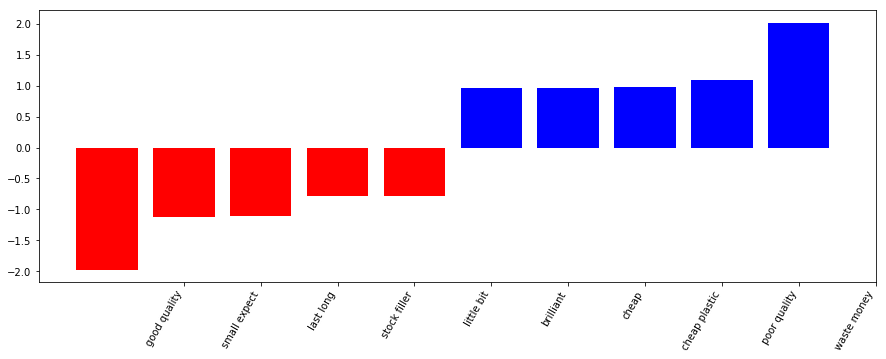

[ 63046 284044 124187 203603  95323]
[286127 108715 144715  23165  63060]
[286127 108715 144715  23165  63060  63046 284044 124187 203603  95323]


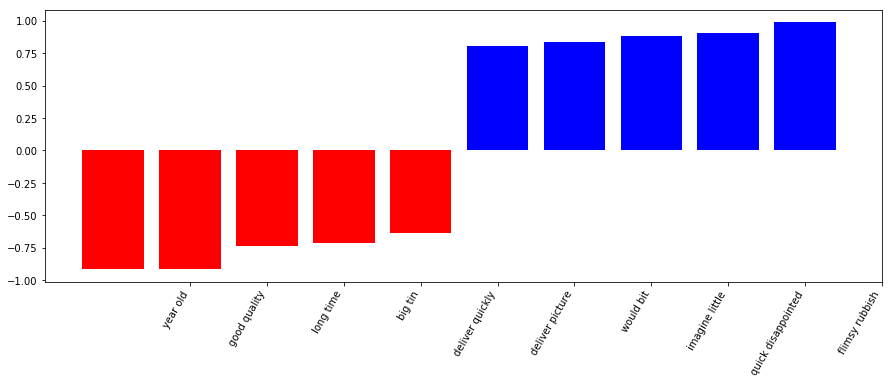

[ 23165 103894 194218 105909 146693]
[275448 111667 108715  32264 141362]
[275448 111667 108715  32264 141362  23165 103894 194218 105909 146693]


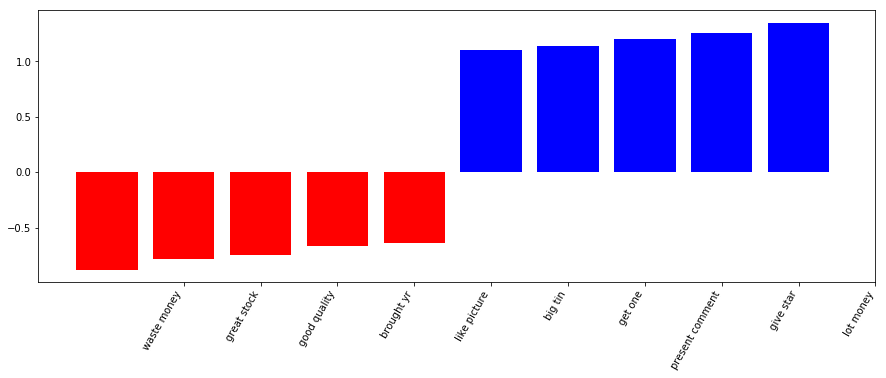

[286127 108188 108680 108876 104847]
[192024 278876  23843 202624  83448]
[192024 278876  23843 202624  83448 286127 108188 108680 108876 104847]


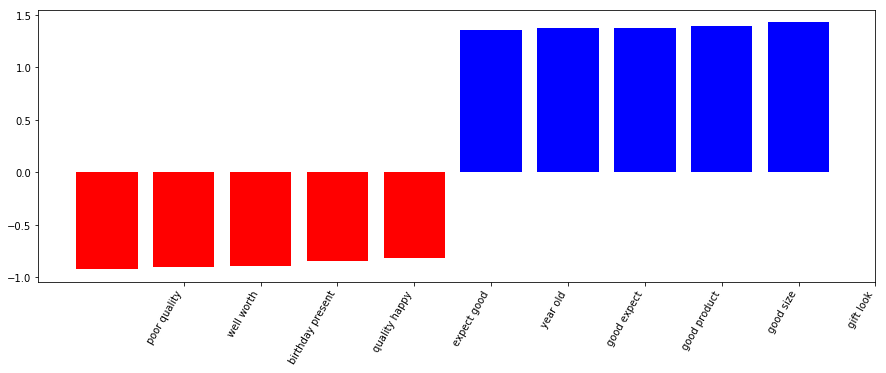

[145326 235645 110552 207822 278876]
[160111 202611   7695 222430 203127]
[160111 202611   7695 222430 203127 145326 235645 110552 207822 278876]


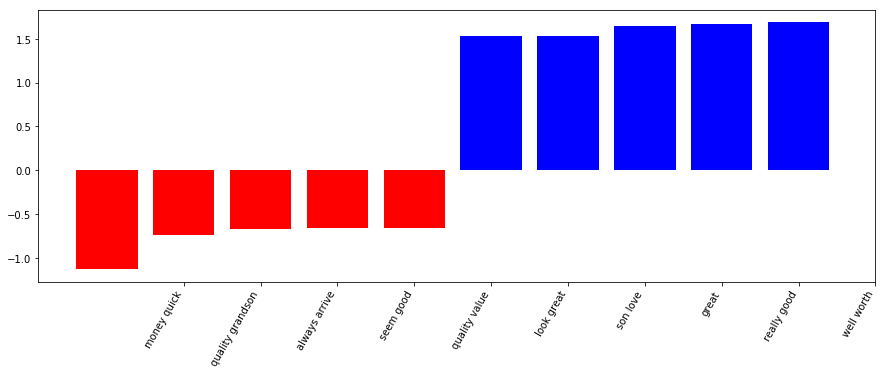

[[ 41   8   7   3   2]
 [ 26  14  11   1   3]
 [ 66  31  42  15   6]
 [224  84  81  81  25]
 [929 297 266 361 199]]
              precision    recall  f1-score   support

           1       0.03      0.67      0.06        61
           2       0.03      0.25      0.06        55
           3       0.10      0.26      0.15       160
           4       0.18      0.16      0.17       495
           5       0.85      0.10      0.17      2052

   micro avg       0.13      0.13      0.13      2823
   macro avg       0.24      0.29      0.12      2823
weighted avg       0.65      0.13      0.17      2823

endd:  2019-05-04 00:33:32.770211
startt:  2019-05-04 00:33:32.771210
halo 25389 2823 25389 2823
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

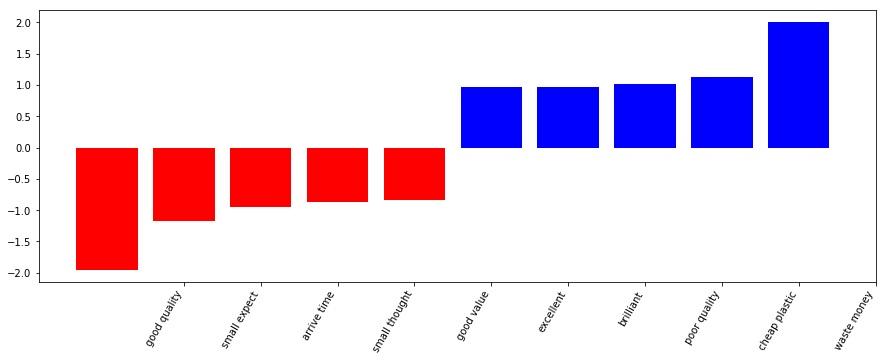

[261041  63046 192050 203603  95323]
[286127 108715  23165  63060  13090]
[286127 108715  23165  63060  13090 261041  63046 192050 203603  95323]


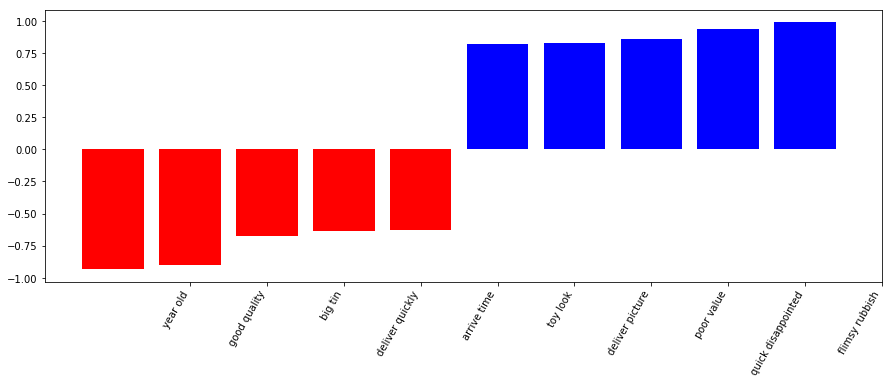

[103894  24211 194218 284042 146693]
[ 83592 275448 108715 111667  32264]
[ 83592 275448 108715 111667  32264 103894  24211 194218 284042 146693]


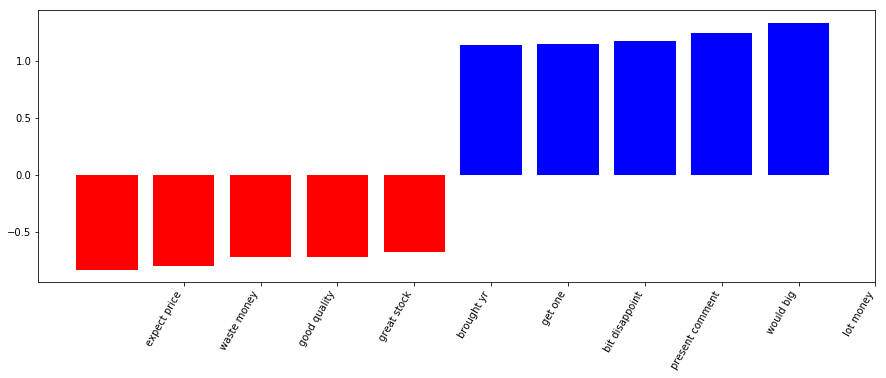

[111667 108680 108876 286127 147303]
[192024 194591  83448 190163 202624]
[192024 194591  83448 190163 202624 111667 108680 108876 286127 147303]


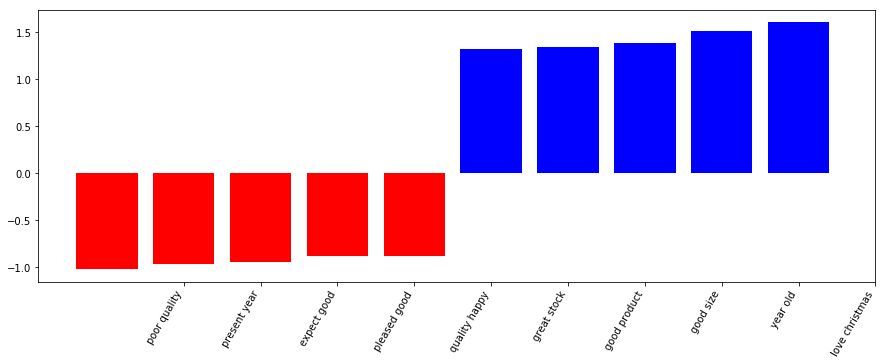

[194591  59879 110552 207822 278876]
[160111 203158 148595  88620 274397]
[160111 203158 148595  88620 274397 194591  59879 110552 207822 278876]


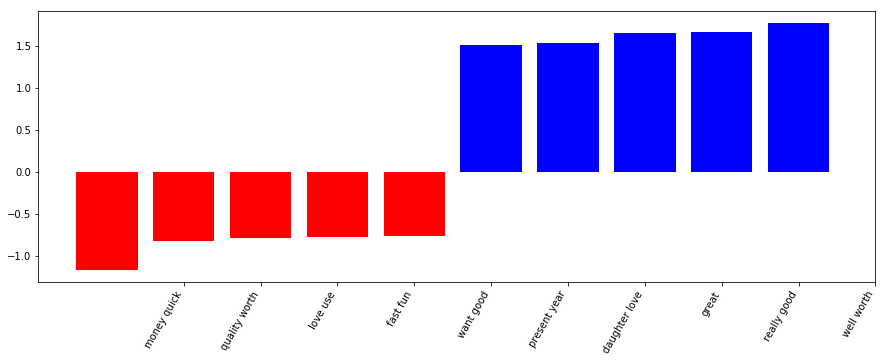

[[ 42   9   8   1   1]
 [ 29  13   8   3   2]
 [ 82  20  28  21   9]
 [194  59 108  88  46]
 [918 228 293 358 255]]
              precision    recall  f1-score   support

           1       0.03      0.69      0.06        61
           2       0.04      0.24      0.07        55
           3       0.06      0.17      0.09       160
           4       0.19      0.18      0.18       495
           5       0.81      0.12      0.22      2052

   micro avg       0.15      0.15      0.15      2823
   macro avg       0.23      0.28      0.12      2823
weighted avg       0.63      0.15      0.20      2823

endd:  2019-05-04 00:33:38.419326
startt:  2019-05-04 00:33:38.421322
halo 25389 2823 25389 2823
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

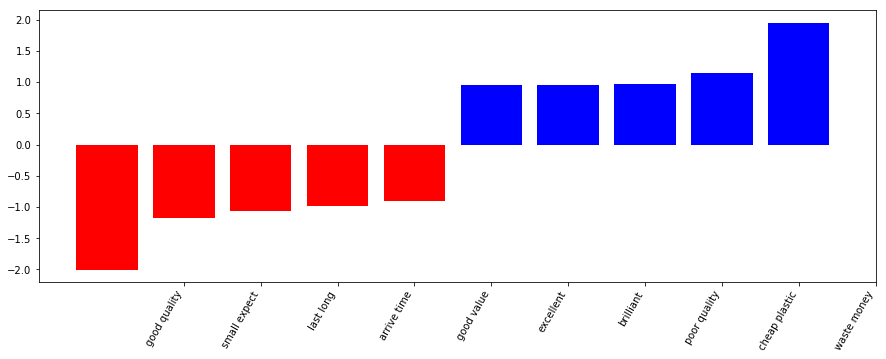

[231200 192050 261041 284044  95323]
[108715  63060 286127  23165 144715]
[108715  63060 286127  23165 144715 231200 192050 261041 284044  95323]


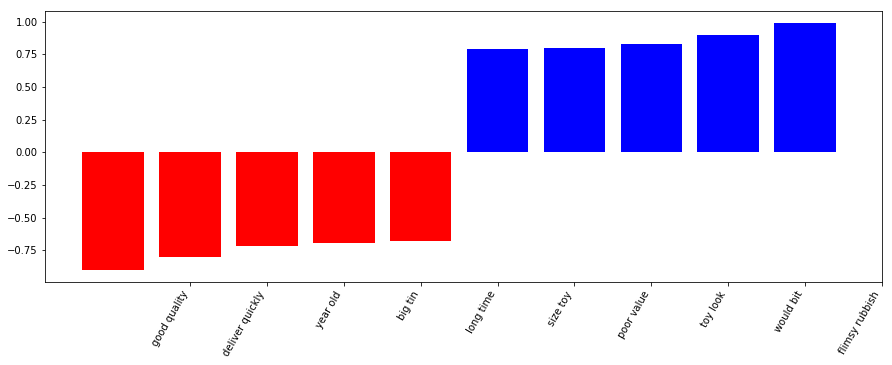

[ 83507 208087  24212 194218 146693]
[ 83592 275448 111667 232881 111224]
[ 83592 275448 111667 232881 111224  83507 208087  24212 194218 146693]


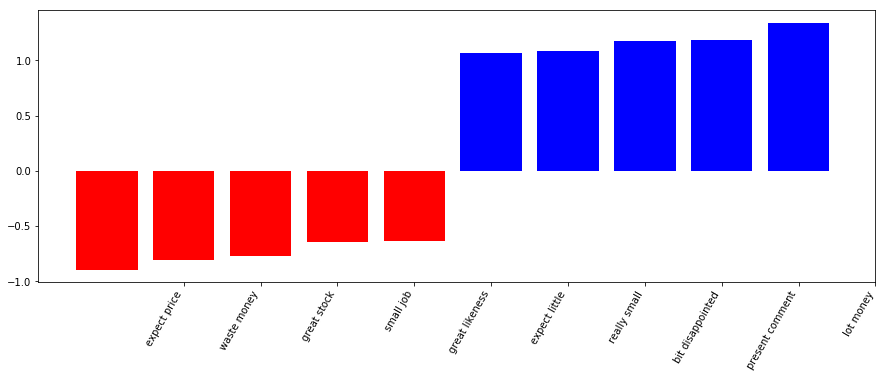

[109857 202611 285670 104847 111667]
[ 83448 194591 278876 192024 232811]
[ 83448 194591 278876 192024 232811 109857 202611 285670 104847 111667]


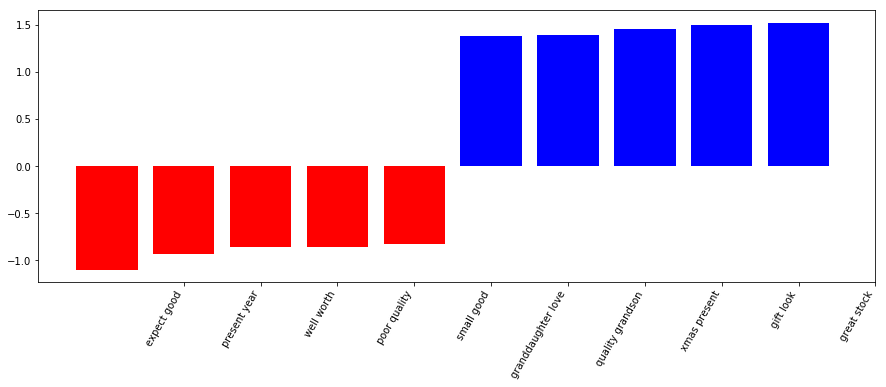

[108715 145326 110552 207822 278876]
[160111 202611   7695  88620 260573]
[160111 202611   7695  88620 260573 108715 145326 110552 207822 278876]


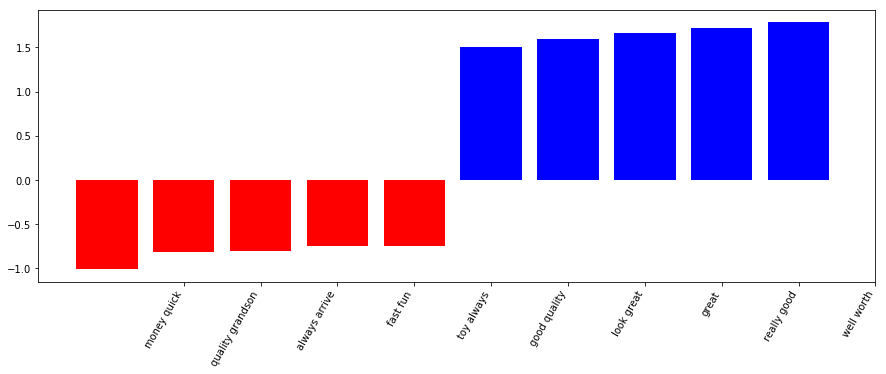

[[  46    5    8    1    1]
 [  33    7   11    4    0]
 [  93   17   39   10    1]
 [ 230   60   94   80   31]
 [1070  225  193  342  222]]
              precision    recall  f1-score   support

           1       0.03      0.75      0.06        61
           2       0.02      0.13      0.04        55
           3       0.11      0.24      0.15       160
           4       0.18      0.16      0.17       495
           5       0.87      0.11      0.19      2052

   micro avg       0.14      0.14      0.14      2823
   macro avg       0.24      0.28      0.12      2823
weighted avg       0.67      0.14      0.18      2823

endd:  2019-05-04 00:33:46.023770
startt:  2019-05-04 00:33:46.025770
halo 25389 2823 25389 2823
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

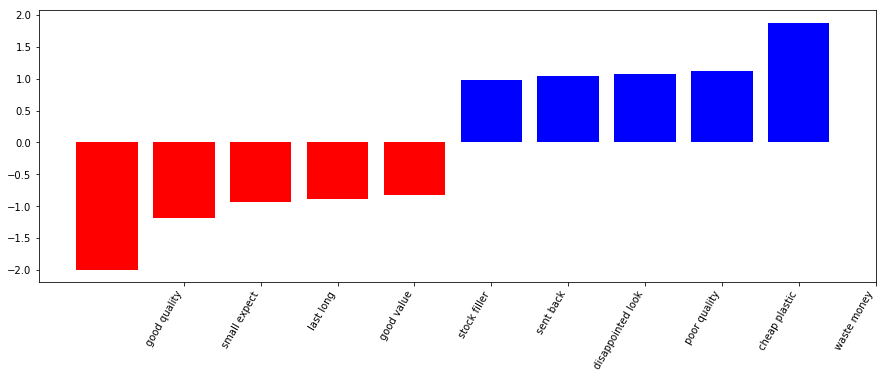

[192050 284044 261041 203603  95323]
[108715 286127  23165  24704  59879]
[108715 286127  23165  24704  59879 192050 284044 261041 203603  95323]


KeyboardInterrupt: 

In [32]:
#PIPELINE FE ONLY

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import NearMiss

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC,LinearSVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=5):
    print(classifier)
    coef = classifier.coef_
    print(coef)
#     feature = []
#     for i in range(3):
#         for j in range(len(feature_names)):
#             feature.append(feature_names[j])
            
#     print(feature)
    
    for i in range(len(coef)):
        top_positive_coefficients = np.argsort(coef[i])[-top_features:]
        top_negative_coefficients = np.argsort(coef[i])[:top_features]
#         print(top_positive_coefficients)
#         print(top_negative_coefficients)
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#         print(top_coefficients)
        # create plot
        plt.figure(figsize=(15, 5))
        colors = ['red' if c < 0 else 'blue' for c in coef[i][top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[i][top_coefficients], color=colors)
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
        plt.show()



def SVM_undersampling(X,Y):

#     #normalize data
#     scaler1 = MinMaxScaler(feature_range=(0,1))
#     # tfidf_val_1 = np.array(tfidf_val_1)
#     # X = X.reshape(1,-1)
#     X = scaler1.fit_transform(X)

#     scaler2 = MinMaxScaler(feature_range=(1,5))
#     Y = scaler2.fit_transform(Y)
#     Y = Y.ravel()  #prevent DataConversionError
#     print(len(X),len(Y))
    
    classifier_score=[]
    accuracy = []
    precision_micro = []
    recall_micro = []
    f1_micro =[]
    precision_macro = []
    recall_macro = []
    f1_macro =[]
    precision_weighted = []
    recall_weighted = []
    f1_weighted =[]

    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = False)

    

    for train_index, test_index in cv.split(X,Y):
        
        print("startt: ",datetime.datetime.now())

        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = Y[train_index],Y[test_index]
        
        print('halo',X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0])

        #Oversampling
        nr = NearMiss()
        X_train_smt,y_train_smt = nr.fit_sample(X_train,y_train)
        
        

        
#         svclassifier = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',cache_size=1000))
#         svclassifier = SVC(kernel='linear',gamma='auto',cache_size=1000)
        svclassifier = LinearSVC()
        
        svc = svclassifier.fit(X_train_smt,y_train_smt)
        
#         pipeline = make_pipeline(NearMiss(),LinearSVC())
#         svclassifier=pipeline.fit(X_train, y_train)
        
#         plot_coefficients(svclassifier, tfidf_1.get_feature_names())
        
        
        
        y_pred = svclassifier.predict(X_test)
        
        print(confusion_matrix(y_test,y_pred))  
        print(classification_report(y_test,y_pred))

        classifier_score.append(svclassifier.score(X_test,y_test))
        accuracy.append(accuracy_score(y_test,y_pred))
        precision_micro.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        recall_micro.append(recall_score(y_test,y_pred,average='micro'))
        f1_micro.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        precision_macro.append(precision_score(y_test,y_pred,average='macro',labels=np.unique(y_pred)))
        recall_macro.append(recall_score(y_test,y_pred,average='macro'))
        f1_macro.append(f1_score(y_test,y_pred,average='macro',labels=np.unique(y_pred)))
        precision_weighted.append(precision_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
        recall_weighted.append(recall_score(y_test,y_pred,average='weighted'))
        f1_weighted.append(f1_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
        print("endd: ",datetime.datetime.now())

    print("done loop",datetime.datetime.now())
    
    print("classifier_score: {}".format(np.mean(classifier_score)))
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision_micro: {}".format(np.mean(precision_micro)))
    print("recall_micro: {}".format(np.mean(recall_micro)))
    print("f1_micro: {}".format(np.mean(f1_micro)))
    print("")
    print("precision_macro: {}".format(np.mean(precision_macro)))
    print("recall_macro: {}".format(np.mean(recall_macro)))
    print("f1_macro: {}".format(np.mean(f1_macro)))
    print("")
    print("precision_weighted: {}".format(np.mean(precision_weighted)))
    print("recall_weighted: {}".format(np.mean(recall_weighted)))
    print("f1_weighted: {}".format(np.mean(f1_weighted)))
    
#     plotSVC('graph',X,Y,svc)

    print("final end",datetime.datetime.now())
    
        


# X = FE_result_1.iloc[:,[0]]
# Y = FE_result_1.iloc[:,[1]]




start = datetime.datetime.now()
SVM_undersampling(X_1,Y_train_1)
end = datetime.datetime.now()
duration = end - start
print("duration ",duration)

In [28]:
#Resampling with feature selection

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import NearMiss

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

#Support Vector Machine
from sklearn.svm import SVC,LinearSVC
# from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.pipeline import make_pipeline


def SVM_undersampling(X,Y):

#     #normalize data
#     scaler1 = MinMaxScaler(feature_range=(0,1))
#     # tfidf_val_1 = np.array(tfidf_val_1)
#     # X = X.reshape(1,-1)
#     X = scaler1.fit_transform(X)

#     scaler2 = MinMaxScaler(feature_range=(1,5))
#     Y = scaler2.fit_transform(Y)
#     Y = Y.ravel()  #prevent DataConversionError
#     print(len(X),len(Y))
    
    classifier_score=[]
    accuracy = []
    precision_micro = []
    recall_micro = []
    f1_micro =[]
    precision_macro = []
    recall_macro = []
    f1_macro =[]
    precision_weighted = []
    recall_weighted = []
    f1_weighted =[]

    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle = False)

    

    for train_index, test_index in cv.split(X,Y):
        
        print("startt: ",datetime.datetime.now())

        X_train,X_test = X[train_index],X[test_index]
        y_train,y_test = Y[train_index],Y[test_index]
        
        pipeline = make_pipeline(SelectKBest(chi2, k=50000),ADASYN(),
                         LinearSVC(random_state=42))
        svclassifier=pipeline.fit(X_train, y_train)
       

        
        
#         svclassifier = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',cache_size=1000))
#         svclassifier = SVC(kernel='linear',gamma='auto',cache_size=1000)
#         svclassifier = LinearSVC()
        
#         svc = svclassifier.fit(X_train_smt,y_train_smt)
#         print(X_test.shape[0])
        y_pred = svclassifier.predict(X_test)
        
        print(confusion_matrix(y_test,y_pred))  
        print(classification_report(y_test,y_pred))

        classifier_score.append(svclassifier.score(X_test,y_test))
        accuracy.append(accuracy_score(y_test,y_pred))
        precision_micro.append(precision_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        recall_micro.append(recall_score(y_test,y_pred,average='micro'))
        f1_micro.append(f1_score(y_test,y_pred,average='micro',labels=np.unique(y_pred)))
        precision_macro.append(precision_score(y_test,y_pred,average='macro',labels=np.unique(y_pred)))
        recall_macro.append(recall_score(y_test,y_pred,average='macro'))
        f1_macro.append(f1_score(y_test,y_pred,average='macro',labels=np.unique(y_pred)))
        precision_weighted.append(precision_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
        recall_weighted.append(recall_score(y_test,y_pred,average='weighted'))
        f1_weighted.append(f1_score(y_test,y_pred,average='weighted',labels=np.unique(y_pred)))
        print("endd: ",datetime.datetime.now())

    print("done loop",datetime.datetime.now())
    
    print("classifier_score: {}".format(np.mean(classifier_score)))
    print("accuracy: {}".format(np.mean(accuracy)))
    print("precision_micro: {}".format(np.mean(precision_micro)))
    print("recall_micro: {}".format(np.mean(recall_micro)))
    print("f1_micro: {}".format(np.mean(f1_micro)))
    print("")
    print("precision_macro: {}".format(np.mean(precision_macro)))
    print("recall_macro: {}".format(np.mean(recall_macro)))
    print("f1_macro: {}".format(np.mean(f1_macro)))
    print("")
    print("precision_weighted: {}".format(np.mean(precision_weighted)))
    print("recall_weighted: {}".format(np.mean(recall_weighted)))
    print("f1_weighted: {}".format(np.mean(f1_weighted)))
    
#     plotSVC('graph',X,Y,svc)

    print("final end",datetime.datetime.now())
    
        


# X = FE_result_1.iloc[:,[0]]
# Y = FE_result_1.iloc[:,[1]]




start = datetime.datetime.now()
SVM_undersampling(X_1,Y_train_1)
end = datetime.datetime.now()
duration = end - start
print("duration ",duration)

startt:  2019-05-04 00:16:20.702920
[[   5    0    4   15   37]
 [   1    1    4   21   28]
 [   0    0   16   66   78]
 [   0    0    6  172  317]
 [   0    1   25  322 1704]]
              precision    recall  f1-score   support

           1       0.83      0.08      0.15        61
           2       0.50      0.02      0.04        55
           3       0.29      0.10      0.15       160
           4       0.29      0.35      0.32       495
           5       0.79      0.83      0.81      2052

   micro avg       0.67      0.67      0.67      2823
   macro avg       0.54      0.28      0.29      2823
weighted avg       0.67      0.67      0.66      2823

endd:  2019-05-04 00:17:42.853092
startt:  2019-05-04 00:17:42.855092
[[   6    0    3   19   33]
 [   0    0    3   28   24]
 [   0    0   13   55   92]
 [   0    0   17  156  322]
 [   1    0   33  287 1731]]
              precision    recall  f1-score   support

           1       0.86      0.10      0.18        61
           2  

C:\Users\End User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[[   7    1    3   20   30]
 [   0    1    2   25   27]
 [   1    0    5   66   88]
 [   0    0   12  156  327]
 [   0    1    9  336 1706]]
              precision    recall  f1-score   support

           1       0.88      0.11      0.20        61
           2       0.33      0.02      0.03        55
           3       0.16      0.03      0.05       160
           4       0.26      0.32      0.28       495
           5       0.78      0.83      0.81      2052

   micro avg       0.66      0.66      0.66      2823
   macro avg       0.48      0.26      0.28      2823
weighted avg       0.65      0.66      0.64      2823

endd:  2019-05-04 00:20:27.658089
startt:  2019-05-04 00:20:27.658089
[[   3    0    1   17   40]
 [   1    1    2   21   30]
 [   1    0    9   56   94]
 [   0    0    5  155  335]
 [   1    0   20  265 1766]]
              precision    recall  f1-score   support

           1       0.50      0.05      0.09        61
           2       1.00      0.02      0.04       